In [55]:
# SARIMAX

In [56]:
import pandas as pd
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from matplotlib import pyplot as plt

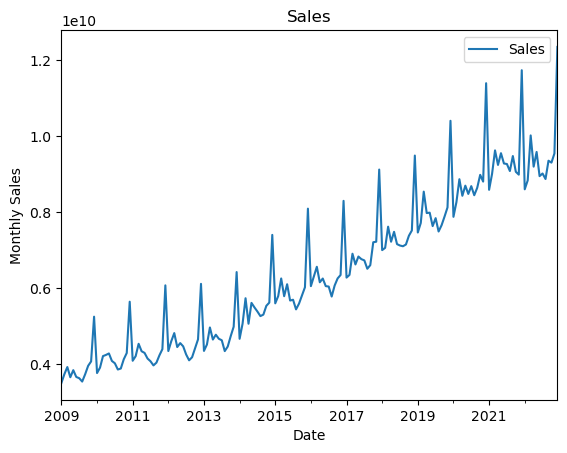

In [57]:
# pandasを使う
df = pd.read_csv("../public/full_monthly_sales.csv", index_col='Month', parse_dates=True)
df.plot()
plt.title('Sales')
plt.ylabel('Monthly Sales')
plt.xlabel('Date')
plt.show()

In [58]:
df_train = df[:144]
df_test = df[144:168]

# 対数変換
df_log = np.log(df).dropna()
df_log_train = df_log[:144]
df_log_test = df_log[144:168]

In [59]:
# pmdarimaのauto_arima関数を使って、ARIMAモデルを自動構築する。

arima_model = pm.auto_arima(df_log_train, 
                            seasonal=True,
                            m=12,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-572.865, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-193.934, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-355.773, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-195.275, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-373.278, Time=0.15 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-556.701, Time=0.25 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-557.792, Time=0.45 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-556.511, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-250.967, Time=0.05 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-408.695, Time=0.22 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-568.663, Time=0.34 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-575.268, Time=0.27 sec
 ARIMA(1,1,2)(0,0,1)[12] inte

In [60]:
# 予測
##学習データの期間の予測値
sarimax_train_log_pred = arima_model.predict_in_sample()
##テストデータの期間の予測値
sarimax_test_log_pred, sarimax_test_log_pred_ci = arima_model.predict(
    n_periods=df_log_test.shape[0], 
    return_conf_int=True
)

sarimax_train_pred = np.exp(sarimax_train_log_pred)
sarimax_test_pred = np.exp(sarimax_test_log_pred)

In [61]:
# 元系列に戻してMAPEを計算
print('MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))

MAPE:
0.07283870396613272


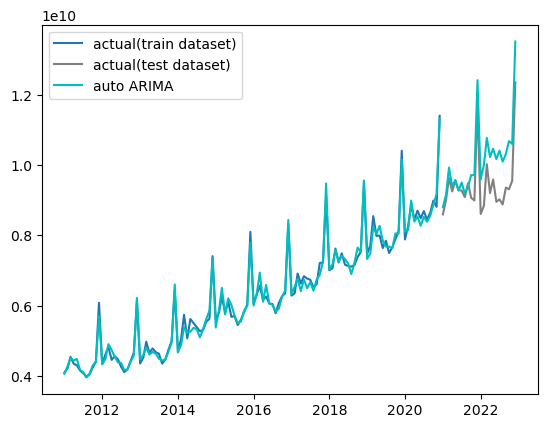

In [62]:
# 元系列のグラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, sarimax_train_pred[24:], color="c")
ax.plot(df_test.index, sarimax_test_pred, label="auto ARIMA", color="c") 
ax.legend()

In [63]:
# DNN

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, PReLU
from keras_tuner.tuners import RandomSearch

from sklearn.metrics import mean_absolute_percentage_error

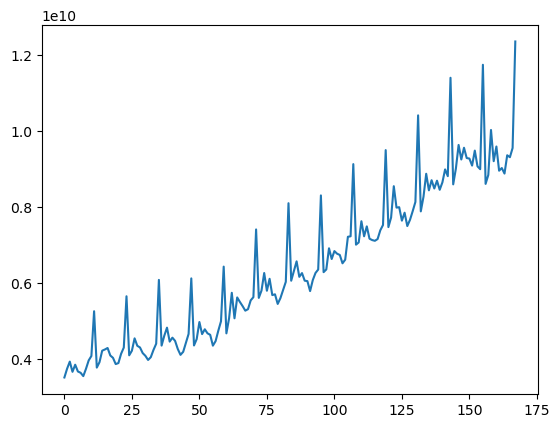

In [2]:
# numpyを使う
# ここでは元系列のまま分析を行う
series = np.loadtxt("../public/full_monthly_sales_without_header.csv")
plt.plot(series)
plt.show()

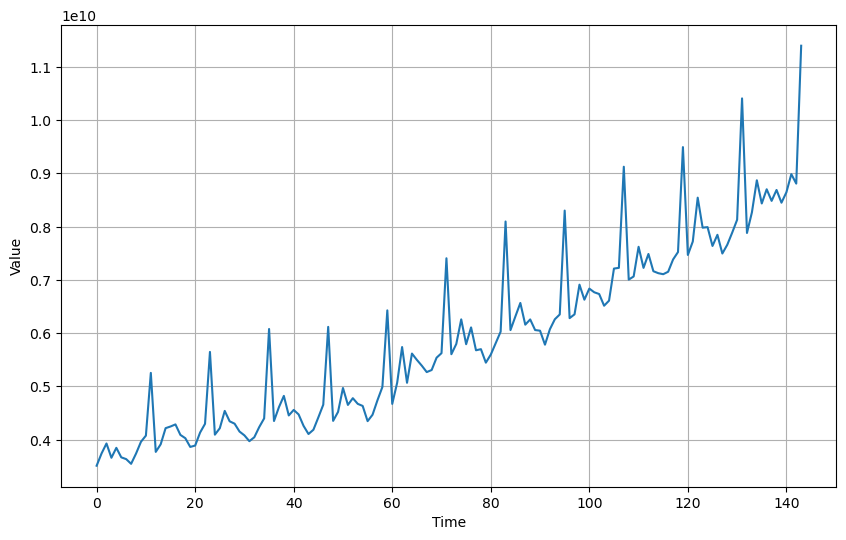

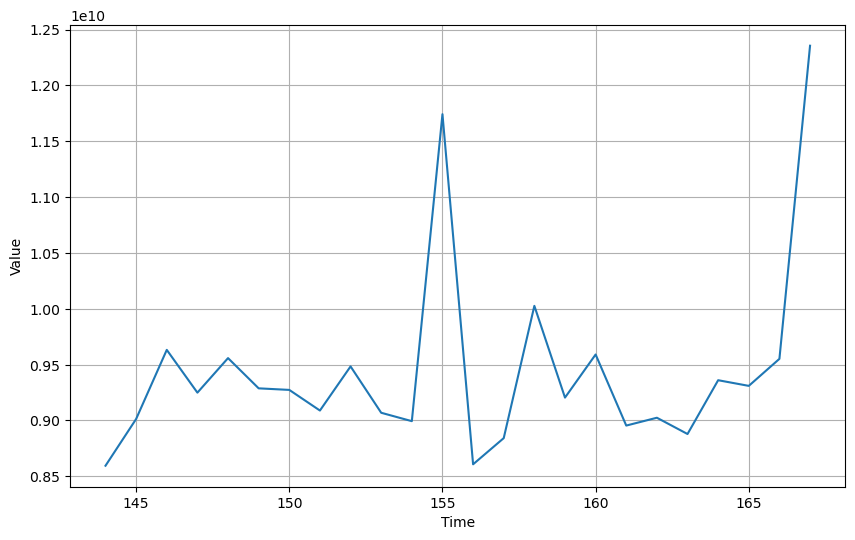

In [3]:
# 前半144時点を学習データ、以降を24時点を検証データとして分割

split_time = 144
time = np.arange(168, dtype="float32")

time_train = time[:split_time]
x_train = series[:split_time]
time_train_pred = time[20:split_time]
time_valid = time[split_time:168]
x_valid = series[split_time:168]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train) # 学習セット
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 検証セット
plt.show()

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [50]:
# DNN

In [5]:
%%time
# PReLU・エポック数500
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

2023-01-08 14:57:09.425583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 6s 2s/step - loss: 89.3388
Epoch 2/500
4/4 [==============================] - 0s 7ms/step - loss: 87.7368
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 85.9367
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 84.1293
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 82.3253
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 80.5088
Epoch 7/500
4/4 [==============================] - 0s 7ms/step - loss: 78.7008
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 76.8872
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 75.0738
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 73.2596
Epoch 11/500
4/4 [==============================] - 0s 6ms/step - loss: 71.4391
Epoch 12/500
4/4 [==============================] - 0s 4ms/step - loss: 69.6197
Epoch 13/500
4/4 [==============================] - 0s 12ms/st

4/4 [==============================] - 0s 4ms/step - loss: 8.7105
Epoch 105/500
4/4 [==============================] - 0s 7ms/step - loss: 8.6958
Epoch 106/500
4/4 [==============================] - 0s 6ms/step - loss: 8.6973
Epoch 107/500
4/4 [==============================] - 0s 6ms/step - loss: 8.6962
Epoch 108/500
4/4 [==============================] - 0s 5ms/step - loss: 8.6966
Epoch 109/500
4/4 [==============================] - 0s 4ms/step - loss: 8.6912
Epoch 110/500
4/4 [==============================] - 0s 4ms/step - loss: 8.6932
Epoch 111/500
4/4 [==============================] - 0s 7ms/step - loss: 8.6910
Epoch 112/500
4/4 [==============================] - 0s 10ms/step - loss: 8.6902
Epoch 113/500
4/4 [==============================] - 0s 7ms/step - loss: 8.6861
Epoch 114/500
4/4 [==============================] - 0s 4ms/step - loss: 8.6844
Epoch 115/500
4/4 [==============================] - 0s 3ms/step - loss: 8.6893
Epoch 116/500
4/4 [==============================] - 

4/4 [==============================] - 0s 4ms/step - loss: 8.5763
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 8.5794
Epoch 208/500
4/4 [==============================] - 0s 6ms/step - loss: 8.5739
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 8.5750
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 8.5715
Epoch 211/500
4/4 [==============================] - 0s 3ms/step - loss: 8.5704
Epoch 212/500
4/4 [==============================] - 0s 3ms/step - loss: 8.5699
Epoch 213/500
4/4 [==============================] - 0s 6ms/step - loss: 8.5693
Epoch 214/500
4/4 [==============================] - 0s 6ms/step - loss: 8.5814
Epoch 215/500
4/4 [==============================] - 0s 6ms/step - loss: 8.5688
Epoch 216/500
4/4 [==============================] - 0s 5ms/step - loss: 8.5701
Epoch 217/500
4/4 [==============================] - 0s 5ms/step - loss: 8.5675
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 8.4709
Epoch 309/500
4/4 [==============================] - 0s 4ms/step - loss: 8.4696
Epoch 310/500
4/4 [==============================] - 0s 46ms/step - loss: 8.4710
Epoch 311/500
4/4 [==============================] - 0s 5ms/step - loss: 8.4673
Epoch 312/500
4/4 [==============================] - 0s 3ms/step - loss: 8.4659
Epoch 313/500
4/4 [==============================] - 0s 4ms/step - loss: 8.4681
Epoch 314/500
4/4 [==============================] - 0s 5ms/step - loss: 8.4710
Epoch 315/500
4/4 [==============================] - 0s 3ms/step - loss: 8.4696
Epoch 316/500
4/4 [==============================] - 0s 5ms/step - loss: 8.4614
Epoch 317/500
4/4 [==============================] - 0s 10ms/step - loss: 8.4629
Epoch 318/500
4/4 [==============================] - 0s 6ms/step - loss: 8.4604
Epoch 319/500
4/4 [==============================] - 0s 4ms/step - loss: 8.4591
Epoch 320/500
4/4 [==============================] -

4/4 [==============================] - 0s 5ms/step - loss: 8.3717
Epoch 411/500
4/4 [==============================] - 0s 4ms/step - loss: 8.3687
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 8.3720
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 8.3749
Epoch 414/500
4/4 [==============================] - 0s 7ms/step - loss: 8.3657
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 8.3843
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 8.3625
Epoch 417/500
4/4 [==============================] - 0s 5ms/step - loss: 8.3638
Epoch 418/500
4/4 [==============================] - 0s 5ms/step - loss: 8.3637
Epoch 419/500
4/4 [==============================] - 0s 5ms/step - loss: 8.3638
Epoch 420/500
4/4 [==============================] - 0s 12ms/step - loss: 8.3604
Epoch 421/500
4/4 [==============================] - 0s 5ms/step - loss: 8.3590
Epoch 422/500
4/4 [==============================] - 

1/1 [==============================] - 0s 24ms/step


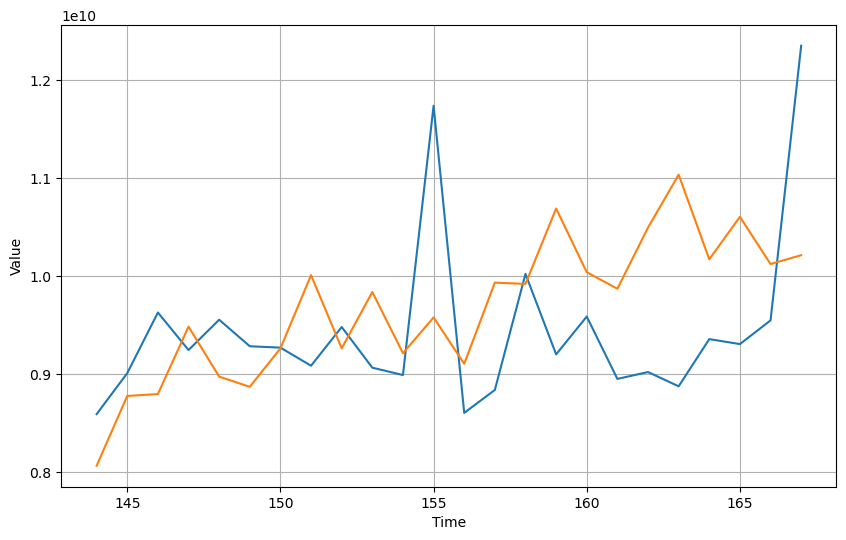

In [6]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [7]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.08727664123134593


In [8]:
%%time
# PReLU・エポック数500
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
4/4 [==============================] - 5s 47ms/step - loss: 183.5558
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 181.9707
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 180.2010
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 178.4164
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 176.6390
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 174.8374
Epoch 7/500
4/4 [==============================] - 0s 8ms/step - loss: 173.0391
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 171.2287
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 169.4141
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 167.5935
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 165.7826
Epoch 12/500
4/4 [==============================] - 0s 6ms/step - loss: 163.9727
Epoch 13/500
4/4 [==================

4/4 [==============================] - 0s 4ms/step - loss: 55.7094
Epoch 103/500
4/4 [==============================] - 0s 8ms/step - loss: 54.9994
Epoch 104/500
4/4 [==============================] - 0s 5ms/step - loss: 54.2925
Epoch 105/500
4/4 [==============================] - 0s 5ms/step - loss: 53.5871
Epoch 106/500
4/4 [==============================] - 0s 5ms/step - loss: 52.8859
Epoch 107/500
4/4 [==============================] - 0s 4ms/step - loss: 52.1914
Epoch 108/500
4/4 [==============================] - 0s 7ms/step - loss: 51.4922
Epoch 109/500
4/4 [==============================] - 0s 6ms/step - loss: 50.7984
Epoch 110/500
4/4 [==============================] - 0s 6ms/step - loss: 50.1104
Epoch 111/500
4/4 [==============================] - 0s 7ms/step - loss: 49.4157
Epoch 112/500
4/4 [==============================] - 0s 4ms/step - loss: 48.7240
Epoch 113/500
4/4 [==============================] - 0s 9ms/step - loss: 48.0282
Epoch 114/500
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 6.7052
Epoch 204/500
4/4 [==============================] - 0s 3ms/step - loss: 6.7005
Epoch 205/500
4/4 [==============================] - 0s 3ms/step - loss: 6.6986
Epoch 206/500
4/4 [==============================] - 0s 6ms/step - loss: 6.6972
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 6.6940
Epoch 208/500
4/4 [==============================] - 0s 3ms/step - loss: 6.6919
Epoch 209/500
4/4 [==============================] - 0s 3ms/step - loss: 6.6896
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 6.6902
Epoch 211/500
4/4 [==============================] - 0s 4ms/step - loss: 6.6855
Epoch 212/500
4/4 [==============================] - 0s 4ms/step - loss: 6.6833
Epoch 213/500
4/4 [==============================] - 0s 3ms/step - loss: 6.6820
Epoch 214/500
4/4 [==============================] - 0s 4ms/step - loss: 6.6824
Epoch 215/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 5ms/step - loss: 6.5091
Epoch 306/500
4/4 [==============================] - 0s 4ms/step - loss: 6.5057
Epoch 307/500
4/4 [==============================] - 0s 4ms/step - loss: 6.5034
Epoch 308/500
4/4 [==============================] - 0s 28ms/step - loss: 6.5025
Epoch 309/500
4/4 [==============================] - 0s 9ms/step - loss: 6.5017
Epoch 310/500
4/4 [==============================] - 0s 7ms/step - loss: 6.4990
Epoch 311/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4992
Epoch 312/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4978
Epoch 313/500
4/4 [==============================] - 0s 5ms/step - loss: 6.4978
Epoch 314/500
4/4 [==============================] - 0s 29ms/step - loss: 6.4960
Epoch 315/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4951
Epoch 316/500
4/4 [==============================] - 0s 5ms/step - loss: 6.4952
Epoch 317/500
4/4 [==============================] -

4/4 [==============================] - 0s 4ms/step - loss: 6.4212
Epoch 408/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4172
Epoch 409/500
4/4 [==============================] - 0s 6ms/step - loss: 6.4175
Epoch 410/500
4/4 [==============================] - 0s 9ms/step - loss: 6.4172
Epoch 411/500
4/4 [==============================] - 0s 5ms/step - loss: 6.4149
Epoch 412/500
4/4 [==============================] - 0s 7ms/step - loss: 6.4157
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4138
Epoch 414/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4155
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4131
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4169
Epoch 417/500
4/4 [==============================] - 0s 8ms/step - loss: 6.4113
Epoch 418/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4095
Epoch 419/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 18ms/step


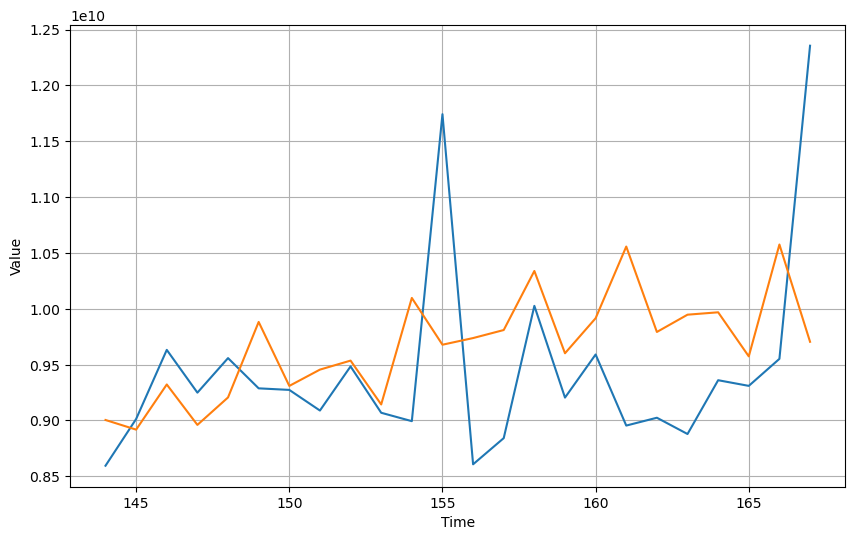

In [9]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [10]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.07196752767167218


In [11]:
%%time
# PReLU・エポック数1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
4/4 [==============================] - 2s 52ms/step - loss: 179.1358
Epoch 2/500
4/4 [==============================] - 0s 4ms/step - loss: 178.0713
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 176.8929
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 175.7071
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 174.5305
Epoch 6/500
4/4 [==============================] - 0s 13ms/step - loss: 173.3631
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 172.2001
Epoch 8/500
4/4 [==============================] - 0s 9ms/step - loss: 171.0430
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 169.8941
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 168.7512
Epoch 11/500
4/4 [==============================] - 0s 3ms/step - loss: 167.6166
Epoch 12/500
4/4 [==============================] - 0s 6ms/step - loss: 166.4866
Epoch 13/500
4/4 [=================

4/4 [==============================] - 0s 5ms/step - loss: 76.6373
Epoch 103/500
4/4 [==============================] - 0s 5ms/step - loss: 75.6162
Epoch 104/500
4/4 [==============================] - 0s 3ms/step - loss: 74.6030
Epoch 105/500
4/4 [==============================] - 0s 4ms/step - loss: 73.6397
Epoch 106/500
4/4 [==============================] - 0s 5ms/step - loss: 72.7165
Epoch 107/500
4/4 [==============================] - 0s 4ms/step - loss: 71.8258
Epoch 108/500
4/4 [==============================] - 0s 4ms/step - loss: 70.9641
Epoch 109/500
4/4 [==============================] - 0s 8ms/step - loss: 70.1360
Epoch 110/500
4/4 [==============================] - 0s 7ms/step - loss: 69.3643
Epoch 111/500
4/4 [==============================] - 0s 4ms/step - loss: 68.6480
Epoch 112/500
4/4 [==============================] - 0s 3ms/step - loss: 67.9555
Epoch 113/500
4/4 [==============================] - 0s 5ms/step - loss: 67.2827
Epoch 114/500
4/4 [=======================

4/4 [==============================] - 0s 3ms/step - loss: 11.0358
Epoch 204/500
4/4 [==============================] - 0s 2ms/step - loss: 10.4889
Epoch 205/500
4/4 [==============================] - 0s 4ms/step - loss: 9.9717
Epoch 206/500
4/4 [==============================] - 0s 4ms/step - loss: 9.5161
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 9.1130
Epoch 208/500
4/4 [==============================] - 0s 6ms/step - loss: 8.7926
Epoch 209/500
4/4 [==============================] - 0s 5ms/step - loss: 8.5050
Epoch 210/500
4/4 [==============================] - 0s 9ms/step - loss: 8.2825
Epoch 211/500
4/4 [==============================] - 0s 4ms/step - loss: 8.1023
Epoch 212/500
4/4 [==============================] - 0s 5ms/step - loss: 7.9616
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 7.8301
Epoch 214/500
4/4 [==============================] - 0s 4ms/step - loss: 7.7252
Epoch 215/500
4/4 [==============================] -

4/4 [==============================] - 0s 3ms/step - loss: 7.1347
Epoch 306/500
4/4 [==============================] - 0s 4ms/step - loss: 7.1323
Epoch 307/500
4/4 [==============================] - 0s 4ms/step - loss: 7.1328
Epoch 308/500
4/4 [==============================] - 0s 8ms/step - loss: 7.1316
Epoch 309/500
4/4 [==============================] - 0s 4ms/step - loss: 7.1312
Epoch 310/500
4/4 [==============================] - 0s 4ms/step - loss: 7.1312
Epoch 311/500
4/4 [==============================] - 0s 8ms/step - loss: 7.1295
Epoch 312/500
4/4 [==============================] - 0s 4ms/step - loss: 7.1299
Epoch 313/500
4/4 [==============================] - 0s 3ms/step - loss: 7.1323
Epoch 314/500
4/4 [==============================] - 0s 3ms/step - loss: 7.1379
Epoch 315/500
4/4 [==============================] - 0s 4ms/step - loss: 7.1287
Epoch 316/500
4/4 [==============================] - 0s 4ms/step - loss: 7.1305
Epoch 317/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 7.0925
Epoch 408/500
4/4 [==============================] - 0s 4ms/step - loss: 7.0913
Epoch 409/500
4/4 [==============================] - 0s 5ms/step - loss: 7.0905
Epoch 410/500
4/4 [==============================] - 0s 2ms/step - loss: 7.0927
Epoch 411/500
4/4 [==============================] - 0s 5ms/step - loss: 7.0898
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 7.0927
Epoch 413/500
4/4 [==============================] - 0s 5ms/step - loss: 7.0891
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 7.0885
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 7.0900
Epoch 416/500
4/4 [==============================] - 0s 6ms/step - loss: 7.0879
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 7.0904
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 7.0871
Epoch 419/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 20ms/step


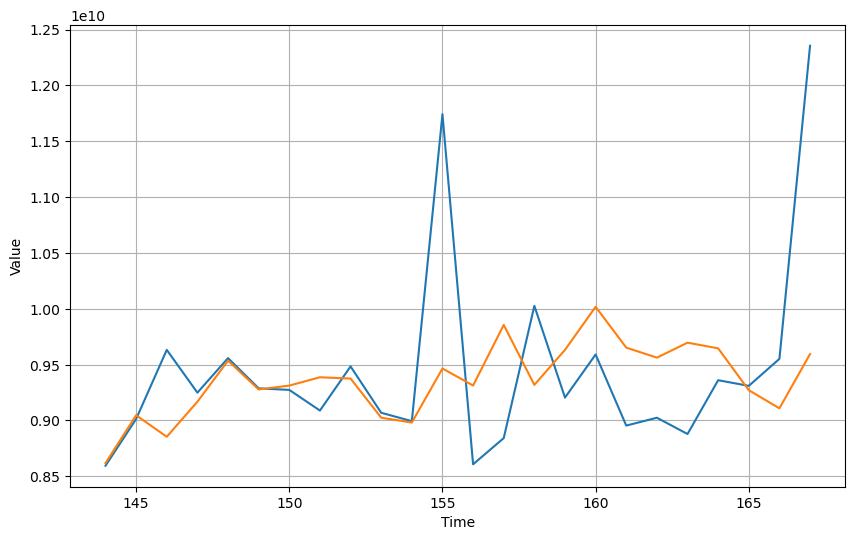

In [12]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [13]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.05167577167506504


In [14]:
%%time
# PReLU・エポック数2000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=2000,verbose=1)

Epoch 1/2000


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 4s 39ms/step - loss: 122.1322
Epoch 2/2000
4/4 [==============================] - 0s 5ms/step - loss: 121.8213
Epoch 3/2000
4/4 [==============================] - 0s 13ms/step - loss: 121.4731
Epoch 4/2000
4/4 [==============================] - 0s 3ms/step - loss: 121.1252
Epoch 5/2000
4/4 [==============================] - 0s 3ms/step - loss: 120.7782
Epoch 6/2000
4/4 [==============================] - 0s 3ms/step - loss: 120.4329
Epoch 7/2000
4/4 [==============================] - 0s 4ms/step - loss: 120.0884
Epoch 8/2000
4/4 [==============================] - 0s 22ms/step - loss: 119.7467
Epoch 9/2000
4/4 [==============================] - 0s 29ms/step - loss: 119.4058
Epoch 10/2000
4/4 [==============================] - 0s 5ms/step - loss: 119.0667
Epoch 11/2000
4/4 [==============================] - 0s 5ms/step - loss: 118.7280
Epoch 12/2000
4/4 [==============================] - 0s 4ms/step - loss: 118.3914
Epoch 13/2000
4/4 [===============

4/4 [==============================] - 0s 3ms/step - loss: 92.1322
Epoch 102/2000
4/4 [==============================] - 0s 4ms/step - loss: 91.8545
Epoch 103/2000
4/4 [==============================] - 0s 5ms/step - loss: 91.5769
Epoch 104/2000
4/4 [==============================] - 0s 4ms/step - loss: 91.2992
Epoch 105/2000
4/4 [==============================] - 0s 4ms/step - loss: 91.0199
Epoch 106/2000
4/4 [==============================] - 0s 4ms/step - loss: 90.7420
Epoch 107/2000
4/4 [==============================] - 0s 6ms/step - loss: 90.4627
Epoch 108/2000
4/4 [==============================] - 0s 3ms/step - loss: 90.1839
Epoch 109/2000
4/4 [==============================] - 0s 6ms/step - loss: 89.9051
Epoch 110/2000
4/4 [==============================] - 0s 6ms/step - loss: 89.6249
Epoch 111/2000
4/4 [==============================] - 0s 4ms/step - loss: 89.3453
Epoch 112/2000
4/4 [==============================] - 0s 8ms/step - loss: 89.0652
Epoch 113/2000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 61.2108
Epoch 201/2000
4/4 [==============================] - 0s 15ms/step - loss: 60.8294
Epoch 202/2000
4/4 [==============================] - 0s 4ms/step - loss: 60.4459
Epoch 203/2000
4/4 [==============================] - 0s 4ms/step - loss: 60.0606
Epoch 204/2000
4/4 [==============================] - 0s 4ms/step - loss: 59.6730
Epoch 205/2000
4/4 [==============================] - 0s 4ms/step - loss: 59.2825
Epoch 206/2000
4/4 [==============================] - 0s 4ms/step - loss: 58.8902
Epoch 207/2000
4/4 [==============================] - 0s 7ms/step - loss: 58.4953
Epoch 208/2000
4/4 [==============================] - 0s 23ms/step - loss: 58.0987
Epoch 209/2000
4/4 [==============================] - 0s 9ms/step - loss: 57.6987
Epoch 210/2000
4/4 [==============================] - 0s 14ms/step - loss: 57.2978
Epoch 211/2000
4/4 [==============================] - 0s 5ms/step - loss: 56.8933
Epoch 212/2000
4/4 [========

4/4 [==============================] - 0s 5ms/step - loss: 9.6909
Epoch 300/2000
4/4 [==============================] - 0s 3ms/step - loss: 9.2545
Epoch 301/2000
4/4 [==============================] - 0s 4ms/step - loss: 8.8565
Epoch 302/2000
4/4 [==============================] - 0s 11ms/step - loss: 8.5291
Epoch 303/2000
4/4 [==============================] - 0s 5ms/step - loss: 8.2554
Epoch 304/2000
4/4 [==============================] - 0s 29ms/step - loss: 8.0437
Epoch 305/2000
4/4 [==============================] - 0s 7ms/step - loss: 7.8470
Epoch 306/2000
4/4 [==============================] - 0s 6ms/step - loss: 7.6899
Epoch 307/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.5657
Epoch 308/2000
4/4 [==============================] - 0s 5ms/step - loss: 7.4580
Epoch 309/2000
4/4 [==============================] - 0s 8ms/step - loss: 7.3624
Epoch 310/2000
4/4 [==============================] - 0s 4ms/step - loss: 7.2721
Epoch 311/2000
4/4 [=====================

4/4 [==============================] - 0s 4ms/step - loss: 6.7400
Epoch 401/2000
4/4 [==============================] - 0s 8ms/step - loss: 6.7361
Epoch 402/2000
4/4 [==============================] - 0s 19ms/step - loss: 6.7373
Epoch 403/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.7332
Epoch 404/2000
4/4 [==============================] - 0s 9ms/step - loss: 6.7334
Epoch 405/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.7309
Epoch 406/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.7308
Epoch 407/2000
4/4 [==============================] - 0s 23ms/step - loss: 6.7296
Epoch 408/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.7289
Epoch 409/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.7295
Epoch 410/2000
4/4 [==============================] - 0s 24ms/step - loss: 6.7287
Epoch 411/2000
4/4 [==============================] - 0s 9ms/step - loss: 6.7263
Epoch 412/2000
4/4 [====================

4/4 [==============================] - 0s 3ms/step - loss: 6.6834
Epoch 502/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.6829
Epoch 503/2000
4/4 [==============================] - 0s 7ms/step - loss: 6.6832
Epoch 504/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.6817
Epoch 505/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.6817
Epoch 506/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.6808
Epoch 507/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.6812
Epoch 508/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.6819
Epoch 509/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.6795
Epoch 510/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.6811
Epoch 511/2000
4/4 [==============================] - 0s 9ms/step - loss: 6.6802
Epoch 512/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.6793
Epoch 513/2000
4/4 [=======================

4/4 [==============================] - 0s 7ms/step - loss: 6.6489
Epoch 603/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.6481
Epoch 604/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.6478
Epoch 605/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.6499
Epoch 606/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.6464
Epoch 607/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.6460
Epoch 608/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.6465
Epoch 609/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.6486
Epoch 610/2000
4/4 [==============================] - 0s 10ms/step - loss: 6.6458
Epoch 611/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.6457
Epoch 612/2000
4/4 [==============================] - 0s 8ms/step - loss: 6.6453
Epoch 613/2000
4/4 [==============================] - 0s 8ms/step - loss: 6.6473
Epoch 614/2000
4/4 [======================

4/4 [==============================] - 0s 4ms/step - loss: 6.6190
Epoch 704/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.6190
Epoch 705/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.6173
Epoch 706/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.6183
Epoch 707/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.6171
Epoch 708/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.6180
Epoch 709/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.6164
Epoch 710/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.6186
Epoch 711/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.6145
Epoch 712/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.6155
Epoch 713/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.6158
Epoch 714/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.6156
Epoch 715/2000
4/4 [=======================

4/4 [==============================] - 0s 10ms/step - loss: 6.5939
Epoch 805/2000
4/4 [==============================] - 0s 11ms/step - loss: 6.5905
Epoch 806/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.5906
Epoch 807/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.5919
Epoch 808/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5907
Epoch 809/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.5939
Epoch 810/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5907
Epoch 811/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5914
Epoch 812/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.5883
Epoch 813/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.5883
Epoch 814/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.5879
Epoch 815/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.5876
Epoch 816/2000
4/4 [=====================

4/4 [==============================] - 0s 3ms/step - loss: 6.5663
Epoch 906/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5667
Epoch 907/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.5689
Epoch 908/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.5649
Epoch 909/2000
4/4 [==============================] - 0s 7ms/step - loss: 6.5657
Epoch 910/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5688
Epoch 911/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5641
Epoch 912/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.5631
Epoch 913/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.5633
Epoch 914/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.5637
Epoch 915/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5619
Epoch 916/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5643
Epoch 917/2000
4/4 [=======================

4/4 [==============================] - 0s 4ms/step - loss: 6.5405
Epoch 1007/2000
4/4 [==============================] - 0s 8ms/step - loss: 6.5404
Epoch 1008/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5422
Epoch 1009/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5417
Epoch 1010/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.5398
Epoch 1011/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5433
Epoch 1012/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5401
Epoch 1013/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5413
Epoch 1014/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.5431
Epoch 1015/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5392
Epoch 1016/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.5395
Epoch 1017/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5389
Epoch 1018/2000
4/4 [===========

4/4 [==============================] - 0s 10ms/step - loss: 6.5238
Epoch 1107/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.5183
Epoch 1108/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.5186
Epoch 1109/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.5167
Epoch 1110/2000
4/4 [==============================] - 0s 9ms/step - loss: 6.5182
Epoch 1111/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.5160
Epoch 1112/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.5180
Epoch 1113/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5156
Epoch 1114/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5158
Epoch 1115/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5172
Epoch 1116/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.5195
Epoch 1117/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.5159
Epoch 1118/2000
4/4 [==========

4/4 [==============================] - 0s 6ms/step - loss: 6.4966
Epoch 1207/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4944
Epoch 1208/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4956
Epoch 1209/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4942
Epoch 1210/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4953
Epoch 1211/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4938
Epoch 1212/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4933
Epoch 1213/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4930
Epoch 1214/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4946
Epoch 1215/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4936
Epoch 1216/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.4931
Epoch 1217/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4931
Epoch 1218/2000
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 6.4727
Epoch 1307/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4746
Epoch 1308/2000
4/4 [==============================] - 0s 2ms/step - loss: 6.4755
Epoch 1309/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.4722
Epoch 1310/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4717
Epoch 1311/2000
4/4 [==============================] - 0s 6ms/step - loss: 6.4731
Epoch 1312/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4711
Epoch 1313/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4735
Epoch 1314/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4759
Epoch 1315/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4738
Epoch 1316/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4713
Epoch 1317/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.4706
Epoch 1318/2000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 6.4505
Epoch 1407/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4527
Epoch 1408/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.4500
Epoch 1409/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4519
Epoch 1410/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4515
Epoch 1411/2000
4/4 [==============================] - 0s 28ms/step - loss: 6.4499
Epoch 1412/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4495
Epoch 1413/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4531
Epoch 1414/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4526
Epoch 1415/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4534
Epoch 1416/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4482
Epoch 1417/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4497
Epoch 1418/2000
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 6.4288
Epoch 1507/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4291
Epoch 1508/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4290
Epoch 1509/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4295
Epoch 1510/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4278
Epoch 1511/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4282
Epoch 1512/2000
4/4 [==============================] - 0s 10ms/step - loss: 6.4287
Epoch 1513/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4281
Epoch 1514/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.4278
Epoch 1515/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.4273
Epoch 1516/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4286
Epoch 1517/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4266
Epoch 1518/2000
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 6.4083
Epoch 1606/2000
4/4 [==============================] - 0s 10ms/step - loss: 6.4088
Epoch 1607/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.4095
Epoch 1608/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.4089
Epoch 1609/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4079
Epoch 1610/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4061
Epoch 1611/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.4059
Epoch 1612/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4061
Epoch 1613/2000
4/4 [==============================] - 0s 16ms/step - loss: 6.4058
Epoch 1614/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4070
Epoch 1615/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.4051
Epoch 1616/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.4056
Epoch 1617/2000
4/4 [=========

4/4 [==============================] - 0s 3ms/step - loss: 6.3887
Epoch 1706/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.3888
Epoch 1707/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.3895
Epoch 1708/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.3886
Epoch 1709/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3849
Epoch 1710/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3877
Epoch 1711/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.3854
Epoch 1712/2000
4/4 [==============================] - 0s 16ms/step - loss: 6.3853
Epoch 1713/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3838
Epoch 1714/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3842
Epoch 1715/2000
4/4 [==============================] - 0s 2ms/step - loss: 6.3837
Epoch 1716/2000
4/4 [==============================] - 0s 10ms/step - loss: 6.3847
Epoch 1717/2000
4/4 [=========

4/4 [==============================] - 0s 16ms/step - loss: 6.3684
Epoch 1806/2000
4/4 [==============================] - 0s 9ms/step - loss: 6.3666
Epoch 1807/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.3653
Epoch 1808/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3638
Epoch 1809/2000
4/4 [==============================] - 0s 7ms/step - loss: 6.3653
Epoch 1810/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.3637
Epoch 1811/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.3637
Epoch 1812/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.3680
Epoch 1813/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.3646
Epoch 1814/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.3625
Epoch 1815/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3630
Epoch 1816/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.3638
Epoch 1817/2000
4/4 [==========

4/4 [==============================] - 0s 11ms/step - loss: 6.3436
Epoch 1906/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.3449
Epoch 1907/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3433
Epoch 1908/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3439
Epoch 1909/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3447
Epoch 1910/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3422
Epoch 1911/2000
4/4 [==============================] - 0s 4ms/step - loss: 6.3440
Epoch 1912/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.3423
Epoch 1913/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3431
Epoch 1914/2000
4/4 [==============================] - 0s 5ms/step - loss: 6.3420
Epoch 1915/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3420
Epoch 1916/2000
4/4 [==============================] - 0s 3ms/step - loss: 6.3414
Epoch 1917/2000
4/4 [==========

1/1 [==============================] - 0s 46ms/step


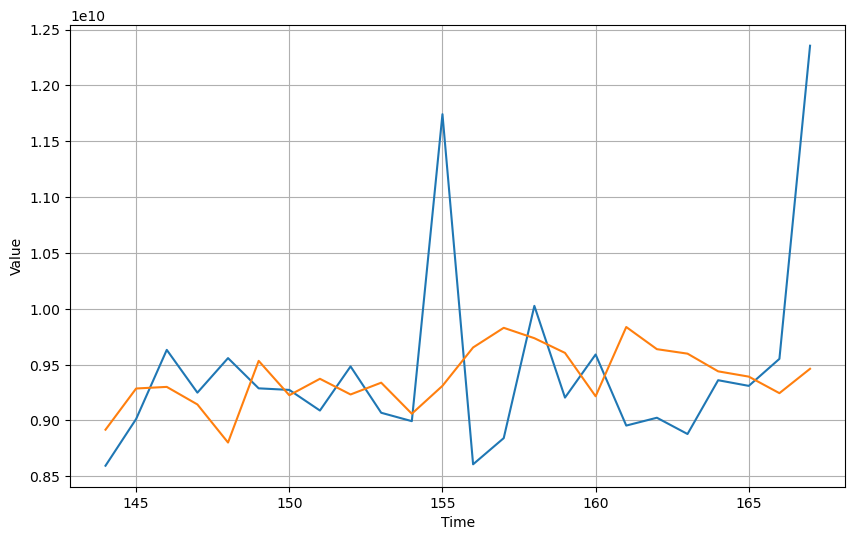

In [15]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [16]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.05842886872773421


In [17]:
%%time
# PReLU・エポック数5000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.5))
model.fit(dataset,epochs=5000,verbose=1)

Epoch 1/5000


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 3s 38ms/step - loss: 166.2728
Epoch 2/5000
4/4 [==============================] - 0s 3ms/step - loss: 165.6901
Epoch 3/5000
4/4 [==============================] - 0s 5ms/step - loss: 165.0457
Epoch 4/5000
4/4 [==============================] - 0s 5ms/step - loss: 164.4057
Epoch 5/5000
4/4 [==============================] - 0s 6ms/step - loss: 163.7697
Epoch 6/5000
4/4 [==============================] - 0s 6ms/step - loss: 163.1422
Epoch 7/5000
4/4 [==============================] - 0s 10ms/step - loss: 162.5194
Epoch 8/5000
4/4 [==============================] - 0s 5ms/step - loss: 161.9052
Epoch 9/5000
4/4 [==============================] - 0s 4ms/step - loss: 161.2968
Epoch 10/5000
4/4 [==============================] - 0s 4ms/step - loss: 160.6943
Epoch 11/5000
4/4 [==============================] - 0s 3ms/step - loss: 160.0966
Epoch 12/5000
4/4 [==============================] - 0s 4ms/step - loss: 159.5053
Epoch 13/5000
4/4 [=================

4/4 [==============================] - 0s 4ms/step - loss: 122.1335
Epoch 102/5000
4/4 [==============================] - 0s 3ms/step - loss: 121.8420
Epoch 103/5000
4/4 [==============================] - 0s 6ms/step - loss: 121.5517
Epoch 104/5000
4/4 [==============================] - 0s 4ms/step - loss: 121.2633
Epoch 105/5000
4/4 [==============================] - 0s 11ms/step - loss: 120.9777
Epoch 106/5000
4/4 [==============================] - 0s 4ms/step - loss: 120.6923
Epoch 107/5000
4/4 [==============================] - 0s 10ms/step - loss: 120.4079
Epoch 108/5000
4/4 [==============================] - 0s 5ms/step - loss: 120.1268
Epoch 109/5000
4/4 [==============================] - 0s 4ms/step - loss: 119.8456
Epoch 110/5000
4/4 [==============================] - 0s 4ms/step - loss: 119.5654
Epoch 111/5000
4/4 [==============================] - 0s 4ms/step - loss: 119.2898
Epoch 112/5000
4/4 [==============================] - 0s 4ms/step - loss: 119.0157
Epoch 113/5000
4/

4/4 [==============================] - 0s 3ms/step - loss: 102.1273
Epoch 200/5000
4/4 [==============================] - 0s 4ms/step - loss: 101.9886
Epoch 201/5000
4/4 [==============================] - 0s 4ms/step - loss: 101.8487
Epoch 202/5000
4/4 [==============================] - 0s 4ms/step - loss: 101.7102
Epoch 203/5000
4/4 [==============================] - 0s 5ms/step - loss: 101.5717
Epoch 204/5000
4/4 [==============================] - 0s 4ms/step - loss: 101.4329
Epoch 205/5000
4/4 [==============================] - 0s 5ms/step - loss: 101.2938
Epoch 206/5000
4/4 [==============================] - 0s 3ms/step - loss: 101.1564
Epoch 207/5000
4/4 [==============================] - 0s 5ms/step - loss: 101.0186
Epoch 208/5000
4/4 [==============================] - 0s 5ms/step - loss: 100.8811
Epoch 209/5000
4/4 [==============================] - 0s 6ms/step - loss: 100.7437
Epoch 210/5000
4/4 [==============================] - 0s 7ms/step - loss: 100.6068
Epoch 211/5000
4/4 

4/4 [==============================] - 0s 7ms/step - loss: 88.9325
Epoch 299/5000
4/4 [==============================] - 0s 6ms/step - loss: 88.7948
Epoch 300/5000
4/4 [==============================] - 0s 10ms/step - loss: 88.6569
Epoch 301/5000
4/4 [==============================] - 0s 4ms/step - loss: 88.5186
Epoch 302/5000
4/4 [==============================] - 0s 6ms/step - loss: 88.3798
Epoch 303/5000
4/4 [==============================] - 0s 5ms/step - loss: 88.2413
Epoch 304/5000
4/4 [==============================] - 0s 5ms/step - loss: 88.1014
Epoch 305/5000
4/4 [==============================] - 0s 5ms/step - loss: 87.9621
Epoch 306/5000
4/4 [==============================] - 0s 4ms/step - loss: 87.8223
Epoch 307/5000
4/4 [==============================] - 0s 8ms/step - loss: 87.6820
Epoch 308/5000
4/4 [==============================] - 0s 3ms/step - loss: 87.5415
Epoch 309/5000
4/4 [==============================] - 0s 7ms/step - loss: 87.4008
Epoch 310/5000
4/4 [==========

Epoch 398/5000
4/4 [==============================] - 0s 5ms/step - loss: 72.5812
Epoch 399/5000
4/4 [==============================] - 0s 4ms/step - loss: 72.3804
Epoch 400/5000
4/4 [==============================] - 0s 4ms/step - loss: 72.1790
Epoch 401/5000
4/4 [==============================] - 0s 4ms/step - loss: 71.9764
Epoch 402/5000
4/4 [==============================] - 0s 6ms/step - loss: 71.7730
Epoch 403/5000
4/4 [==============================] - 0s 3ms/step - loss: 71.5680
Epoch 404/5000
4/4 [==============================] - 0s 5ms/step - loss: 71.3625
Epoch 405/5000
4/4 [==============================] - 0s 3ms/step - loss: 71.1557
Epoch 406/5000
4/4 [==============================] - 0s 3ms/step - loss: 70.9476
Epoch 407/5000
4/4 [==============================] - 0s 8ms/step - loss: 70.7388
Epoch 408/5000
4/4 [==============================] - 0s 4ms/step - loss: 70.5289
Epoch 409/5000
4/4 [==============================] - 0s 4ms/step - loss: 70.3174
Epoch 410/5000
4

4/4 [==============================] - 0s 6ms/step - loss: 46.0401
Epoch 498/5000
4/4 [==============================] - 0s 4ms/step - loss: 45.6804
Epoch 499/5000
4/4 [==============================] - 0s 5ms/step - loss: 45.3176
Epoch 500/5000
4/4 [==============================] - 0s 5ms/step - loss: 44.9529
Epoch 501/5000
4/4 [==============================] - 0s 4ms/step - loss: 44.5858
Epoch 502/5000
4/4 [==============================] - 0s 4ms/step - loss: 44.2153
Epoch 503/5000
4/4 [==============================] - 0s 4ms/step - loss: 43.8438
Epoch 504/5000
4/4 [==============================] - 0s 4ms/step - loss: 43.4690
Epoch 505/5000
4/4 [==============================] - 0s 10ms/step - loss: 43.0913
Epoch 506/5000
4/4 [==============================] - 0s 5ms/step - loss: 42.7114
Epoch 507/5000
4/4 [==============================] - 0s 4ms/step - loss: 42.3287
Epoch 508/5000
4/4 [==============================] - 0s 5ms/step - loss: 41.9441
Epoch 509/5000
4/4 [==========

4/4 [==============================] - 0s 10ms/step - loss: 7.4471
Epoch 598/5000
4/4 [==============================] - 0s 11ms/step - loss: 7.4180
Epoch 599/5000
4/4 [==============================] - 0s 3ms/step - loss: 7.3917
Epoch 600/5000
4/4 [==============================] - 0s 4ms/step - loss: 7.3588
Epoch 601/5000
4/4 [==============================] - 0s 3ms/step - loss: 7.3310
Epoch 602/5000
4/4 [==============================] - 0s 3ms/step - loss: 7.3113
Epoch 603/5000
4/4 [==============================] - 0s 3ms/step - loss: 7.2925
Epoch 604/5000
4/4 [==============================] - 0s 11ms/step - loss: 7.2796
Epoch 605/5000
4/4 [==============================] - 0s 3ms/step - loss: 7.2727
Epoch 606/5000
4/4 [==============================] - 0s 11ms/step - loss: 7.2622
Epoch 607/5000
4/4 [==============================] - 0s 6ms/step - loss: 7.2575
Epoch 608/5000
4/4 [==============================] - 0s 6ms/step - loss: 7.2539
Epoch 609/5000
4/4 [===================

4/4 [==============================] - 0s 4ms/step - loss: 7.0374
Epoch 699/5000
4/4 [==============================] - 0s 5ms/step - loss: 7.0360
Epoch 700/5000
4/4 [==============================] - 0s 7ms/step - loss: 7.0356
Epoch 701/5000
4/4 [==============================] - 0s 3ms/step - loss: 7.0322
Epoch 702/5000
4/4 [==============================] - 0s 6ms/step - loss: 7.0293
Epoch 703/5000
4/4 [==============================] - 0s 3ms/step - loss: 7.0284
Epoch 704/5000
4/4 [==============================] - 0s 3ms/step - loss: 7.0261
Epoch 705/5000
4/4 [==============================] - 0s 22ms/step - loss: 7.0232
Epoch 706/5000
4/4 [==============================] - 0s 3ms/step - loss: 7.0214
Epoch 707/5000
4/4 [==============================] - 0s 11ms/step - loss: 7.0200
Epoch 708/5000
4/4 [==============================] - 0s 3ms/step - loss: 7.0170
Epoch 709/5000
4/4 [==============================] - 0s 4ms/step - loss: 7.0148
Epoch 710/5000
4/4 [=====================

4/4 [==============================] - 0s 4ms/step - loss: 6.8744
Epoch 800/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.8753
Epoch 801/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.8718
Epoch 802/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.8734
Epoch 803/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.8691
Epoch 804/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.8684
Epoch 805/5000
4/4 [==============================] - 0s 10ms/step - loss: 6.8674
Epoch 806/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.8682
Epoch 807/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.8644
Epoch 808/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.8630
Epoch 809/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.8613
Epoch 810/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.8605
Epoch 811/5000
4/4 [======================

4/4 [==============================] - 0s 3ms/step - loss: 6.7985
Epoch 901/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7979
Epoch 902/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7980
Epoch 903/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.7995
Epoch 904/5000
4/4 [==============================] - 0s 8ms/step - loss: 6.7984
Epoch 905/5000
4/4 [==============================] - 0s 10ms/step - loss: 6.7973
Epoch 906/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7990
Epoch 907/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7963
Epoch 908/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.7970
Epoch 909/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.7973
Epoch 910/5000
4/4 [==============================] - 0s 8ms/step - loss: 6.7959
Epoch 911/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7983
Epoch 912/5000
4/4 [======================

4/4 [==============================] - 0s 3ms/step - loss: 6.7676
Epoch 1002/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.7661
Epoch 1003/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7673
Epoch 1004/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.7657
Epoch 1005/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7661
Epoch 1006/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7671
Epoch 1007/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.7658
Epoch 1008/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.7665
Epoch 1009/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.7644
Epoch 1010/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.7679
Epoch 1011/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.7715
Epoch 1012/5000
4/4 [==============================] - 0s 14ms/step - loss: 6.7653
Epoch 1013/5000
4/4 [==========

4/4 [==============================] - 0s 7ms/step - loss: 6.7394
Epoch 1102/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.7375
Epoch 1103/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7392
Epoch 1104/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7372
Epoch 1105/5000
4/4 [==============================] - 0s 30ms/step - loss: 6.7382
Epoch 1106/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7374
Epoch 1107/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7395
Epoch 1108/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.7372
Epoch 1109/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.7362
Epoch 1110/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7362
Epoch 1111/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7360
Epoch 1112/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.7372
Epoch 1113/5000
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 6.7182
Epoch 1202/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7184
Epoch 1203/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7168
Epoch 1204/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.7183
Epoch 1205/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7162
Epoch 1206/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7169
Epoch 1207/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7163
Epoch 1208/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7156
Epoch 1209/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7155
Epoch 1210/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.7160
Epoch 1211/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.7165
Epoch 1212/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.7166
Epoch 1213/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 6.6994
Epoch 1302/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6972
Epoch 1303/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6962
Epoch 1304/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6964
Epoch 1305/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6959
Epoch 1306/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.7003
Epoch 1307/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6954
Epoch 1308/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6954
Epoch 1309/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6956
Epoch 1310/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6957
Epoch 1311/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6977
Epoch 1312/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6957
Epoch 1313/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 6.6797
Epoch 1402/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6762
Epoch 1403/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6782
Epoch 1404/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6776
Epoch 1405/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6753
Epoch 1406/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6770
Epoch 1407/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6755
Epoch 1408/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6753
Epoch 1409/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6773
Epoch 1410/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6754
Epoch 1411/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.6756
Epoch 1412/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.6754
Epoch 1413/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 6.6559
Epoch 1502/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6600
Epoch 1503/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6569
Epoch 1504/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6613
Epoch 1505/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6581
Epoch 1506/5000
4/4 [==============================] - 0s 10ms/step - loss: 6.6602
Epoch 1507/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.6556
Epoch 1508/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6555
Epoch 1509/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6558
Epoch 1510/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6557
Epoch 1511/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6566
Epoch 1512/5000
4/4 [==============================] - 0s 8ms/step - loss: 6.6542
Epoch 1513/5000
4/4 [==========

Epoch 1601/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6375
Epoch 1602/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6360
Epoch 1603/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6354
Epoch 1604/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.6362
Epoch 1605/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6364
Epoch 1606/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6369
Epoch 1607/5000
4/4 [==============================] - 0s 23ms/step - loss: 6.6346
Epoch 1608/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6359
Epoch 1609/5000
4/4 [==============================] - 0s 12ms/step - loss: 6.6350
Epoch 1610/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6359
Epoch 1611/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6343
Epoch 1612/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.6344
Epoch 1613/500

4/4 [==============================] - 0s 4ms/step - loss: 6.6169
Epoch 1701/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6154
Epoch 1702/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6151
Epoch 1703/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6177
Epoch 1704/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6149
Epoch 1705/5000
4/4 [==============================] - 0s 14ms/step - loss: 6.6149
Epoch 1706/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.6156
Epoch 1707/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6153
Epoch 1708/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.6155
Epoch 1709/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6136
Epoch 1710/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.6160
Epoch 1711/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.6133
Epoch 1712/5000
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 6.5943
Epoch 1801/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.5937
Epoch 1802/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5934
Epoch 1803/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5967
Epoch 1804/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5936
Epoch 1805/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5951
Epoch 1806/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.5935
Epoch 1807/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5934
Epoch 1808/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5949
Epoch 1809/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5944
Epoch 1810/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5938
Epoch 1811/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5981
Epoch 1812/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 6.5755
Epoch 1901/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5749
Epoch 1902/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5781
Epoch 1903/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.5756
Epoch 1904/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5750
Epoch 1905/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5735
Epoch 1906/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5742
Epoch 1907/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5729
Epoch 1908/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.5720
Epoch 1909/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5744
Epoch 1910/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5756
Epoch 1911/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5723
Epoch 1912/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 6.5577
Epoch 2001/5000
4/4 [==============================] - 0s 10ms/step - loss: 6.5533
Epoch 2002/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5544
Epoch 2003/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5563
Epoch 2004/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5523
Epoch 2005/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.5545
Epoch 2006/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5525
Epoch 2007/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5540
Epoch 2008/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.5547
Epoch 2009/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5518
Epoch 2010/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5525
Epoch 2011/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.5512
Epoch 2012/5000
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 6.5319
Epoch 2101/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5327
Epoch 2102/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5332
Epoch 2103/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5328
Epoch 2104/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5344
Epoch 2105/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5340
Epoch 2106/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5306
Epoch 2107/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5307
Epoch 2108/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5336
Epoch 2109/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.5304
Epoch 2110/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5317
Epoch 2111/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.5317
Epoch 2112/5000
4/4 [==========

4/4 [==============================] - 0s 15ms/step - loss: 6.5065
Epoch 2201/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5084
Epoch 2202/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5073
Epoch 2203/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5058
Epoch 2204/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5046
Epoch 2205/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5043
Epoch 2206/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5102
Epoch 2207/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5040
Epoch 2208/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5040
Epoch 2209/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.5046
Epoch 2210/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.5061
Epoch 2211/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.5036
Epoch 2212/5000
4/4 [==========

4/4 [==============================] - 0s 3ms/step - loss: 6.4782
Epoch 2301/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4790
Epoch 2302/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4782
Epoch 2303/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.4769
Epoch 2304/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4770
Epoch 2305/5000
4/4 [==============================] - 0s 10ms/step - loss: 6.4788
Epoch 2306/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4758
Epoch 2307/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4757
Epoch 2308/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.4772
Epoch 2309/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4762
Epoch 2310/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4763
Epoch 2311/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4755
Epoch 2312/5000
4/4 [==========

Epoch 2400/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.4492
Epoch 2401/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4487
Epoch 2402/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4482
Epoch 2403/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.4501
Epoch 2404/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4478
Epoch 2405/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.4488
Epoch 2406/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4469
Epoch 2407/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.4466
Epoch 2408/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4478
Epoch 2409/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4465
Epoch 2410/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4472
Epoch 2411/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4463
Epoch 2412/5000


4/4 [==============================] - 0s 4ms/step - loss: 6.4189
Epoch 2500/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4175
Epoch 2501/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.4179
Epoch 2502/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4165
Epoch 2503/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4174
Epoch 2504/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.4177
Epoch 2505/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4181
Epoch 2506/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4159
Epoch 2507/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.4151
Epoch 2508/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.4189
Epoch 2509/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.4157
Epoch 2510/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.4155
Epoch 2511/5000
4/4 [===========

4/4 [==============================] - 0s 12ms/step - loss: 6.3872
Epoch 2600/5000
4/4 [==============================] - 0s 2ms/step - loss: 6.3868
Epoch 2601/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3867
Epoch 2602/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3874
Epoch 2603/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3869
Epoch 2604/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3877
Epoch 2605/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3897
Epoch 2606/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3859
Epoch 2607/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3852
Epoch 2608/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3886
Epoch 2609/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3848
Epoch 2610/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3838
Epoch 2611/5000
4/4 [==========

4/4 [==============================] - 0s 5ms/step - loss: 6.3584
Epoch 2700/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.3621
Epoch 2701/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3587
Epoch 2702/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3580
Epoch 2703/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3597
Epoch 2704/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3593
Epoch 2705/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3583
Epoch 2706/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3562
Epoch 2707/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3561
Epoch 2708/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3599
Epoch 2709/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3555
Epoch 2710/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3574
Epoch 2711/5000
4/4 [===========

4/4 [==============================] - 0s 14ms/step - loss: 6.3159
Epoch 2800/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3157
Epoch 2801/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.3149
Epoch 2802/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3160
Epoch 2803/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.3140
Epoch 2804/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.3157
Epoch 2805/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.3143
Epoch 2806/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.3136
Epoch 2807/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.3115
Epoch 2808/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.3117
Epoch 2809/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.3114
Epoch 2810/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.3124
Epoch 2811/5000
4/4 [========

Epoch 2899/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2628
Epoch 2900/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2596
Epoch 2901/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2600
Epoch 2902/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.2587
Epoch 2903/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2590
Epoch 2904/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2594
Epoch 2905/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.2573
Epoch 2906/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2587
Epoch 2907/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2563
Epoch 2908/5000
4/4 [==============================] - 0s 8ms/step - loss: 6.2565
Epoch 2909/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2553
Epoch 2910/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2541
Epoch 2911/5000


4/4 [==============================] - 0s 4ms/step - loss: 6.2192
Epoch 2999/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.2202
Epoch 3000/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2207
Epoch 3001/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2193
Epoch 3002/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2168
Epoch 3003/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2181
Epoch 3004/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.2209
Epoch 3005/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.2185
Epoch 3006/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2163
Epoch 3007/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.2163
Epoch 3008/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.2161
Epoch 3009/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.2160
Epoch 3010/5000
4/4 [===========

4/4 [==============================] - 0s 31ms/step - loss: 6.1833
Epoch 3099/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1840
Epoch 3100/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1848
Epoch 3101/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1832
Epoch 3102/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1823
Epoch 3103/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1823
Epoch 3104/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1911
Epoch 3105/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1818
Epoch 3106/5000
4/4 [==============================] - 0s 8ms/step - loss: 6.1818
Epoch 3107/5000
4/4 [==============================] - 0s 16ms/step - loss: 6.1829
Epoch 3108/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1810
Epoch 3109/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1815
Epoch 3110/5000
4/4 [=========

4/4 [==============================] - 0s 4ms/step - loss: 6.1549
Epoch 3199/5000
4/4 [==============================] - 0s 14ms/step - loss: 6.1571
Epoch 3200/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1536
Epoch 3201/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1549
Epoch 3202/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1545
Epoch 3203/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1527
Epoch 3204/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.1531
Epoch 3205/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.1516
Epoch 3206/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1527
Epoch 3207/5000
4/4 [==============================] - 0s 13ms/step - loss: 6.1509
Epoch 3208/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1508
Epoch 3209/5000
4/4 [==============================] - 0s 8ms/step - loss: 6.1510
Epoch 3210/5000
4/4 [=========

Epoch 3298/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1255
Epoch 3299/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1243
Epoch 3300/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1240
Epoch 3301/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1265
Epoch 3302/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1244
Epoch 3303/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.1256
Epoch 3304/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1240
Epoch 3305/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.1221
Epoch 3306/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1237
Epoch 3307/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.1214
Epoch 3308/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.1214
Epoch 3309/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1220
Epoch 3310/5000


4/4 [==============================] - 0s 5ms/step - loss: 6.0958
Epoch 3398/5000
4/4 [==============================] - 0s 10ms/step - loss: 6.0958
Epoch 3399/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.0976
Epoch 3400/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0949
Epoch 3401/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.1012
Epoch 3402/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.0947
Epoch 3403/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0969
Epoch 3404/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0931
Epoch 3405/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.0935
Epoch 3406/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.0924
Epoch 3407/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0924
Epoch 3408/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0936
Epoch 3409/5000
4/4 [==========

4/4 [==============================] - 0s 5ms/step - loss: 6.0707
Epoch 3498/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0696
Epoch 3499/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0699
Epoch 3500/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.0688
Epoch 3501/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0675
Epoch 3502/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0676
Epoch 3503/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0686
Epoch 3504/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0682
Epoch 3505/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0663
Epoch 3506/5000
4/4 [==============================] - 0s 6ms/step - loss: 6.0677
Epoch 3507/5000
4/4 [==============================] - 0s 7ms/step - loss: 6.0682
Epoch 3508/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0679
Epoch 3509/5000
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 6.0430
Epoch 3598/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.0421
Epoch 3599/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.0424
Epoch 3600/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.0425
Epoch 3601/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.0412
Epoch 3602/5000
4/4 [==============================] - 0s 47ms/step - loss: 6.0409
Epoch 3603/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0409
Epoch 3604/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0408
Epoch 3605/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0409
Epoch 3606/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0396
Epoch 3607/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0402
Epoch 3608/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0398
Epoch 3609/5000
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 6.0110
Epoch 3698/5000
4/4 [==============================] - 0s 5ms/step - loss: 6.0081
Epoch 3699/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0084
Epoch 3700/5000
4/4 [==============================] - 0s 11ms/step - loss: 6.0071
Epoch 3701/5000
4/4 [==============================] - 0s 9ms/step - loss: 6.0078
Epoch 3702/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0085
Epoch 3703/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0103
Epoch 3704/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0064
Epoch 3705/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0065
Epoch 3706/5000
4/4 [==============================] - 0s 4ms/step - loss: 6.0066
Epoch 3707/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0043
Epoch 3708/5000
4/4 [==============================] - 0s 3ms/step - loss: 6.0062
Epoch 3709/5000
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 5.9695
Epoch 3798/5000
4/4 [==============================] - 0s 10ms/step - loss: 5.9681
Epoch 3799/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.9677
Epoch 3800/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9689
Epoch 3801/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9670
Epoch 3802/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9684
Epoch 3803/5000
4/4 [==============================] - 0s 25ms/step - loss: 5.9673
Epoch 3804/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.9672
Epoch 3805/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9651
Epoch 3806/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.9663
Epoch 3807/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.9673
Epoch 3808/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9651
Epoch 3809/5000
4/4 [=========

Epoch 3897/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9323
Epoch 3898/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.9251
Epoch 3899/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9250
Epoch 3900/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9258
Epoch 3901/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9241
Epoch 3902/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9252
Epoch 3903/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.9238
Epoch 3904/5000
4/4 [==============================] - 0s 8ms/step - loss: 5.9234
Epoch 3905/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.9220
Epoch 3906/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.9220
Epoch 3907/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.9212
Epoch 3908/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.9213
Epoch 3909/5000

4/4 [==============================] - 0s 5ms/step - loss: 5.8896
Epoch 3997/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.8866
Epoch 3998/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8863
Epoch 3999/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.8852
Epoch 4000/5000
4/4 [==============================] - 0s 2ms/step - loss: 5.8855
Epoch 4001/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.8840
Epoch 4002/5000
4/4 [==============================] - 0s 8ms/step - loss: 5.8845
Epoch 4003/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8855
Epoch 4004/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8827
Epoch 4005/5000
4/4 [==============================] - 0s 12ms/step - loss: 5.8835
Epoch 4006/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8825
Epoch 4007/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.8851
Epoch 4008/5000
4/4 [==========

4/4 [==============================] - 0s 7ms/step - loss: 5.8437
Epoch 4097/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8430
Epoch 4098/5000
4/4 [==============================] - 0s 9ms/step - loss: 5.8432
Epoch 4099/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.8412
Epoch 4100/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.8411
Epoch 4101/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.8403
Epoch 4102/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.8423
Epoch 4103/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.8423
Epoch 4104/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.8391
Epoch 4105/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.8419
Epoch 4106/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.8379
Epoch 4107/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.8403
Epoch 4108/5000
4/4 [==========

4/4 [==============================] - 0s 5ms/step - loss: 5.8006
Epoch 4197/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.7982
Epoch 4198/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7969
Epoch 4199/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.7968
Epoch 4200/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7983
Epoch 4201/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7962
Epoch 4202/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7949
Epoch 4203/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7970
Epoch 4204/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.7992
Epoch 4205/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7961
Epoch 4206/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.7944
Epoch 4207/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.7928
Epoch 4208/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 5.7563
Epoch 4297/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7555
Epoch 4298/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7573
Epoch 4299/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7563
Epoch 4300/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7569
Epoch 4301/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7543
Epoch 4302/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7556
Epoch 4303/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.7550
Epoch 4304/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.7567
Epoch 4305/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7551
Epoch 4306/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7567
Epoch 4307/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7526
Epoch 4308/5000
4/4 [===========

4/4 [==============================] - 0s 8ms/step - loss: 5.7230
Epoch 4397/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.7225
Epoch 4398/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7227
Epoch 4399/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7225
Epoch 4400/5000
4/4 [==============================] - 0s 10ms/step - loss: 5.7226
Epoch 4401/5000
4/4 [==============================] - 0s 9ms/step - loss: 5.7231
Epoch 4402/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7228
Epoch 4403/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7211
Epoch 4404/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.7217
Epoch 4405/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.7211
Epoch 4406/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.7229
Epoch 4407/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.7192
Epoch 4408/5000
4/4 [==========

4/4 [==============================] - 0s 5ms/step - loss: 5.7012
Epoch 4497/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6945
Epoch 4498/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6942
Epoch 4499/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6935
Epoch 4500/5000
4/4 [==============================] - 0s 11ms/step - loss: 5.6924
Epoch 4501/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6954
Epoch 4502/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6921
Epoch 4503/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6952
Epoch 4504/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6920
Epoch 4505/5000
4/4 [==============================] - 0s 15ms/step - loss: 5.6908
Epoch 4506/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.6907
Epoch 4507/5000
4/4 [==============================] - 0s 9ms/step - loss: 5.6910
Epoch 4508/5000
4/4 [=========

4/4 [==============================] - 0s 4ms/step - loss: 5.6623
Epoch 4597/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.6633
Epoch 4598/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6645
Epoch 4599/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6599
Epoch 4600/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6599
Epoch 4601/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6588
Epoch 4602/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.6590
Epoch 4603/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6588
Epoch 4604/5000
4/4 [==============================] - 0s 9ms/step - loss: 5.6591
Epoch 4605/5000
4/4 [==============================] - 0s 12ms/step - loss: 5.6569
Epoch 4606/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6581
Epoch 4607/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6570
Epoch 4608/5000
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 5.6299
Epoch 4697/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6308
Epoch 4698/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6329
Epoch 4699/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6327
Epoch 4700/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6299
Epoch 4701/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6348
Epoch 4702/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6341
Epoch 4703/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6290
Epoch 4704/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6349
Epoch 4705/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6329
Epoch 4706/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6285
Epoch 4707/5000
4/4 [==============================] - 0s 2ms/step - loss: 5.6275
Epoch 4708/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 5.6066
Epoch 4797/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.6045
Epoch 4798/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6040
Epoch 4799/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6032
Epoch 4800/5000
4/4 [==============================] - 0s 2ms/step - loss: 5.6032
Epoch 4801/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6047
Epoch 4802/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6023
Epoch 4803/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.6076
Epoch 4804/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6007
Epoch 4805/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.6030
Epoch 4806/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6048
Epoch 4807/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.6017
Epoch 4808/5000
4/4 [===========

4/4 [==============================] - 0s 4ms/step - loss: 5.5787
Epoch 4897/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.5878
Epoch 4898/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.5816
Epoch 4899/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.5771
Epoch 4900/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.5774
Epoch 4901/5000
4/4 [==============================] - 0s 4ms/step - loss: 5.5798
Epoch 4902/5000
4/4 [==============================] - 0s 7ms/step - loss: 5.5806
Epoch 4903/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.5763
Epoch 4904/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.5775
Epoch 4905/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.5788
Epoch 4906/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.5779
Epoch 4907/5000
4/4 [==============================] - 0s 5ms/step - loss: 5.5750
Epoch 4908/5000
4/4 [===========

4/4 [==============================] - 0s 3ms/step - loss: 5.5544
Epoch 4997/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.5545
Epoch 4998/5000
4/4 [==============================] - 0s 6ms/step - loss: 5.5561
Epoch 4999/5000
4/4 [==============================] - 0s 3ms/step - loss: 5.5535
Epoch 5000/5000
4/4 [==============================] - 0s 2ms/step - loss: 5.5559
CPU times: user 5min 25s, sys: 50.1 s, total: 6min 15s
Wall time: 8min 16s


1/1 [==============================] - 0s 21ms/step


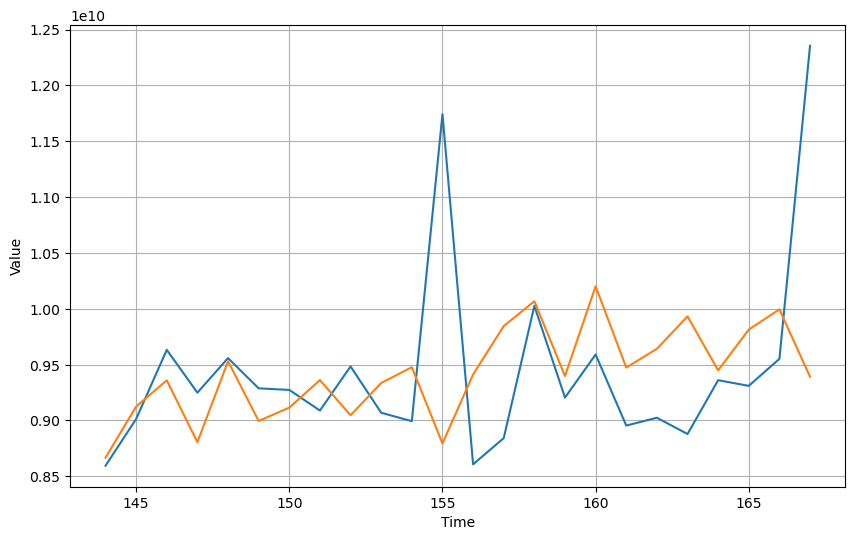

In [18]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [19]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.060386410315645594


In [20]:
# エポック数は500〜5000でMAPEはほとんど変化なし

In [21]:
%%time
# 学習率の大まかなエリアを絞り込む
# PReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = Sequential()
model.add(Dense(10, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(10))
model.add(PReLU())
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=0)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


CPU times: user 29.9 s, sys: 4.19 s, total: 34 s
Wall time: 40.9 s


(1e-08, 0.001, 0.0, 300.0)

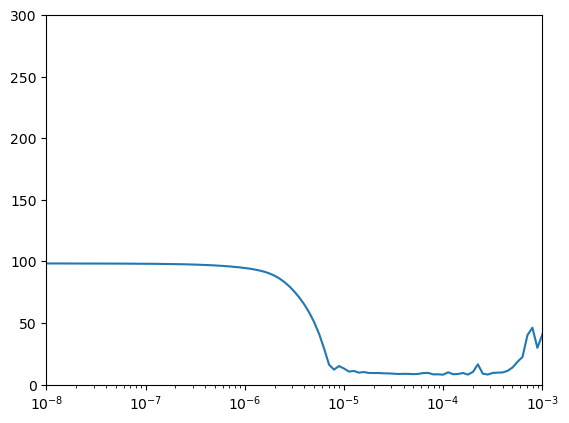

In [22]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

(1e-06, 0.0001, 0.0, 20.0)

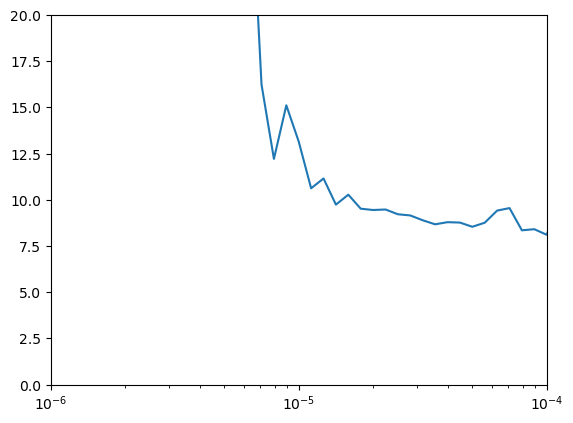

In [23]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 20])

In [24]:
# 0.1〜1*10^-5くらいの学習率でMAPEが最小になる

In [25]:
# ここまでのパラメータのまとめ
# エポック数：500〜5000にかけてMAPEは減少するが、大差ないため計算速度を考慮して500
# 学習率：0.1〜1*10^-5

In [26]:
# keras tunerでニューロンの数を試すための予備シミュレーションをする

In [27]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(5, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(5))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
4/4 [==============================] - 4s 24ms/step - loss: 81.6002
Epoch 2/500
4/4 [==============================] - 0s 53ms/step - loss: 68.9441
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 54.1920
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 38.8582
Epoch 5/500
4/4 [==============================] - 0s 7ms/step - loss: 24.7930
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 17.1147
Epoch 7/500
4/4 [==============================] - 0s 8ms/step - loss: 14.7968
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 14.5724
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 14.3832
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 14.3539
Epoch 11/500
4/4 [==============================] - 0s 10ms/step - loss: 14.3093
Epoch 12/500
4/4 [==============================] - 0s 4ms/step - loss: 14.2726
Epoch 13/500
4/4 [============================

4/4 [==============================] - 0s 4ms/step - loss: 10.6635
Epoch 104/500
4/4 [==============================] - 0s 7ms/step - loss: 10.6408
Epoch 105/500
4/4 [==============================] - 0s 5ms/step - loss: 10.5874
Epoch 106/500
4/4 [==============================] - 0s 6ms/step - loss: 10.5748
Epoch 107/500
4/4 [==============================] - 0s 4ms/step - loss: 10.5354
Epoch 108/500
4/4 [==============================] - 0s 4ms/step - loss: 10.5303
Epoch 109/500
4/4 [==============================] - 0s 3ms/step - loss: 10.5905
Epoch 110/500
4/4 [==============================] - 0s 3ms/step - loss: 10.5163
Epoch 111/500
4/4 [==============================] - 0s 9ms/step - loss: 10.4238
Epoch 112/500
4/4 [==============================] - 0s 5ms/step - loss: 10.4186
Epoch 113/500
4/4 [==============================] - 0s 23ms/step - loss: 10.4313
Epoch 114/500
4/4 [==============================] - 0s 6ms/step - loss: 10.3912
Epoch 115/500
4/4 [======================

4/4 [==============================] - 0s 3ms/step - loss: 8.2960
Epoch 206/500
4/4 [==============================] - 0s 4ms/step - loss: 8.2858
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 8.3025
Epoch 208/500
4/4 [==============================] - 0s 6ms/step - loss: 8.2605
Epoch 209/500
4/4 [==============================] - 0s 5ms/step - loss: 8.2491
Epoch 210/500
4/4 [==============================] - 0s 16ms/step - loss: 8.2221
Epoch 211/500
4/4 [==============================] - 0s 4ms/step - loss: 8.1956
Epoch 212/500
4/4 [==============================] - 0s 6ms/step - loss: 8.1763
Epoch 213/500
4/4 [==============================] - 0s 14ms/step - loss: 8.1572
Epoch 214/500
4/4 [==============================] - 0s 5ms/step - loss: 8.1456
Epoch 215/500
4/4 [==============================] - 0s 12ms/step - loss: 8.1388
Epoch 216/500
4/4 [==============================] - 0s 6ms/step - loss: 8.1077
Epoch 217/500
4/4 [==============================] 

4/4 [==============================] - 0s 4ms/step - loss: 6.9982
Epoch 308/500
4/4 [==============================] - 0s 6ms/step - loss: 7.0210
Epoch 309/500
4/4 [==============================] - 0s 6ms/step - loss: 6.9836
Epoch 310/500
4/4 [==============================] - 0s 4ms/step - loss: 6.9633
Epoch 311/500
4/4 [==============================] - 0s 4ms/step - loss: 6.9608
Epoch 312/500
4/4 [==============================] - 0s 8ms/step - loss: 6.9617
Epoch 313/500
4/4 [==============================] - 0s 5ms/step - loss: 6.9612
Epoch 314/500
4/4 [==============================] - 0s 5ms/step - loss: 7.0028
Epoch 315/500
4/4 [==============================] - 0s 4ms/step - loss: 6.9635
Epoch 316/500
4/4 [==============================] - 0s 5ms/step - loss: 6.9262
Epoch 317/500
4/4 [==============================] - 0s 3ms/step - loss: 6.9141
Epoch 318/500
4/4 [==============================] - 0s 3ms/step - loss: 6.9137
Epoch 319/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 8ms/step - loss: 6.3253
Epoch 410/500
4/4 [==============================] - 0s 3ms/step - loss: 6.3547
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 6.2873
Epoch 412/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3088
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 6.2887
Epoch 414/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3258
Epoch 415/500
4/4 [==============================] - 0s 5ms/step - loss: 6.2937
Epoch 416/500
4/4 [==============================] - 0s 5ms/step - loss: 6.2714
Epoch 417/500
4/4 [==============================] - 0s 5ms/step - loss: 6.2619
Epoch 418/500
4/4 [==============================] - 0s 5ms/step - loss: 6.2677
Epoch 419/500
4/4 [==============================] - 0s 5ms/step - loss: 6.3034
Epoch 420/500
4/4 [==============================] - 0s 5ms/step - loss: 6.2433
Epoch 421/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 107ms/step


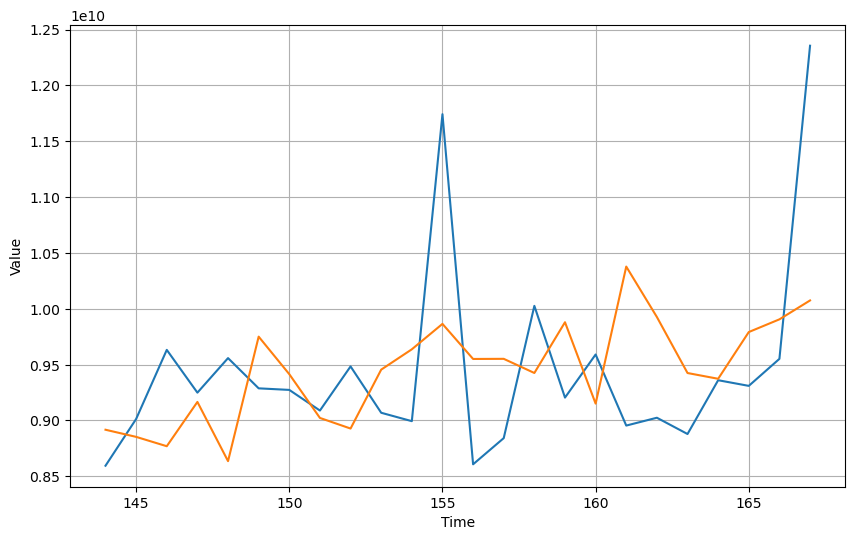

In [28]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [29]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.06747776490727235


In [30]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(15, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(15))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 4s 47ms/step - loss: 144.2459
Epoch 2/500
4/4 [==============================] - 0s 4ms/step - loss: 138.0120
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 131.6240
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 125.5075
Epoch 5/500
4/4 [==============================] - 0s 6ms/step - loss: 119.6115
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 113.9503
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 108.4540
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 103.0517
Epoch 9/500
4/4 [==============================] - 0s 8ms/step - loss: 97.9075
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 93.0165
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 88.3383
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 84.0725
Epoch 13/500
4/4 [==============================] - 

4/4 [==============================] - 0s 14ms/step - loss: 4.9277
Epoch 105/500
4/4 [==============================] - 0s 6ms/step - loss: 4.9040
Epoch 106/500
4/4 [==============================] - 0s 3ms/step - loss: 4.8905
Epoch 107/500
4/4 [==============================] - 0s 4ms/step - loss: 4.9197
Epoch 108/500
4/4 [==============================] - 0s 4ms/step - loss: 4.9020
Epoch 109/500
4/4 [==============================] - 0s 8ms/step - loss: 4.8741
Epoch 110/500
4/4 [==============================] - 0s 4ms/step - loss: 4.8806
Epoch 111/500
4/4 [==============================] - 0s 3ms/step - loss: 4.8840
Epoch 112/500
4/4 [==============================] - 0s 4ms/step - loss: 4.8742
Epoch 113/500
4/4 [==============================] - 0s 5ms/step - loss: 4.8716
Epoch 114/500
4/4 [==============================] - 0s 13ms/step - loss: 4.8664
Epoch 115/500
4/4 [==============================] - 0s 7ms/step - loss: 4.8891
Epoch 116/500
4/4 [==============================] -

4/4 [==============================] - 0s 4ms/step - loss: 4.6368
Epoch 207/500
4/4 [==============================] - 0s 8ms/step - loss: 4.6217
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 4.5949
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 4.6044
Epoch 210/500
4/4 [==============================] - 0s 4ms/step - loss: 4.6469
Epoch 211/500
4/4 [==============================] - 0s 5ms/step - loss: 4.5994
Epoch 212/500
4/4 [==============================] - 0s 5ms/step - loss: 4.5994
Epoch 213/500
4/4 [==============================] - 0s 3ms/step - loss: 4.6072
Epoch 214/500
4/4 [==============================] - 0s 29ms/step - loss: 4.5915
Epoch 215/500
4/4 [==============================] - 0s 4ms/step - loss: 4.5885
Epoch 216/500
4/4 [==============================] - 0s 7ms/step - loss: 4.5921
Epoch 217/500
4/4 [==============================] - 0s 10ms/step - loss: 4.5993
Epoch 218/500
4/4 [==============================] -

4/4 [==============================] - 0s 4ms/step - loss: 4.5036
Epoch 309/500
4/4 [==============================] - 0s 3ms/step - loss: 4.5239
Epoch 310/500
4/4 [==============================] - 0s 4ms/step - loss: 4.4873
Epoch 311/500
4/4 [==============================] - 0s 7ms/step - loss: 4.5074
Epoch 312/500
4/4 [==============================] - 0s 4ms/step - loss: 4.5100
Epoch 313/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4903
Epoch 314/500
4/4 [==============================] - 0s 4ms/step - loss: 4.5012
Epoch 315/500
4/4 [==============================] - 0s 5ms/step - loss: 4.5288
Epoch 316/500
4/4 [==============================] - 0s 38ms/step - loss: 4.4861
Epoch 317/500
4/4 [==============================] - 0s 4ms/step - loss: 4.4795
Epoch 318/500
4/4 [==============================] - 0s 4ms/step - loss: 4.4839
Epoch 319/500
4/4 [==============================] - 0s 4ms/step - loss: 4.4924
Epoch 320/500
4/4 [==============================] - 

4/4 [==============================] - 0s 5ms/step - loss: 4.4036
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4415
Epoch 412/500
4/4 [==============================] - 0s 4ms/step - loss: 4.4185
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4115
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4072
Epoch 415/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4452
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4563
Epoch 417/500
4/4 [==============================] - 0s 5ms/step - loss: 4.4662
Epoch 418/500
4/4 [==============================] - 0s 4ms/step - loss: 4.4526
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4029
Epoch 420/500
4/4 [==============================] - 0s 4ms/step - loss: 4.4055
Epoch 421/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4171
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 50ms/step


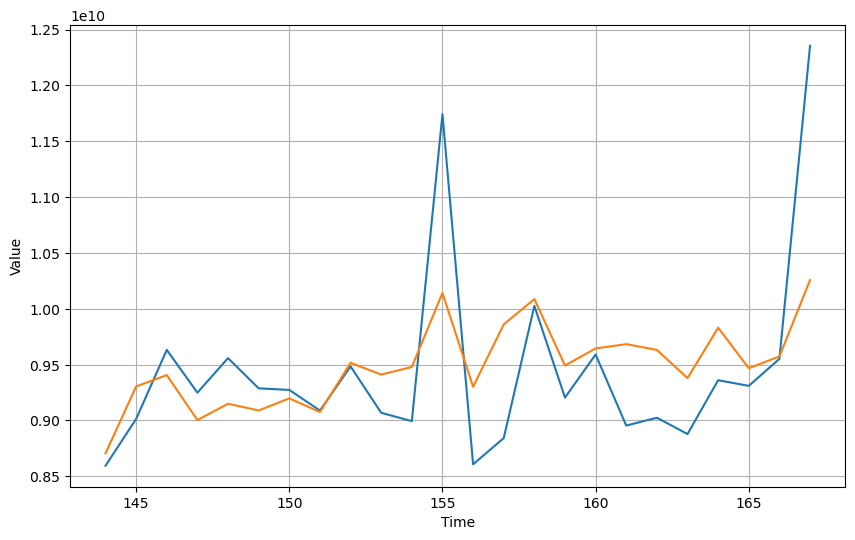

In [31]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [32]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.045135647211923036


In [33]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(20, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(20))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 4s 52ms/step - loss: 16.2891
Epoch 2/500
4/4 [==============================] - 0s 4ms/step - loss: 7.8922
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 7.1267
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 6.8458
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 6.8856
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 6.8115
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 6.7863
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 6.8330
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 6.8826
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 6.7940
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 6.9498
Epoch 12/500
4/4 [==============================] - 0s 4ms/step - loss: 6.8065
Epoch 13/500
4/4 [==============================] - 0s 4ms/step - loss:

4/4 [==============================] - 0s 10ms/step - loss: 6.1705
Epoch 105/500
4/4 [==============================] - 0s 9ms/step - loss: 6.1883
Epoch 106/500
4/4 [==============================] - 0s 7ms/step - loss: 6.1874
Epoch 107/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1616
Epoch 108/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1619
Epoch 109/500
4/4 [==============================] - 0s 6ms/step - loss: 6.1652
Epoch 110/500
4/4 [==============================] - 0s 4ms/step - loss: 6.1632
Epoch 111/500
4/4 [==============================] - 0s 4ms/step - loss: 6.1566
Epoch 112/500
4/4 [==============================] - 0s 8ms/step - loss: 6.1463
Epoch 113/500
4/4 [==============================] - 0s 4ms/step - loss: 6.1443
Epoch 114/500
4/4 [==============================] - 0s 4ms/step - loss: 6.1702
Epoch 115/500
4/4 [==============================] - 0s 4ms/step - loss: 6.1261
Epoch 116/500
4/4 [==============================] - 

4/4 [==============================] - 0s 4ms/step - loss: 5.7084
Epoch 207/500
4/4 [==============================] - 0s 4ms/step - loss: 5.7003
Epoch 208/500
4/4 [==============================] - 0s 4ms/step - loss: 5.7006
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 5.7161
Epoch 210/500
4/4 [==============================] - 0s 3ms/step - loss: 5.6748
Epoch 211/500
4/4 [==============================] - 0s 4ms/step - loss: 5.6912
Epoch 212/500
4/4 [==============================] - 0s 7ms/step - loss: 5.7120
Epoch 213/500
4/4 [==============================] - 0s 7ms/step - loss: 5.6775
Epoch 214/500
4/4 [==============================] - 0s 4ms/step - loss: 5.6681
Epoch 215/500
4/4 [==============================] - 0s 4ms/step - loss: 5.6980
Epoch 216/500
4/4 [==============================] - 0s 4ms/step - loss: 5.6639
Epoch 217/500
4/4 [==============================] - 0s 3ms/step - loss: 5.6575
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 5.3665
Epoch 309/500
4/4 [==============================] - 0s 9ms/step - loss: 5.3429
Epoch 310/500
4/4 [==============================] - 0s 4ms/step - loss: 5.3502
Epoch 311/500
4/4 [==============================] - 0s 4ms/step - loss: 5.3590
Epoch 312/500
4/4 [==============================] - 0s 4ms/step - loss: 5.4008
Epoch 313/500
4/4 [==============================] - 0s 3ms/step - loss: 5.3429
Epoch 314/500
4/4 [==============================] - 0s 4ms/step - loss: 5.3206
Epoch 315/500
4/4 [==============================] - 0s 3ms/step - loss: 5.3261
Epoch 316/500
4/4 [==============================] - 0s 3ms/step - loss: 5.3696
Epoch 317/500
4/4 [==============================] - 0s 5ms/step - loss: 5.3284
Epoch 318/500
4/4 [==============================] - 0s 4ms/step - loss: 5.3250
Epoch 319/500
4/4 [==============================] - 0s 4ms/step - loss: 5.3635
Epoch 320/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 5ms/step - loss: 5.1361
Epoch 411/500
4/4 [==============================] - 0s 4ms/step - loss: 5.1004
Epoch 412/500
4/4 [==============================] - 0s 5ms/step - loss: 5.1043
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 5.1485
Epoch 414/500
4/4 [==============================] - 0s 6ms/step - loss: 5.1126
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 5.0903
Epoch 416/500
4/4 [==============================] - 0s 6ms/step - loss: 5.0988
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 5.1465
Epoch 418/500
4/4 [==============================] - 0s 5ms/step - loss: 5.1264
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 5.0598
Epoch 420/500
4/4 [==============================] - 0s 6ms/step - loss: 5.0783
Epoch 421/500
4/4 [==============================] - 0s 4ms/step - loss: 5.0998
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 118ms/step


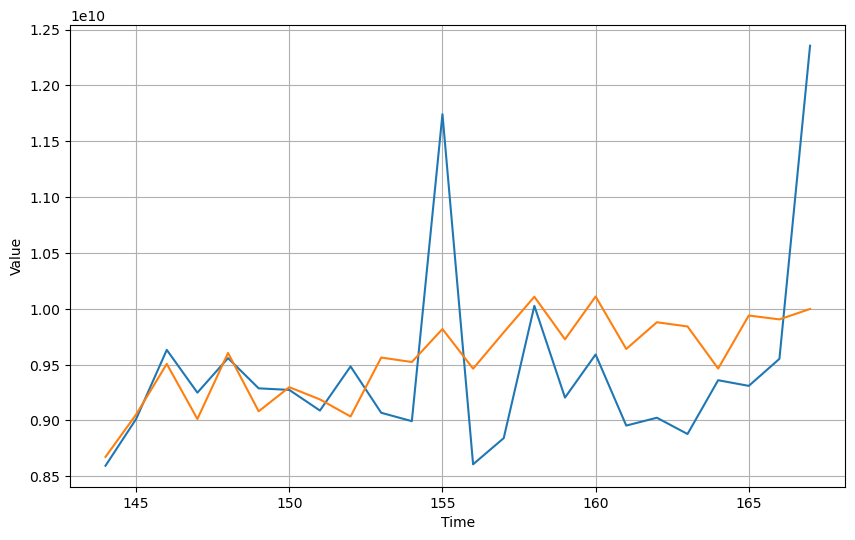

In [34]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [35]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.05537865697902113


In [36]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(25, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(25))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
4/4 [==============================] - 3s 76ms/step - loss: 161.4749
Epoch 2/500
4/4 [==============================] - 0s 19ms/step - loss: 153.9008
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 146.3780
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 139.7373
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 133.6637
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 128.0463
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 122.8699
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 118.0204
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 113.3933
Epoch 10/500
4/4 [==============================] - 0s 7ms/step - loss: 108.9754
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 104.6684
Epoch 12/500
4/4 [==============================] - 0s 4ms/step - loss: 100.4729
Epoch 13/500
4/4 [=================

4/4 [==============================] - 0s 4ms/step - loss: 5.6138
Epoch 105/500
4/4 [==============================] - 0s 4ms/step - loss: 5.6233
Epoch 106/500
4/4 [==============================] - 0s 8ms/step - loss: 5.6326
Epoch 107/500
4/4 [==============================] - 0s 4ms/step - loss: 5.5852
Epoch 108/500
4/4 [==============================] - 0s 5ms/step - loss: 5.6120
Epoch 109/500
4/4 [==============================] - 0s 5ms/step - loss: 5.6458
Epoch 110/500
4/4 [==============================] - 0s 6ms/step - loss: 5.5746
Epoch 111/500
4/4 [==============================] - 0s 5ms/step - loss: 5.5598
Epoch 112/500
4/4 [==============================] - 0s 4ms/step - loss: 5.5892
Epoch 113/500
4/4 [==============================] - 0s 5ms/step - loss: 5.5455
Epoch 114/500
4/4 [==============================] - 0s 4ms/step - loss: 5.5338
Epoch 115/500
4/4 [==============================] - 0s 5ms/step - loss: 5.5329
Epoch 116/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 5.0530
Epoch 207/500
4/4 [==============================] - 0s 13ms/step - loss: 5.0331
Epoch 208/500
4/4 [==============================] - 0s 9ms/step - loss: 5.0417
Epoch 209/500
4/4 [==============================] - 0s 7ms/step - loss: 5.0570
Epoch 210/500
4/4 [==============================] - 0s 4ms/step - loss: 5.0775
Epoch 211/500
4/4 [==============================] - 0s 3ms/step - loss: 5.0256
Epoch 212/500
4/4 [==============================] - 0s 6ms/step - loss: 5.0140
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 5.0155
Epoch 214/500
4/4 [==============================] - 0s 5ms/step - loss: 5.0646
Epoch 215/500
4/4 [==============================] - 0s 5ms/step - loss: 5.0526
Epoch 216/500
4/4 [==============================] - 0s 3ms/step - loss: 4.9981
Epoch 217/500
4/4 [==============================] - 0s 6ms/step - loss: 4.9920
Epoch 218/500
4/4 [==============================] - 

4/4 [==============================] - 0s 5ms/step - loss: 4.5902
Epoch 309/500
4/4 [==============================] - 0s 4ms/step - loss: 4.5153
Epoch 310/500
4/4 [==============================] - 0s 5ms/step - loss: 4.5339
Epoch 311/500
4/4 [==============================] - 0s 6ms/step - loss: 4.5487
Epoch 312/500
4/4 [==============================] - 0s 5ms/step - loss: 4.5403
Epoch 313/500
4/4 [==============================] - 0s 5ms/step - loss: 4.5008
Epoch 314/500
4/4 [==============================] - 0s 6ms/step - loss: 4.5076
Epoch 315/500
4/4 [==============================] - 0s 5ms/step - loss: 4.5665
Epoch 316/500
4/4 [==============================] - 0s 5ms/step - loss: 4.4941
Epoch 317/500
4/4 [==============================] - 0s 4ms/step - loss: 4.4923
Epoch 318/500
4/4 [==============================] - 0s 16ms/step - loss: 4.5272
Epoch 319/500
4/4 [==============================] - 0s 5ms/step - loss: 4.5193
Epoch 320/500
4/4 [==============================] - 

4/4 [==============================] - 0s 4ms/step - loss: 4.2310
Epoch 411/500
4/4 [==============================] - 0s 5ms/step - loss: 4.2127
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 4.2029
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 4.2038
Epoch 414/500
4/4 [==============================] - 0s 6ms/step - loss: 4.2350
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 4.2326
Epoch 416/500
4/4 [==============================] - 0s 5ms/step - loss: 4.2390
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 4.2239
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 4.2291
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 4.2589
Epoch 420/500
4/4 [==============================] - 0s 4ms/step - loss: 4.2619
Epoch 421/500
4/4 [==============================] - 0s 3ms/step - loss: 4.2501
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 136ms/step


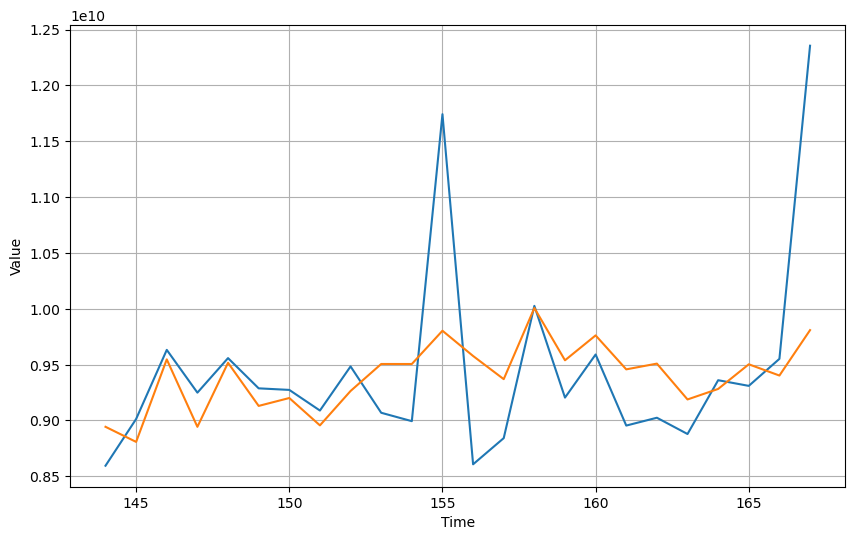

In [37]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [38]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.04443360507934257


In [39]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(30, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(30))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 2s 17ms/step - loss: 241.2745
Epoch 2/500
4/4 [==============================] - 0s 7ms/step - loss: 227.6844
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 213.4663
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 200.2602
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 187.9428
Epoch 6/500
4/4 [==============================] - 0s 6ms/step - loss: 176.4069
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 165.5999
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 155.4750
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 145.9310
Epoch 10/500
4/4 [==============================] - 0s 7ms/step - loss: 136.9237
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 128.5375
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 121.1224
Epoch 13/500
4/4 [==============================

4/4 [==============================] - 0s 5ms/step - loss: 6.4214
Epoch 105/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4137
Epoch 106/500
4/4 [==============================] - 0s 6ms/step - loss: 6.4181
Epoch 107/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4200
Epoch 108/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4169
Epoch 109/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4073
Epoch 110/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4088
Epoch 111/500
4/4 [==============================] - 0s 6ms/step - loss: 6.4034
Epoch 112/500
4/4 [==============================] - 0s 12ms/step - loss: 6.3910
Epoch 113/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4247
Epoch 114/500
4/4 [==============================] - 0s 3ms/step - loss: 6.3868
Epoch 115/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3736
Epoch 116/500
4/4 [==============================] - 

4/4 [==============================] - 0s 3ms/step - loss: 6.0888
Epoch 207/500
4/4 [==============================] - 0s 5ms/step - loss: 6.0961
Epoch 208/500
4/4 [==============================] - 0s 5ms/step - loss: 6.0851
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 6.1037
Epoch 210/500
4/4 [==============================] - 0s 15ms/step - loss: 6.1040
Epoch 211/500
4/4 [==============================] - 0s 4ms/step - loss: 6.0785
Epoch 212/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1174
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 6.0934
Epoch 214/500
4/4 [==============================] - 0s 4ms/step - loss: 6.0604
Epoch 215/500
4/4 [==============================] - 0s 9ms/step - loss: 6.0671
Epoch 216/500
4/4 [==============================] - 0s 6ms/step - loss: 6.0625
Epoch 217/500
4/4 [==============================] - 0s 3ms/step - loss: 6.0555
Epoch 218/500
4/4 [==============================] - 

4/4 [==============================] - 0s 3ms/step - loss: 5.8106
Epoch 309/500
4/4 [==============================] - 0s 4ms/step - loss: 5.7802
Epoch 310/500
4/4 [==============================] - 0s 2ms/step - loss: 5.8001
Epoch 311/500
4/4 [==============================] - 0s 3ms/step - loss: 5.7864
Epoch 312/500
4/4 [==============================] - 0s 4ms/step - loss: 5.8072
Epoch 313/500
4/4 [==============================] - 0s 4ms/step - loss: 5.7918
Epoch 314/500
4/4 [==============================] - 0s 4ms/step - loss: 5.7882
Epoch 315/500
4/4 [==============================] - 0s 3ms/step - loss: 5.7700
Epoch 316/500
4/4 [==============================] - 0s 4ms/step - loss: 5.7887
Epoch 317/500
4/4 [==============================] - 0s 4ms/step - loss: 5.7615
Epoch 318/500
4/4 [==============================] - 0s 3ms/step - loss: 5.7588
Epoch 319/500
4/4 [==============================] - 0s 5ms/step - loss: 5.7792
Epoch 320/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 5ms/step - loss: 5.5208
Epoch 411/500
4/4 [==============================] - 0s 4ms/step - loss: 5.5249
Epoch 412/500
4/4 [==============================] - 0s 4ms/step - loss: 5.5337
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 5.5274
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 5.5351
Epoch 415/500
4/4 [==============================] - 0s 8ms/step - loss: 5.5404
Epoch 416/500
4/4 [==============================] - 0s 4ms/step - loss: 5.5146
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 5.5015
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 5.4972
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 5.4954
Epoch 420/500
4/4 [==============================] - 0s 4ms/step - loss: 5.4972
Epoch 421/500
4/4 [==============================] - 0s 4ms/step - loss: 5.5020
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 18ms/step


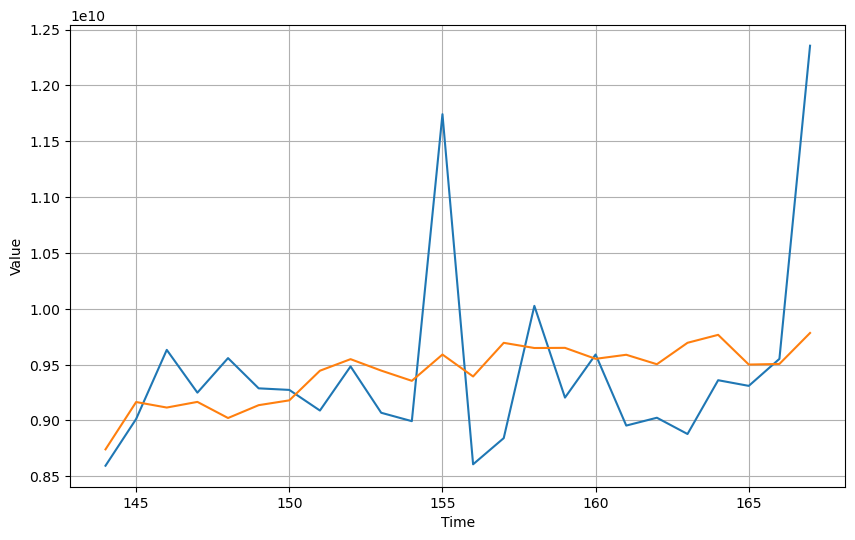

In [40]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [41]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.05252830168156705


In [42]:
%%time
# PReLU・エポック数500
# split_by_144/PReLU_500_1

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):

  model = Sequential()
  model.add(Dense(units=hp.Int('units1', min_value=2, max_value=30, step=4), input_shape=[window_size]))
  model.add(PReLU())
  model.add(Dense(units=hp.Int('units2', min_value=2, max_value=30, step=4)))
  model.add(PReLU())
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9]), lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=60, executions_per_trial=3, directory='split_by_144', project_name='PReLU_500_1')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=0)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Search space summary
Default search space size: 3
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 30, 'step': 4, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 30, 'step': 4, 'sampling': None}
momentum (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.5, 0.7, 0.9], 'ordered': True}
INFO:tensorflow:Oracle triggered exit
CPU times: user 1h 15min 49s, sys: 10min 16s, total: 1h 26min 5s
Wall time: 1h 45min 50s


In [43]:
tuner.results_summary()

Results summary
Results in split_by_144/PReLU_500_1
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 22
units2: 30
momentum: 0.9
Score: 4.585771242777507
Trial summary
Hyperparameters:
units1: 18
units2: 22
momentum: 0.5
Score: 4.607916037241618
Trial summary
Hyperparameters:
units1: 30
units2: 26
momentum: 0.7
Score: 4.6570868492126465
Trial summary
Hyperparameters:
units1: 30
units2: 26
momentum: 0.9
Score: 4.660334746042888
Trial summary
Hyperparameters:
units1: 26
units2: 26
momentum: 0.9
Score: 4.787548700968425
Trial summary
Hyperparameters:
units1: 30
units2: 22
momentum: 0.5
Score: 4.950428644816081
Trial summary
Hyperparameters:
units1: 30
units2: 22
momentum: 0.9
Score: 4.993914445241292
Trial summary
Hyperparameters:
units1: 22
units2: 26
momentum: 0.5
Score: 4.997230211893718
Trial summary
Hyperparameters:
units1: 22
units2: 18
momentum: 0.9
Score: 5.055163860321045
Trial summary
Hyperparameters:
units1: 14
units2: 22
momentum: 0.5
Score: 5.2335740725199384


In [44]:
%%time
# PReLU
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Dense(22, input_shape=[window_size]))
model.add(PReLU())
model.add(Dense(30))
model.add(PReLU())
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))
model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 36ms/step - loss: 222.2558
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 178.7101
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 109.6260
Epoch 4/500
4/4 [==============================] - 0s 7ms/step - loss: 33.8531
Epoch 5/500
4/4 [==============================] - 0s 12ms/step - loss: 33.1921
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 44.5060
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 19.7161
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 16.6466
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 19.4885
Epoch 10/500
4/4 [==============================] - 0s 7ms/step - loss: 9.1291
Epoch 11/500
4/4 [==============================] - 0s 3ms/step - loss: 14.0126
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7359
Epoch 13/500
4/4 [============================

4/4 [==============================] - 0s 3ms/step - loss: 4.3999
Epoch 105/500
4/4 [==============================] - 0s 3ms/step - loss: 4.4196
Epoch 106/500
4/4 [==============================] - 0s 4ms/step - loss: 4.5288
Epoch 107/500
4/4 [==============================] - 0s 4ms/step - loss: 4.3924
Epoch 108/500
4/4 [==============================] - 0s 2ms/step - loss: 4.5765
Epoch 109/500
4/4 [==============================] - 0s 2ms/step - loss: 4.3612
Epoch 110/500
4/4 [==============================] - 0s 3ms/step - loss: 4.3641
Epoch 111/500
4/4 [==============================] - 0s 3ms/step - loss: 4.3879
Epoch 112/500
4/4 [==============================] - 0s 2ms/step - loss: 4.3552
Epoch 113/500
4/4 [==============================] - 0s 3ms/step - loss: 4.3395
Epoch 114/500
4/4 [==============================] - 0s 3ms/step - loss: 4.3775
Epoch 115/500
4/4 [==============================] - 0s 2ms/step - loss: 4.3818
Epoch 116/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 4.0546
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 4.0436
Epoch 208/500
4/4 [==============================] - 0s 3ms/step - loss: 4.0880
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 4.1687
Epoch 210/500
4/4 [==============================] - 0s 4ms/step - loss: 4.1602
Epoch 211/500
4/4 [==============================] - 0s 3ms/step - loss: 4.0180
Epoch 212/500
4/4 [==============================] - 0s 3ms/step - loss: 4.0342
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 4.0909
Epoch 214/500
4/4 [==============================] - 0s 8ms/step - loss: 4.1478
Epoch 215/500
4/4 [==============================] - 0s 5ms/step - loss: 4.1587
Epoch 216/500
4/4 [==============================] - 0s 3ms/step - loss: 4.1074
Epoch 217/500
4/4 [==============================] - 0s 4ms/step - loss: 4.1304
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 3.9880
Epoch 309/500
4/4 [==============================] - 0s 4ms/step - loss: 3.8964
Epoch 310/500
4/4 [==============================] - 0s 5ms/step - loss: 3.8139
Epoch 311/500
4/4 [==============================] - 0s 4ms/step - loss: 3.9478
Epoch 312/500
4/4 [==============================] - 0s 12ms/step - loss: 3.8136
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 3.8647
Epoch 314/500
4/4 [==============================] - 0s 3ms/step - loss: 3.8194
Epoch 315/500
4/4 [==============================] - 0s 3ms/step - loss: 3.8399
Epoch 316/500
4/4 [==============================] - 0s 3ms/step - loss: 3.7199
Epoch 317/500
4/4 [==============================] - 0s 4ms/step - loss: 3.7534
Epoch 318/500
4/4 [==============================] - 0s 3ms/step - loss: 3.7155
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 3.7350
Epoch 320/500
4/4 [==============================] - 

4/4 [==============================] - 0s 4ms/step - loss: 3.6265
Epoch 411/500
4/4 [==============================] - 0s 3ms/step - loss: 3.6280
Epoch 412/500
4/4 [==============================] - 0s 4ms/step - loss: 3.5452
Epoch 413/500
4/4 [==============================] - 0s 2ms/step - loss: 3.6019
Epoch 414/500
4/4 [==============================] - 0s 3ms/step - loss: 3.6076
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 3.5779
Epoch 416/500
4/4 [==============================] - 0s 2ms/step - loss: 3.6023
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 3.8067
Epoch 418/500
4/4 [==============================] - 0s 3ms/step - loss: 3.5474
Epoch 419/500
4/4 [==============================] - 0s 2ms/step - loss: 3.5990
Epoch 420/500
4/4 [==============================] - 0s 3ms/step - loss: 3.4574
Epoch 421/500
4/4 [==============================] - 0s 2ms/step - loss: 3.4785
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 25ms/step


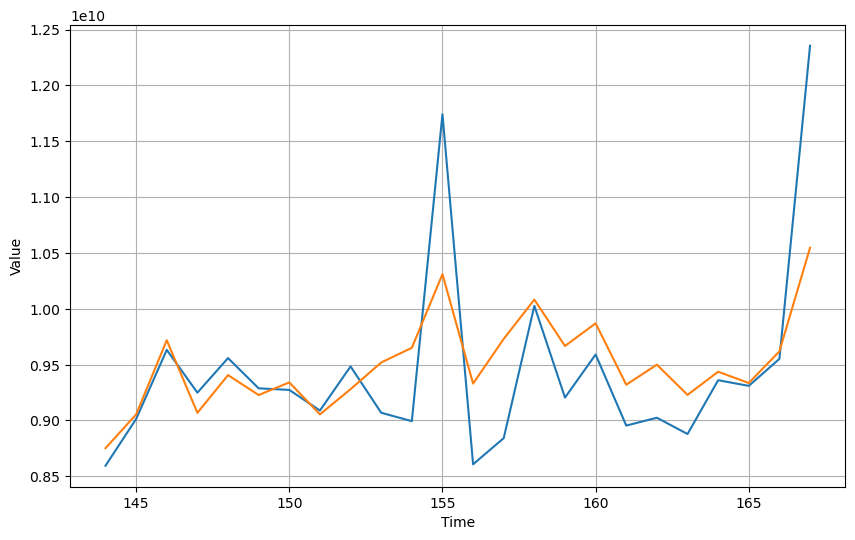

In [47]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [48]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.03822804417271009


In [51]:
dnn_forecast = forecast
dnn_train_pred = train_pred
dnn_test_pred = test_pred

In [64]:
# 一旦SARIMAXとDNNで考察する

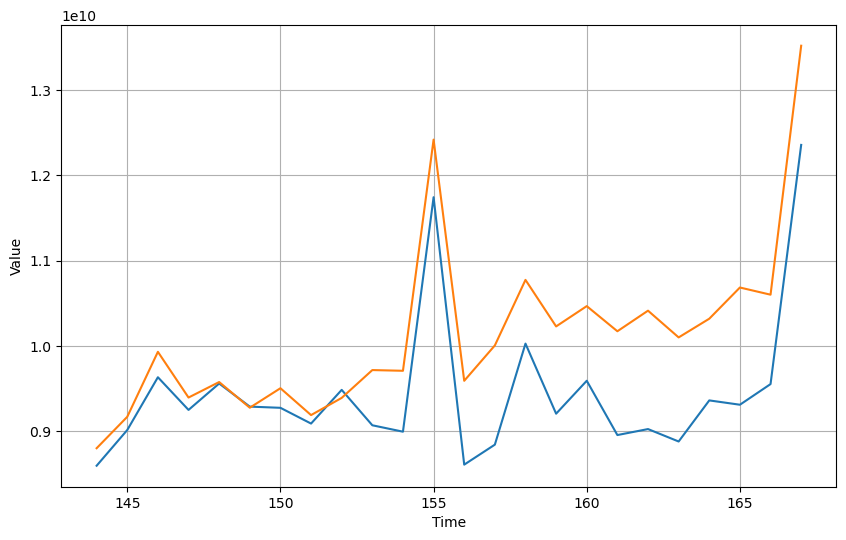

In [65]:
# SARIMAX
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, sarimax_test_pred)

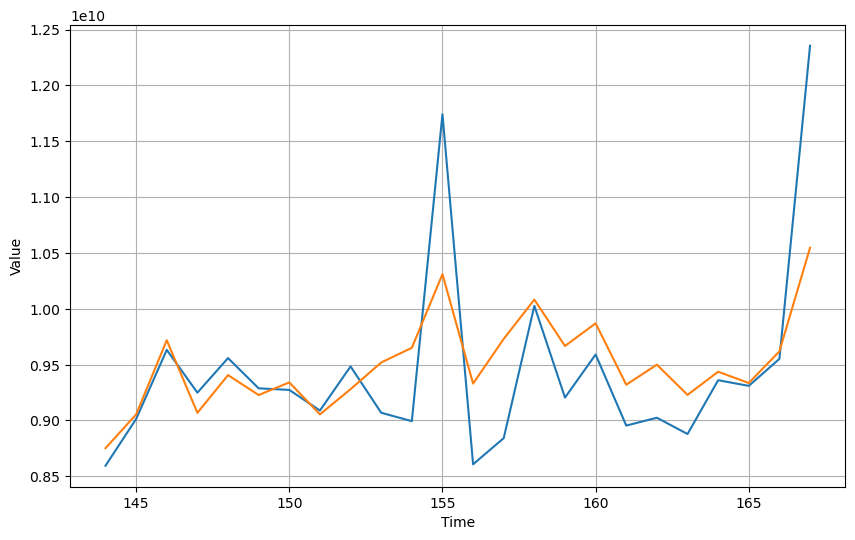

In [66]:
# DNN
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_test_pred)

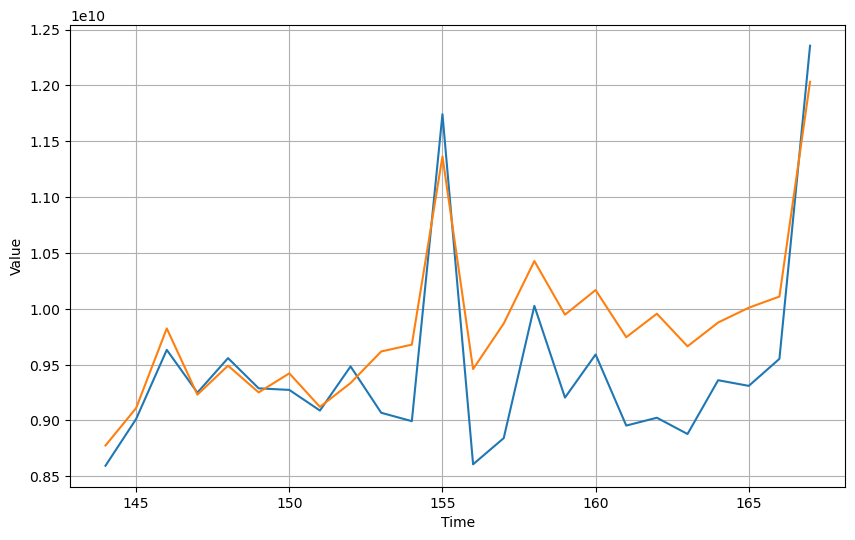

In [67]:
# SARIMAX DNN average
dnn_sarimax = np.stack((dnn_test_pred, sarimax_test_pred))
dnn_sarimax_ave_test_pred = np.mean(dnn_sarimax, axis=0)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_sarimax_ave_test_pred)

In [68]:
# MAPE
print('DNN MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN SARIMAX AVERAGE MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred))

DNN MAPE:
0.03822804417271009
SARIMAX MAPE:
0.07283870396613272
DNN SARIMAX AVERAGE MAPE:
0.04833007818940629


In [69]:
# SARIMAXとDNNの平均は、SARIMAX単体からは改善したが、DNN単体からは悪化した。
# SARIMAXは12月の売上の上昇などの季節性トレンドを把握できているが、平時は微妙。
# 一方でDNNは平時の予想ができているが、季節性トレンドまでは把握できず。
# (DNNはエポック数を極端に増加させれば、季節性を捉えられることは予備実験済み。)
# 変動が小さい時はDNNに重みを、変動が大きい時はSARIMAXに重みを大きくつければ、予測精度はより向上すると考えられる。

In [87]:
# 月ごとの平均の先月比売上変動率
# average_monthly_volatility：[[1月の先月売上比],[2月の先月売上比],[3月の先月売上比], ....]

volatility_list = []
for time in range(len(x_train)-24):
    volatility_list.append(x_train[time+12] / x_train[time+11])

variable_ratio = np.array(volatility_list).reshape(10, -1).T
average_monthly_volatility = np.mean(variable_ratio, axis=-1)
average_monthly_volatility

array([0.7412612 , 1.03812377, 1.08249894, 0.94119942, 1.02970466,
       0.96578734, 0.99103197, 0.96449074, 1.02004389, 1.04920485,
       1.03033754, 1.30698799])

In [88]:
# (変動率 - 1)の絶対値    (先月に比べて変動のしやすさのスコア)
a = np.abs(average_monthly_volatility-1)
a

array([0.2587388 , 0.03812377, 0.08249894, 0.05880058, 0.02970466,
       0.03421266, 0.00896803, 0.03550926, 0.02004389, 0.04920485,
       0.03033754, 0.30698799])

In [92]:
# 変動のし易さの偏差値/100
# 0.5未満のとき、他の月と比べて変動しにくい
# 0.5以上のとき、他の月と比べて変動しやすい
b = np.array((50.0+10.0*(a-np.average(a))/np.std(a))/100)
b = np.ravel(np.repeat(b[None, :], 2, axis=0))                # 予想が2年分あるため
b

array([0.69229988, 0.45570429, 0.50329383, 0.47787885, 0.44667533,
       0.45150987, 0.42443662, 0.45290039, 0.43631477, 0.46758805,
       0.44735406, 0.74404406, 0.69229988, 0.45570429, 0.50329383,
       0.47787885, 0.44667533, 0.45150987, 0.42443662, 0.45290039,
       0.43631477, 0.46758805, 0.44735406, 0.74404406])

In [93]:
c = np.array(1-b)
c

array([0.30770012, 0.54429571, 0.49670617, 0.52212115, 0.55332467,
       0.54849013, 0.57556338, 0.54709961, 0.56368523, 0.53241195,
       0.55264594, 0.25595594, 0.30770012, 0.54429571, 0.49670617,
       0.52212115, 0.55332467, 0.54849013, 0.57556338, 0.54709961,
       0.56368523, 0.53241195, 0.55264594, 0.25595594])

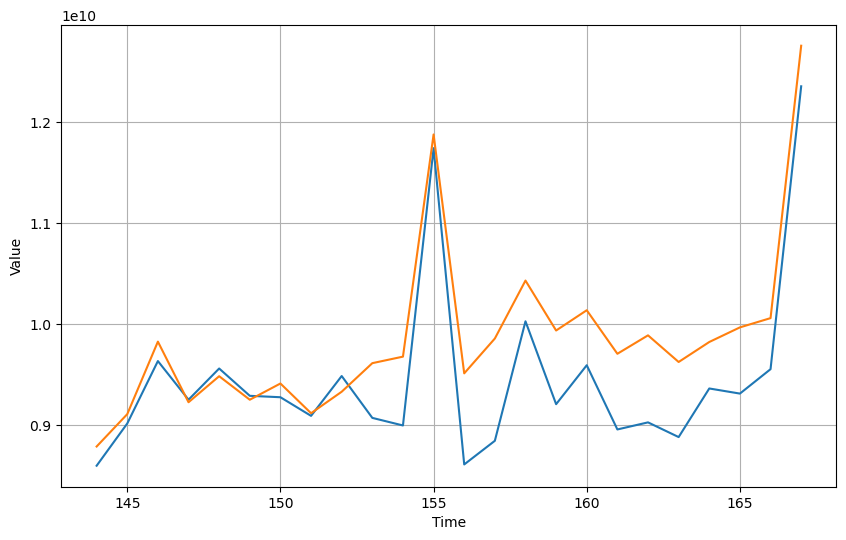

In [112]:
# b*SARIMAX+c*DNN

dnn_deviation_weighted_test_pred = np.array(b*sarimax_test_pred+c*dnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_deviation_weighted_test_pred)

In [113]:
# MAPE
print('DNN MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred))
print('DNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_deviation_weighted_test_pred))

DNN MAPE:
0.03822804417271009
SARIMAX MAPE:
0.07283870396613272
DNN SARIMAX Average MAPE:
0.04833007818940629
DNN SARIMAX Deviation weighted MAPE:
0.04637091414658961


In [96]:
# 先月との変動率をもとに重みをつけた場合、MAPEを改善させることができた。

In [97]:
# 移動平均との差から変動の大きさをスコア化する

In [170]:
# 移動平均(12時点から132時点まで)
moving_average = np.array(df_train.Sales.rolling(24).mean().shift(-12).values[12:132])

# 月ごとの実測値と移動平均値との差の平均
diff_moving_average = (x_train[12:132] - moving_average).reshape(10, -1).T
d = np.mean(diff_moving_average, axis=-1)
d

array([-2.84487327e+08, -1.26992912e+08,  2.95636259e+08, -1.03520456e+08,
        2.75762529e+07, -2.10325642e+08, -2.82209336e+08, -5.11521299e+08,
       -4.39233875e+08, -2.12521471e+08, -8.79013859e+07,  1.65480853e+09])

In [171]:
# (実測値と移動平均値の差)の絶対値の偏差値
e = np.array((50.0+10.0*(d-np.average(d))/np.std(d))/100)
e = np.ravel(np.repeat(e[None, :], 2, axis=0))                # 予想が2年分あるため
e

array([0.45205754, 0.48097664, 0.55857975, 0.48528665, 0.50935861,
       0.4656751 , 0.45247583, 0.4103696 , 0.42364301, 0.4652719 ,
       0.48815462, 0.80815075, 0.45205754, 0.48097664, 0.55857975,
       0.48528665, 0.50935861, 0.4656751 , 0.45247583, 0.4103696 ,
       0.42364301, 0.4652719 , 0.48815462, 0.80815075])

In [172]:
f = np.array(1-e)
f

array([0.54794246, 0.51902336, 0.44142025, 0.51471335, 0.49064139,
       0.5343249 , 0.54752417, 0.5896304 , 0.57635699, 0.5347281 ,
       0.51184538, 0.19184925, 0.54794246, 0.51902336, 0.44142025,
       0.51471335, 0.49064139, 0.5343249 , 0.54752417, 0.5896304 ,
       0.57635699, 0.5347281 , 0.51184538, 0.19184925])

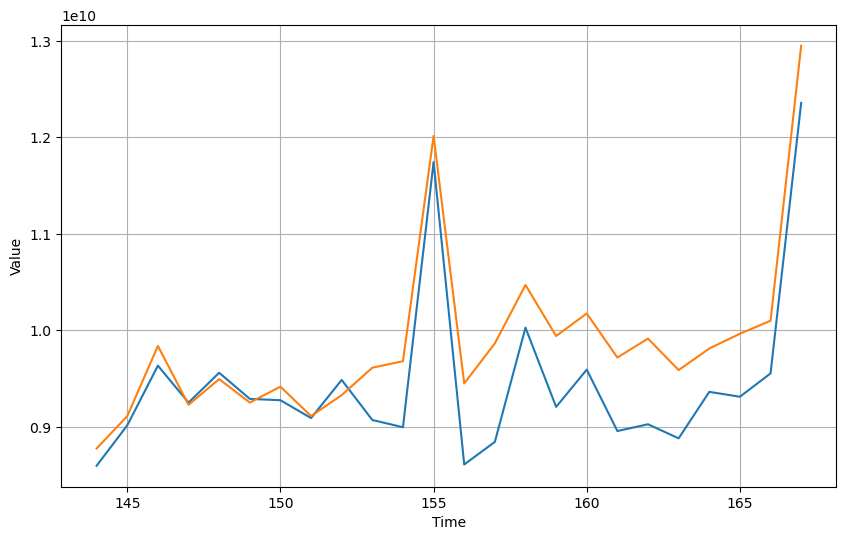

In [173]:
# e*SARIMAX+f*DNN
dnn_diff_moving_average_test_pred = np.array(e*sarimax_test_pred+f*dnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_diff_moving_average_test_pred)

In [174]:
# MAPE
print('DNN MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred))
print('DNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_deviation_weighted_test_pred))
print('DNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_diff_moving_average_test_pred))

DNN MAPE:
0.03822804417271009
SARIMAX MAPE:
0.07283870396613272
DNN SARIMAX Average MAPE:
0.04833007818940629
DNN SARIMAX Deviation weighted MAPE:
0.04637091414658961
DNN SARIMAX Diff Moving Average MAPE:
0.04763179586027466


In [105]:
# DNNでは季節性トレンドの変動を捉えられないため、そこをSARIMAXで補いたい

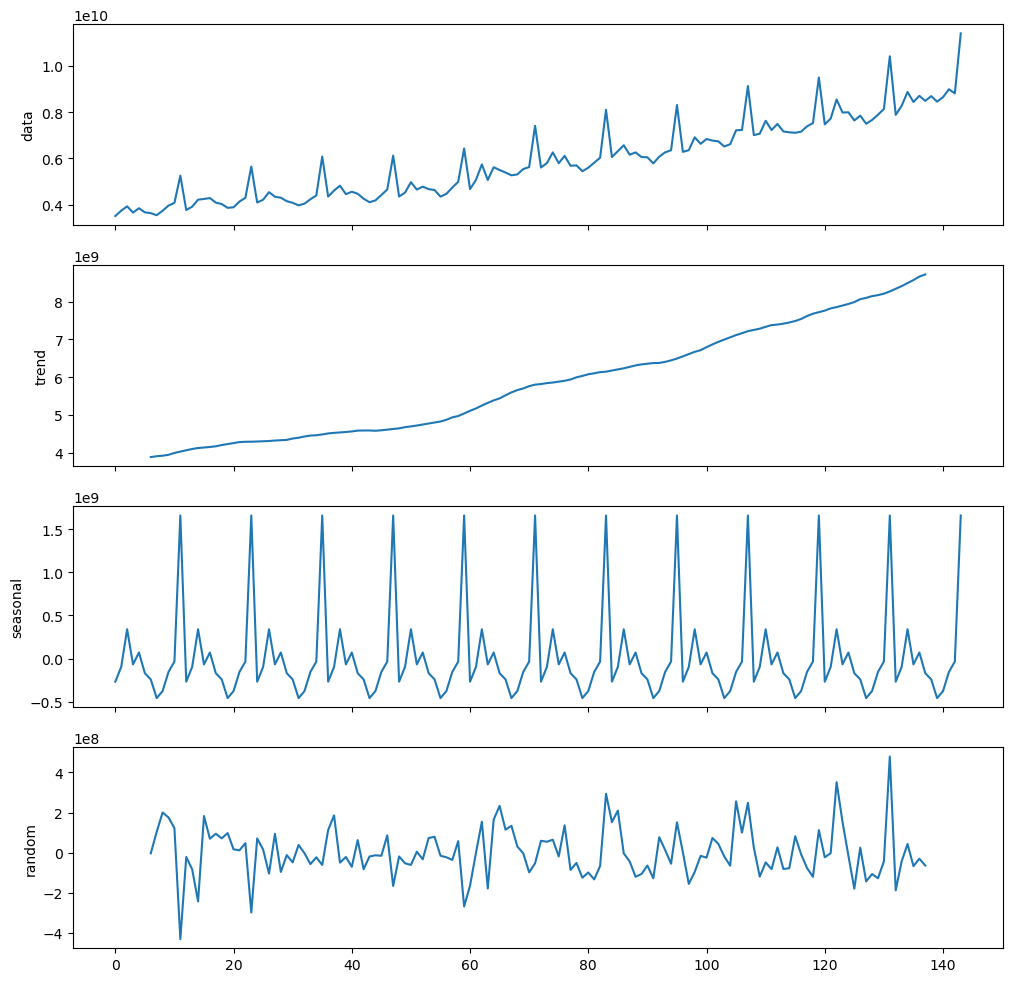

In [106]:
component_decomposition = arima.decompose(df_train.Sales.values,'additive',m=12)
utils.decomposed_plot(component_decomposition, figure_kwargs = {'figsize': (12, 12)})

In [175]:
# 季節性トレンドの絶対値
seasonal = np.array(component_decomposition.seasonal[12:24])
seasonal

array([-2.68774781e+08, -9.72144905e+07,  3.39825010e+08, -6.76103800e+07,
        7.01359724e+07, -1.70097311e+08, -2.41874314e+08, -4.59135800e+08,
       -3.77330222e+08, -1.55311910e+08, -3.52207692e+07,  1.66066626e+09])

In [176]:
# (実測値と移動平均値の差)の絶対値の偏差値
g = np.array((50.0+10.0*(seasonal-np.average(seasonal))/np.std(seasonal))/100)
g = np.ravel(np.repeat(g[None, :], 2, axis=0))                # 予想が2年分あるため
g

array([0.44661831, 0.47872078, 0.56049989, 0.48426032, 0.5100355 ,
       0.4650829 , 0.45165194, 0.41099783, 0.42630535, 0.46784955,
       0.49032108, 0.80765654, 0.44661831, 0.47872078, 0.56049989,
       0.48426032, 0.5100355 , 0.4650829 , 0.45165194, 0.41099783,
       0.42630535, 0.46784955, 0.49032108, 0.80765654])

In [177]:
h = np.array(1-g)
h

array([0.55338169, 0.52127922, 0.43950011, 0.51573968, 0.4899645 ,
       0.5349171 , 0.54834806, 0.58900217, 0.57369465, 0.53215045,
       0.50967892, 0.19234346, 0.55338169, 0.52127922, 0.43950011,
       0.51573968, 0.4899645 , 0.5349171 , 0.54834806, 0.58900217,
       0.57369465, 0.53215045, 0.50967892, 0.19234346])

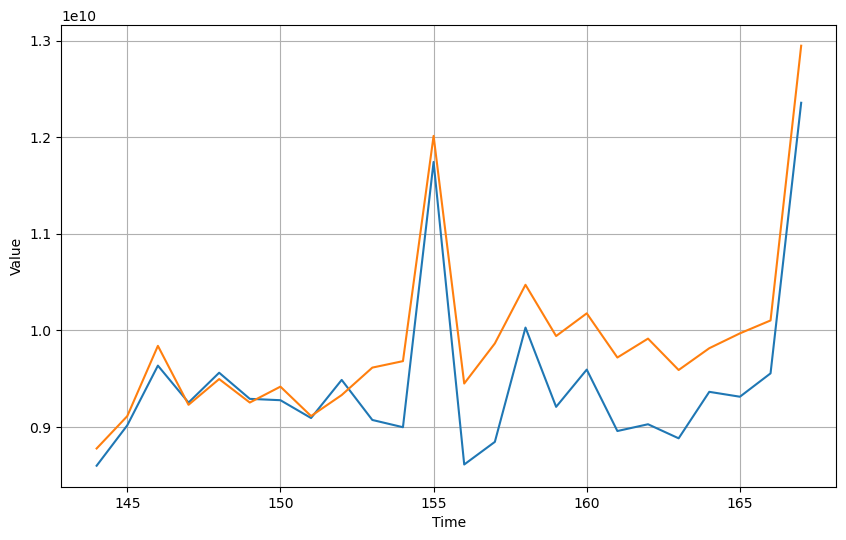

In [178]:
# g*SARIMAX+h*DNN
dnn_seasonal_trend_test_pred = np.array(g*sarimax_test_pred+h*dnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_seasonal_trend_test_pred)

In [179]:
# MAPE
print('DNN MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred))
print('DNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_deviation_weighted_test_pred))
print('DNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_diff_moving_average_test_pred))
print('DNN SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_seasonal_trend_test_pred))

DNN MAPE:
0.03822804417271009
SARIMAX MAPE:
0.07283870396613272
DNN SARIMAX Average MAPE:
0.04833007818940629
DNN SARIMAX Deviation weighted MAPE:
0.04637091414658961
DNN SARIMAX Diff Moving Average MAPE:
0.04763179586027466
DNN SARIMAX Seasonal Trend MAPE:
0.047651909455738974


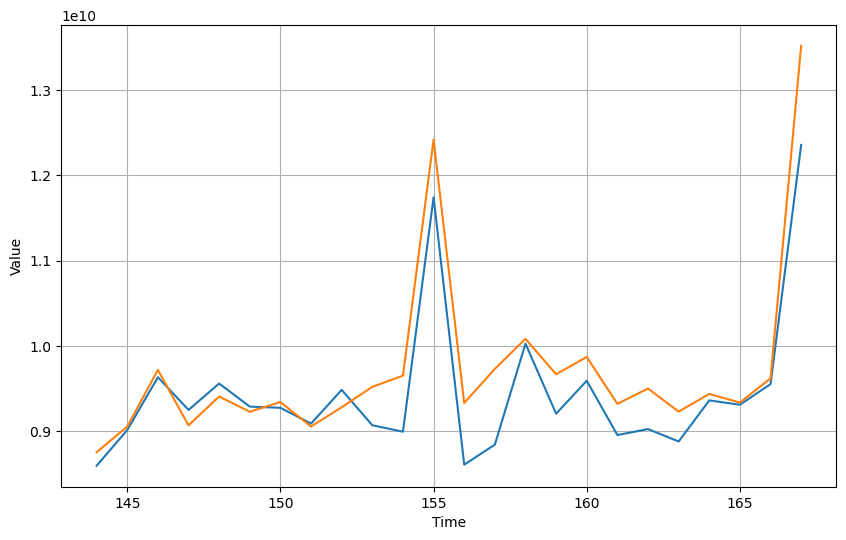

In [180]:
# 単純に12月だけSARIMAX、それ以外をDNNとしてやってみる

# sarimaxの12月の各値
sarimax_test_pred_12 = np.array(sarimax_test_pred).reshape(2,12)[:,11].reshape(2,1)

# DNNの12月以外の各値
dnn_test_pred_1_11 = dnn_test_pred.reshape(2,12)[:, 0:11]

# 1月-11月がDNN , 12月がSARIMAX
dnn_1_11_sarimax_12_test_pred =np.ravel(np.append(dnn_test_pred_1_11, sarimax_test_pred_12, axis=1))

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_1_11_sarimax_12_test_pred)

In [181]:
# MAPE
print('DNN MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('DNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_sarimax_ave_test_pred))
print('DNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_deviation_weighted_test_pred))
print('DNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_diff_moving_average_test_pred))
print('DNN SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_seasonal_trend_test_pred))
print('DNN 1-11 SARIMAX 12 MAPE:')
print(mean_absolute_percentage_error(x_valid, dnn_1_11_sarimax_12_test_pred))

DNN MAPE:
0.03822804417271009
SARIMAX MAPE:
0.07283870396613272
DNN SARIMAX Average MAPE:
0.04833007818940629
DNN SARIMAX Deviation weighted MAPE:
0.04637091414658961
DNN SARIMAX Diff Moving Average MAPE:
0.04763179586027466
DNN SARIMAX Seasonal Trend MAPE:
0.047651909455738974
DNN 1-11 SARIMAX 12 MAPE:
0.03336168080249077


In [132]:
# 12月だけSARIMAXにするのは恣意的だと思うが、一番良いMAPEを得ることができた。

In [70]:
# CNN

In [71]:
# 畳み込みのコード化

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [73]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [72]:
# filters・・・学習させたいフィルタの数。この数のフィルタを生成し、データに会うように時間をかけて学習する。
# kernel_size・・・フィルタの大きさ。
# strides・・・フィルタがリストをスキャンする際のステップの大きさ。通常は1。
# padding・・・リストのどちらの端からデータをドロップするかを決定する。
# activatoin・・・活性化関数。reluは層から出てくる負の値を効果的に排除することを意味する。
# input_shape・・・ネットワークに渡す入力データの形状。ここでは最初の層のため指定する必要がある。

from tensorflow.keras.layers import Conv1D

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.5))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 2s 244ms/step - loss: 96.7460
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 86.3168
Epoch 3/500
4/4 [==============================] - 0s 28ms/step - loss: 74.5300
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 61.2686
Epoch 5/500
4/4 [==============================] - 0s 7ms/step - loss: 42.5265
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 18.5054
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 13.5610
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 13.0495
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 12.9796
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 13.0102
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 12.8569
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 12.8298
Epoch 13/500
4/4 [==============================] - 0s 5m

4/4 [==============================] - 0s 6ms/step - loss: 9.7712
Epoch 104/500
4/4 [==============================] - 0s 4ms/step - loss: 9.7048
Epoch 105/500
4/4 [==============================] - 0s 8ms/step - loss: 9.6970
Epoch 106/500
4/4 [==============================] - 0s 4ms/step - loss: 9.6965
Epoch 107/500
4/4 [==============================] - 0s 10ms/step - loss: 9.6569
Epoch 108/500
4/4 [==============================] - 0s 6ms/step - loss: 9.6362
Epoch 109/500
4/4 [==============================] - 0s 3ms/step - loss: 9.6396
Epoch 110/500
4/4 [==============================] - 0s 4ms/step - loss: 9.6648
Epoch 111/500
4/4 [==============================] - 0s 4ms/step - loss: 9.6086
Epoch 112/500
4/4 [==============================] - 0s 6ms/step - loss: 9.6000
Epoch 113/500
4/4 [==============================] - 0s 4ms/step - loss: 9.5621
Epoch 114/500
4/4 [==============================] - 0s 5ms/step - loss: 9.5851
Epoch 115/500
4/4 [==============================] - 

4/4 [==============================] - 0s 3ms/step - loss: 8.9714
Epoch 206/500
4/4 [==============================] - 0s 4ms/step - loss: 8.9228
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 8.9399
Epoch 208/500
4/4 [==============================] - 0s 5ms/step - loss: 8.9428
Epoch 209/500
4/4 [==============================] - 0s 5ms/step - loss: 8.9060
Epoch 210/500
4/4 [==============================] - 0s 4ms/step - loss: 8.9393
Epoch 211/500
4/4 [==============================] - 0s 6ms/step - loss: 8.9285
Epoch 212/500
4/4 [==============================] - 0s 6ms/step - loss: 8.9194
Epoch 213/500
4/4 [==============================] - 0s 4ms/step - loss: 8.9250
Epoch 214/500
4/4 [==============================] - 0s 4ms/step - loss: 8.9416
Epoch 215/500
4/4 [==============================] - 0s 3ms/step - loss: 8.8933
Epoch 216/500
4/4 [==============================] - 0s 3ms/step - loss: 8.8752
Epoch 217/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 8.7270
Epoch 308/500
4/4 [==============================] - 0s 3ms/step - loss: 8.7475
Epoch 309/500
4/4 [==============================] - 0s 3ms/step - loss: 8.7733
Epoch 310/500
4/4 [==============================] - 0s 3ms/step - loss: 8.7390
Epoch 311/500
4/4 [==============================] - 0s 4ms/step - loss: 8.7150
Epoch 312/500
4/4 [==============================] - 0s 3ms/step - loss: 8.8071
Epoch 313/500
4/4 [==============================] - 0s 3ms/step - loss: 8.6990
Epoch 314/500
4/4 [==============================] - 0s 4ms/step - loss: 8.8681
Epoch 315/500
4/4 [==============================] - 0s 3ms/step - loss: 8.8399
Epoch 316/500
4/4 [==============================] - 0s 4ms/step - loss: 8.7278
Epoch 317/500
4/4 [==============================] - 0s 5ms/step - loss: 8.7420
Epoch 318/500
4/4 [==============================] - 0s 4ms/step - loss: 8.7247
Epoch 319/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 8.6055
Epoch 410/500
4/4 [==============================] - 0s 3ms/step - loss: 8.5501
Epoch 411/500
4/4 [==============================] - 0s 2ms/step - loss: 8.6537
Epoch 412/500
4/4 [==============================] - 0s 2ms/step - loss: 8.5031
Epoch 413/500
4/4 [==============================] - 0s 4ms/step - loss: 8.5017
Epoch 414/500
4/4 [==============================] - 0s 2ms/step - loss: 8.6546
Epoch 415/500
4/4 [==============================] - 0s 3ms/step - loss: 8.5895
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 8.4970
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 8.5253
Epoch 418/500
4/4 [==============================] - 0s 2ms/step - loss: 8.4971
Epoch 419/500
4/4 [==============================] - 0s 2ms/step - loss: 8.5240
Epoch 420/500
4/4 [==============================] - 0s 2ms/step - loss: 8.5025
Epoch 421/500
4/4 [==============================] - 0

5/5 [==============================] - 0s 8ms/step


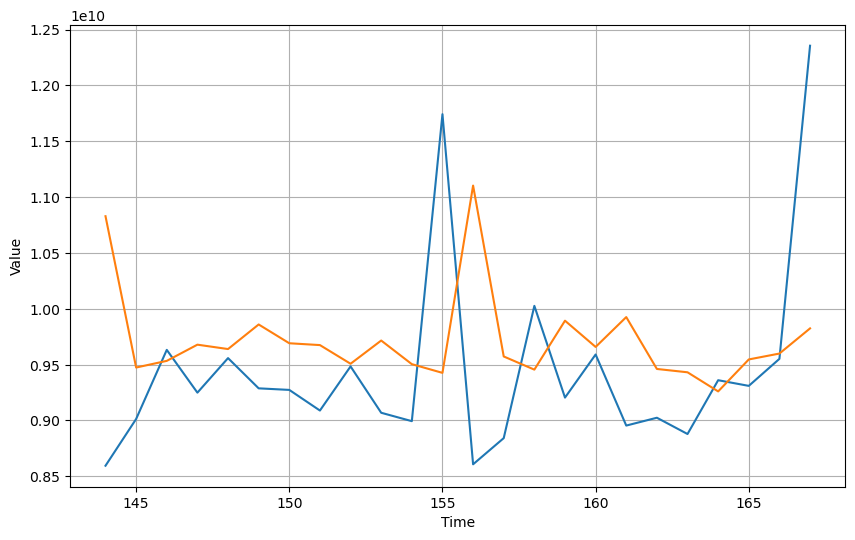

In [74]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [76]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, results))

MAPE:
0.07715254661960605


In [75]:
# 学習率の大まかなエリアを絞り込む
# ReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=1)

Epoch 1/500
4/4 [==============================] - 3s 13ms/step - loss: 107.3876 - lr: 1.0000e-08
Epoch 2/500
4/4 [==============================] - 0s 6ms/step - loss: 107.3868 - lr: 1.1220e-08
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 107.3851 - lr: 1.2589e-08
Epoch 4/500
4/4 [==============================] - 0s 7ms/step - loss: 107.3829 - lr: 1.4125e-08
Epoch 5/500
4/4 [==============================] - 0s 8ms/step - loss: 107.3802 - lr: 1.5849e-08
Epoch 6/500
4/4 [==============================] - 0s 8ms/step - loss: 107.3770 - lr: 1.7783e-08
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 107.3732 - lr: 1.9953e-08
Epoch 8/500
4/4 [==============================] - 0s 6ms/step - loss: 107.3689 - lr: 2.2387e-08
Epoch 9/500
4/4 [==============================] - 0s 8ms/step - loss: 107.3641 - lr: 2.5119e-08
Epoch 10/500
4/4 [==============================] - 0s 8ms/step - loss: 107.3586 - lr: 2.8184e-08
Epoch 11/500
4/4 [==========

Epoch 85/500
4/4 [==============================] - 0s 15ms/step - loss: 11.2165 - lr: 1.5849e-04
Epoch 86/500
4/4 [==============================] - 0s 7ms/step - loss: 11.1641 - lr: 1.7783e-04
Epoch 87/500
4/4 [==============================] - 0s 7ms/step - loss: 11.1008 - lr: 1.9953e-04
Epoch 88/500
4/4 [==============================] - 0s 4ms/step - loss: 10.9584 - lr: 2.2387e-04
Epoch 89/500
4/4 [==============================] - 0s 12ms/step - loss: 10.6325 - lr: 2.5119e-04
Epoch 90/500
4/4 [==============================] - 0s 9ms/step - loss: 10.1822 - lr: 2.8184e-04
Epoch 91/500
4/4 [==============================] - 0s 7ms/step - loss: 10.2990 - lr: 3.1623e-04
Epoch 92/500
4/4 [==============================] - 0s 4ms/step - loss: 9.8756 - lr: 3.5481e-04
Epoch 93/500
4/4 [==============================] - 0s 5ms/step - loss: 9.7987 - lr: 3.9811e-04
Epoch 94/500
4/4 [==============================] - 0s 4ms/step - loss: 9.6894 - lr: 4.4668e-04
Epoch 95/500
4/4 [=============

4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 3.1623
Epoch 172/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 3.5481
Epoch 173/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 3.9811
Epoch 174/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 4.4668
Epoch 175/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 5.0119
Epoch 176/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 5.6234
Epoch 177/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 6.3096
Epoch 178/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 7.0795
Epoch 179/500
4/4 [==============================] - 0s 7ms/step - loss: 100.0000 - lr: 7.9433
Epoch 180/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 8.9125
Epoch 181/500
4/4 [==============================] - 0s 7ms/step

4/4 [==============================] - 0s 3ms/step - loss: 100.0000 - lr: 50118.7227
Epoch 256/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 56234.1328
Epoch 257/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 63095.7344
Epoch 258/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 70794.5781
Epoch 259/500
4/4 [==============================] - 0s 3ms/step - loss: 100.0000 - lr: 79432.8203
Epoch 260/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 89125.0938
Epoch 261/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 100000.0000
Epoch 262/500
4/4 [==============================] - 0s 7ms/step - loss: 100.0000 - lr: 112201.8438
Epoch 263/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 125892.5391
Epoch 264/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 141253.7500
Epoch 265/500
4/4 [=

4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 562341312.0000
Epoch 337/500
4/4 [==============================] - 0s 3ms/step - loss: 100.0000 - lr: 630957376.0000
Epoch 338/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 707945792.0000
Epoch 339/500
4/4 [==============================] - 0s 7ms/step - loss: 99.9999 - lr: 794328256.0000
Epoch 340/500
4/4 [==============================] - 0s 4ms/step - loss: 99.9999 - lr: 891250944.0000
Epoch 341/500
4/4 [==============================] - 0s 7ms/step - loss: 99.9999 - lr: 1000000000.0000
Epoch 342/500
4/4 [==============================] - 0s 6ms/step - loss: 99.9999 - lr: 1122018432.0000
Epoch 343/500
4/4 [==============================] - 0s 4ms/step - loss: 99.9999 - lr: 1258925440.0000
Epoch 344/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 1412537600.0000
Epoch 345/500
4/4 [==============================] - 0s 4ms/step - loss: 99.9999 - lr: 158

4/4 [==============================] - 0s 4ms/step - loss: 99.6430 - lr: 4466835718144.0000
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 99.5997 - lr: 5011872415744.0000
Epoch 416/500
4/4 [==============================] - 0s 6ms/step - loss: 99.5509 - lr: 5623413473280.0000
Epoch 417/500
4/4 [==============================] - 0s 5ms/step - loss: 99.4964 - lr: 6309573296128.0000
Epoch 418/500
4/4 [==============================] - 0s 4ms/step - loss: 99.4342 - lr: 7079457718272.0000
Epoch 419/500
4/4 [==============================] - 0s 4ms/step - loss: 99.3662 - lr: 7943282491392.0000
Epoch 420/500
4/4 [==============================] - 0s 5ms/step - loss: 99.2883 - lr: 8912509075456.0000
Epoch 421/500
4/4 [==============================] - 0s 5ms/step - loss: 99.2008 - lr: 9999999827968.0000
Epoch 422/500
4/4 [==============================] - 0s 4ms/step - loss: 99.1039 - lr: 11220184727552.0000
Epoch 423/500
4/4 [==============================] - 0s 5ms

Epoch 490/500
4/4 [==============================] - 0s 3ms/step - loss: 21.6671 - lr: 28183828799422464.0000
Epoch 491/500
4/4 [==============================] - 0s 4ms/step - loss: 21.2317 - lr: 31622776901074944.0000
Epoch 492/500
4/4 [==============================] - 0s 3ms/step - loss: 21.2132 - lr: 35481339012579328.0000
Epoch 493/500
4/4 [==============================] - 0s 3ms/step - loss: 21.2212 - lr: 39810717586554880.0000
Epoch 494/500
4/4 [==============================] - 0s 2ms/step - loss: 21.3242 - lr: 44668359958069248.0000
Epoch 495/500
4/4 [==============================] - 0s 4ms/step - loss: 21.3657 - lr: 50118724996300800.0000
Epoch 496/500
4/4 [==============================] - 0s 3ms/step - loss: 21.3712 - lr: 56234131360579584.0000
Epoch 497/500
4/4 [==============================] - 0s 3ms/step - loss: 21.6430 - lr: 63095732457963520.0000
Epoch 498/500
4/4 [==============================] - 0s 5ms/step - loss: 22.5120 - lr: 70794577300160512.0000
Epoch 499/

(1e-08, 0.001, 0.0, 300.0)

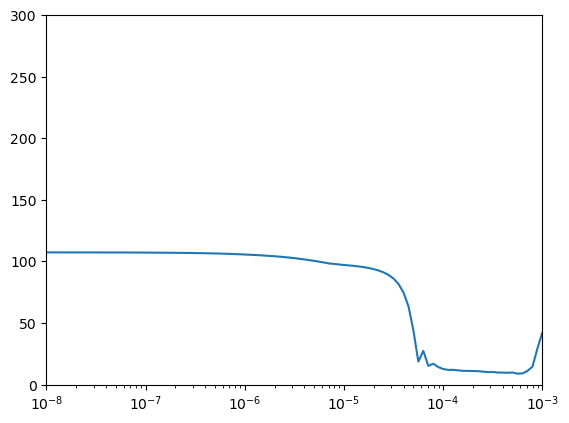

In [77]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [78]:
# MAPEが最小になる学習率は10^-3から10^-4あたり

In [79]:
%%time
# keras tunerでパラメータを探索
# split_by_144/CNN_1

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding=hp.Choice('padding', ['causal', 'valid', 'same']),
                                   activation='relu', input_shape=[None, 1]))

  model.add(Dense(units=hp.Int('units1', min_value=2, max_value=30, step=4), activation='relu'))
  model.add(Dense(units=hp.Int('units2', min_value=2, max_value=30, step=4), activation='relu'))
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9]), lr=1e-4))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=100, executions_per_trial=3, directory='split_by_144', project_name='CNN_1')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=1)

Trial 100 Complete [00h 01m 54s]
loss: 6.577900250752767

Best loss So Far: 5.949699242909749
Total elapsed time: 03h 33m 19s
INFO:tensorflow:Oracle triggered exit
CPU times: user 2h 34min 29s, sys: 22min 4s, total: 2h 56min 34s
Wall time: 3h 33min 19s


In [80]:
tuner.results_summary()

Results summary
Results in split_by_144/CNN_1
Showing 10 best trials
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 3
padding: valid
units1: 14
units2: 2
momentum: 0.9
Score: 5.949699242909749
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 3
padding: valid
units1: 10
units2: 10
momentum: 0.7
Score: 6.016314347585042
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 2
padding: valid
units1: 30
units2: 18
momentum: 0.5
Score: 6.054710388183594
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
padding: valid
units1: 30
units2: 26
momentum: 0.7
Score: 6.060712496439616
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
padding: valid
units1: 10
units2: 22
momentum: 0.7
Score: 6.0712534586588545
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 1
padding: valid
units1: 22
units2: 22
momentum: 0.5
Score: 6.077848752339681
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
padding: valid
units1: 30
u

In [83]:
from tensorflow.keras.layers import Conv1D

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=9, strides=3, padding='valid', activation='relu', input_shape=[None, 1]))
model.add(Dense(14, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 15ms/step - loss: 100.6424
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 100.1256
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 100.1648
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 100.0604
Epoch 5/500
4/4 [==============================] - 0s 6ms/step - loss: 99.8816
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 99.6251
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 99.1958
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 98.4163
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 97.1838
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 95.3037
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 91.8418
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 84.8320
Epoch 13/500
4/4 [=========================

4/4 [==============================] - 0s 6ms/step - loss: 7.2698
Epoch 105/500
4/4 [==============================] - 0s 2ms/step - loss: 7.2626
Epoch 106/500
4/4 [==============================] - 0s 2ms/step - loss: 8.3333
Epoch 107/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7742
Epoch 108/500
4/4 [==============================] - 0s 5ms/step - loss: 6.6114
Epoch 109/500
4/4 [==============================] - 0s 4ms/step - loss: 6.1953
Epoch 110/500
4/4 [==============================] - 0s 20ms/step - loss: 6.2220
Epoch 111/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3184
Epoch 112/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1645
Epoch 113/500
4/4 [==============================] - 0s 2ms/step - loss: 6.1441
Epoch 114/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2352
Epoch 115/500
4/4 [==============================] - 0s 7ms/step - loss: 6.2239
Epoch 116/500
4/4 [==============================] - 

4/4 [==============================] - 0s 3ms/step - loss: 6.1515
Epoch 207/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1216
Epoch 208/500
4/4 [==============================] - 0s 2ms/step - loss: 6.1896
Epoch 209/500
4/4 [==============================] - 0s 4ms/step - loss: 6.1543
Epoch 210/500
4/4 [==============================] - 0s 4ms/step - loss: 6.1175
Epoch 211/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1447
Epoch 212/500
4/4 [==============================] - 0s 2ms/step - loss: 6.3080
Epoch 213/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1005
Epoch 214/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1404
Epoch 215/500
4/4 [==============================] - 0s 3ms/step - loss: 6.3406
Epoch 216/500
4/4 [==============================] - 0s 2ms/step - loss: 6.9295
Epoch 217/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1288
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step - loss: 6.1464
Epoch 309/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1797
Epoch 310/500
4/4 [==============================] - 0s 5ms/step - loss: 6.2114
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4624
Epoch 312/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4079
Epoch 313/500
4/4 [==============================] - 0s 5ms/step - loss: 6.6985
Epoch 314/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4780
Epoch 315/500
4/4 [==============================] - 0s 4ms/step - loss: 6.0866
Epoch 316/500
4/4 [==============================] - 0s 3ms/step - loss: 6.1808
Epoch 317/500
4/4 [==============================] - 0s 3ms/step - loss: 6.0817
Epoch 318/500
4/4 [==============================] - 0s 4ms/step - loss: 6.0696
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2322
Epoch 320/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 7ms/step - loss: 6.7023
Epoch 411/500
4/4 [==============================] - 0s 5ms/step - loss: 6.4067
Epoch 412/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4155
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 6.8081
Epoch 414/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4348
Epoch 415/500
4/4 [==============================] - 0s 2ms/step - loss: 6.1924
Epoch 416/500
4/4 [==============================] - 0s 2ms/step - loss: 6.1837
Epoch 417/500
4/4 [==============================] - 0s 2ms/step - loss: 6.0910
Epoch 418/500
4/4 [==============================] - 0s 4ms/step - loss: 6.1145
Epoch 419/500
4/4 [==============================] - 0s 2ms/step - loss: 6.3806
Epoch 420/500
4/4 [==============================] - 0s 2ms/step - loss: 6.5297
Epoch 421/500
4/4 [==============================] - 0s 2ms/step - loss: 6.5806
Epoch 422/500
4/4 [==============================] - 0

5/5 [==============================] - 0s 14ms/step


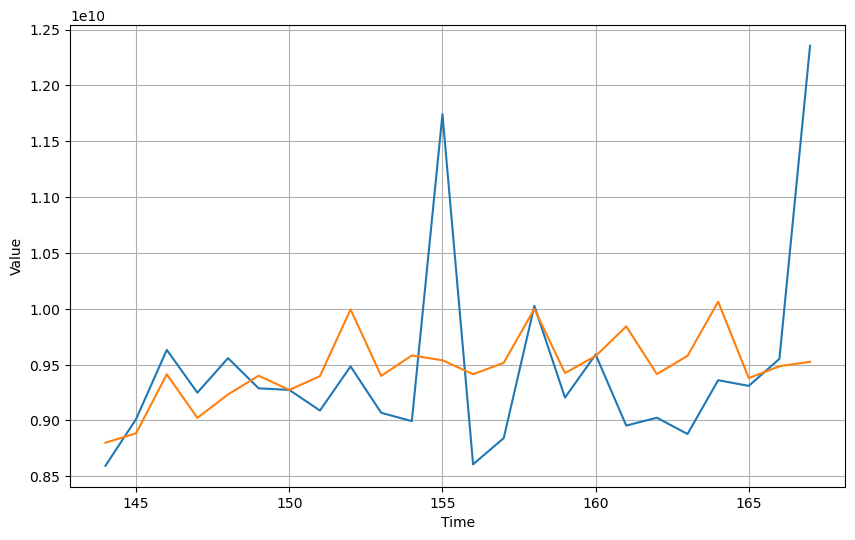

In [84]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [85]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, results))

MAPE:
0.05193978022185847


In [119]:
cnn_forecast = forecast
cnn_test_pred = results

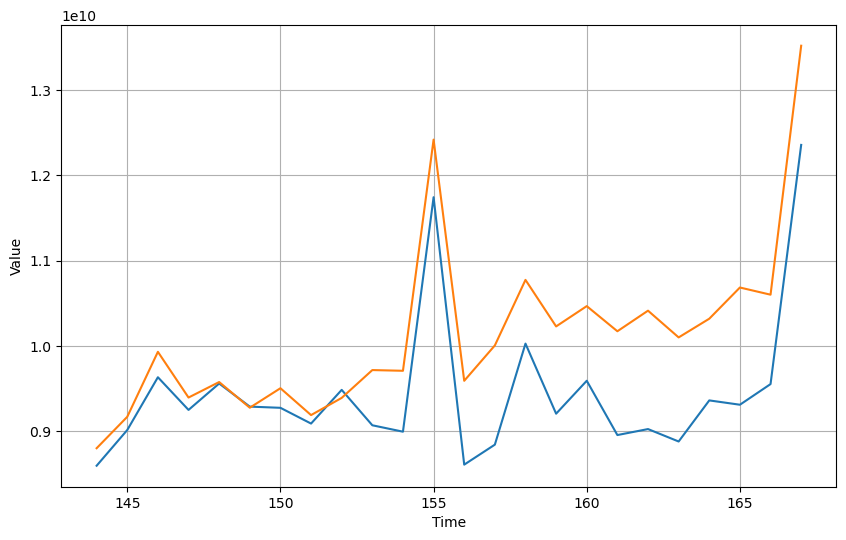

In [120]:
# SARIMAX
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, sarimax_test_pred)

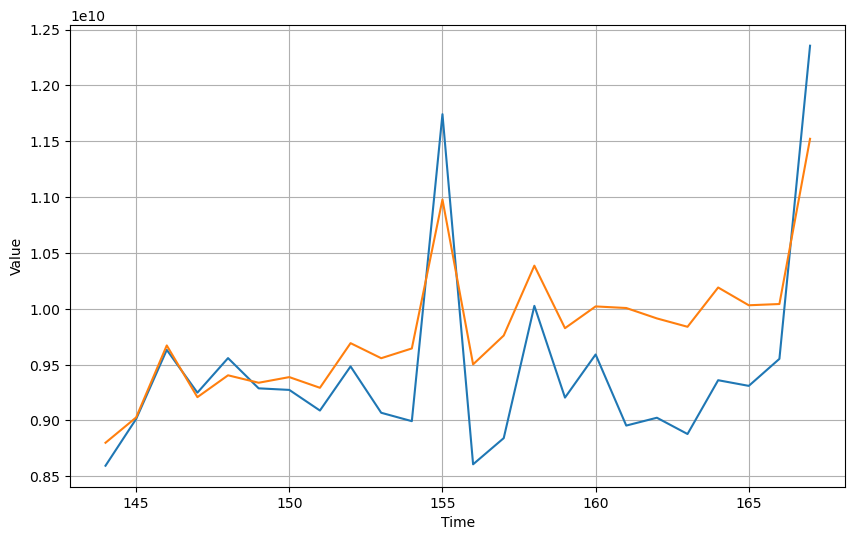

In [121]:
# SARIMAX CNN average
cnn_sarimax = np.stack((cnn_test_pred, sarimax_test_pred))
cnn_sarimax_ave_test_pred = np.mean(cnn_sarimax, axis=0)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_sarimax_ave_test_pred)

In [122]:
# MAPE
print('CNN MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('CNN SARIMAX AVERAGE MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_sarimax_ave_test_pred))

CNN MAPE:
0.05193978022185847
SARIMAX MAPE:
0.07283870396613272
CNN SARIMAX AVERAGE MAPE:
0.05287186242495132


In [123]:
# SARIMAXとCNNの平均のMAPEは、SARIMAX単体よりも改善したが、CNNには及ばなかった。
# SARIMAXは12月の売上の上昇などの季節性トレンドを把握できているが、平時は微妙。
# 一方でCNNは平時の予想ができているが、季節性トレンドまでは把握できず。
# 変動が小さい時はCNNに重みを、変動が大きい時はSARIMAXに重みを大きくつければ、予測精度はより向上すると考えられる。

In [124]:
# DNNの時のようにCNNとSARIMAXに重みをつけていく

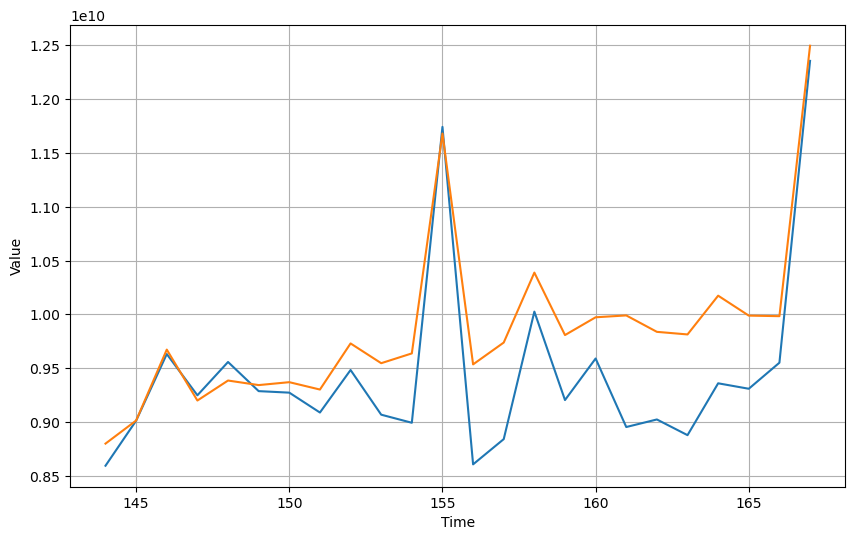

In [125]:
# b*SARIMAX+c*CNN

cnn_deviation_weighted_test_pred = np.array(b*sarimax_test_pred+c*cnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_deviation_weighted_test_pred)

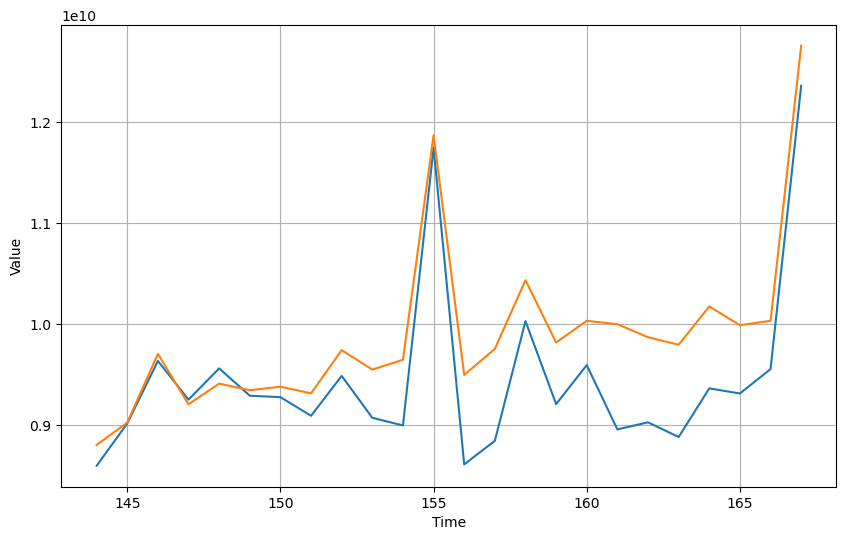

In [182]:
# e*SARIMAX+f*CNN
cnn_diff_moving_average_test_pred = np.array(e*sarimax_test_pred+f*cnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_diff_moving_average_test_pred)

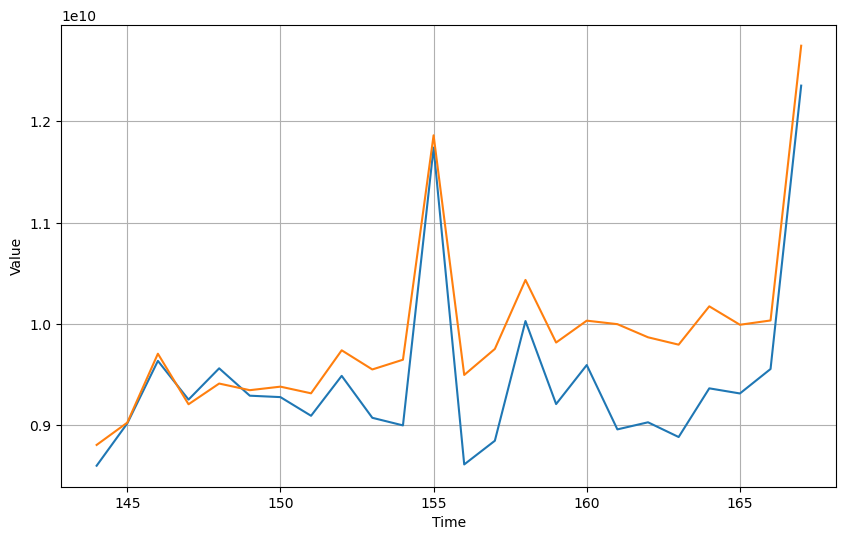

In [183]:
# g*SARIMAX+h*DNN
cnn_seasonal_trend_test_pred = np.array(g*sarimax_test_pred+h*cnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_seasonal_trend_test_pred)

In [184]:
# MAPE
print('CNN MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('CNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_sarimax_ave_test_pred))
print('CNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_deviation_weighted_test_pred))
print('CNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_diff_moving_average_test_pred))
print('CNN SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_seasonal_trend_test_pred))

CNN MAPE:
0.05193978022185847
SARIMAX MAPE:
0.07283870396613272
CNN SARIMAX Average MAPE:
0.05287186242495132
CNN SARIMAX Deviation weighted MAPE:
0.04692548448968079
CNN SARIMAX Diff Moving Average MAPE:
0.048691973240807374
CNN SARIMAX Seasonal Trend MAPE:
0.048699843757167995


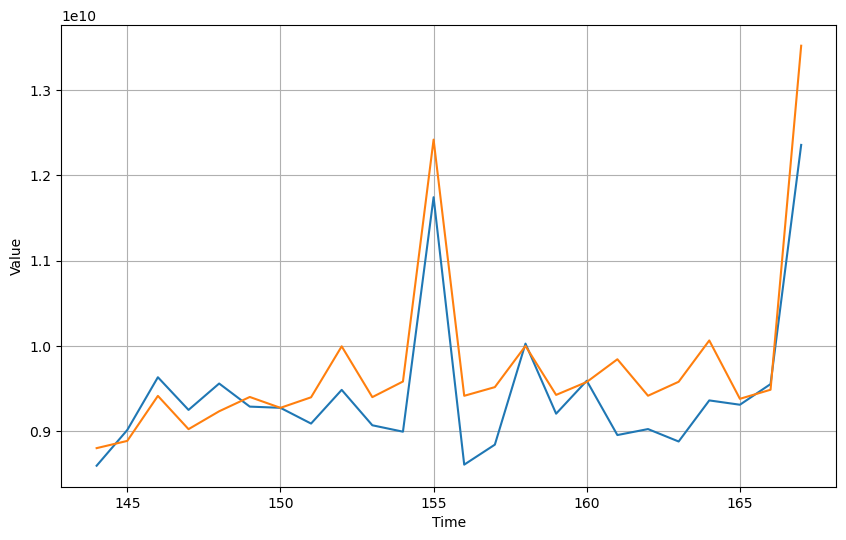

In [185]:
# 単純に12月だけSARIMAX、それ以外をCNNとしてやってみる

# CNNの12月以外の各値
cnn_test_pred_1_11 = cnn_test_pred.reshape(2,12)[:, 0:11]

# 1月-11月がDNN , 12月がSARIMAX
cnn_1_11_sarimax_12_test_pred =np.ravel(np.append(cnn_test_pred_1_11, sarimax_test_pred_12, axis=1))

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_1_11_sarimax_12_test_pred)

In [186]:
# MAPE
print('CNN MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('CNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_sarimax_ave_test_pred))
print('CNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_deviation_weighted_test_pred))
print('CNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_diff_moving_average_test_pred))
print('CNN SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_seasonal_trend_test_pred))
print('CNN 1-11 SARIMAX 12 MAPE:')
print(mean_absolute_percentage_error(x_valid, cnn_1_11_sarimax_12_test_pred))

CNN MAPE:
0.05193978022185847
SARIMAX MAPE:
0.07283870396613272
CNN SARIMAX Average MAPE:
0.05287186242495132
CNN SARIMAX Deviation weighted MAPE:
0.04692548448968079
CNN SARIMAX Diff Moving Average MAPE:
0.048691973240807374
CNN SARIMAX Seasonal Trend MAPE:
0.048699843757167995
CNN 1-11 SARIMAX 12 MAPE:
0.04089596745461201


In [135]:
# RNN

In [136]:
from tensorflow.keras.layers import SimpleRNN

In [137]:
%%time
# 学習率の大まかなエリアを絞り込む
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(SimpleRNN(100, input_shape=[None, 1], return_sequences=True, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=0)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


CPU times: user 42.7 s, sys: 5.89 s, total: 48.6 s
Wall time: 1min


(1e-08, 0.001, 0.0, 300.0)

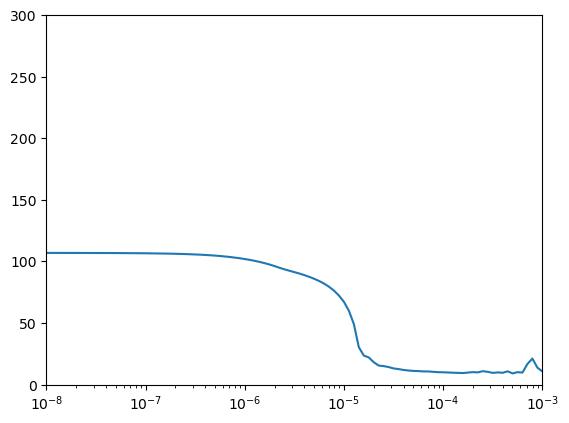

In [138]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [139]:
# MAPEは学習率が10^-4以下で最小となる

In [140]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(SimpleRNN(100, input_shape=[None, 1], return_sequences=True, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.5))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 9s 56ms/step - loss: 92.5299
Epoch 2/500
4/4 [==============================] - 0s 26ms/step - loss: 84.3066
Epoch 3/500
4/4 [==============================] - 0s 8ms/step - loss: 73.5911
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 54.2307
Epoch 5/500
4/4 [==============================] - 0s 22ms/step - loss: 22.5086
Epoch 6/500
4/4 [==============================] - 0s 10ms/step - loss: 17.5488
Epoch 7/500
4/4 [==============================] - 0s 13ms/step - loss: 16.3154
Epoch 8/500
4/4 [==============================] - 0s 8ms/step - loss: 15.6530
Epoch 9/500
4/4 [==============================] - 0s 10ms/step - loss: 14.9520
Epoch 10/500
4/4 [==============================] - 0s 14ms/step - loss: 14.2292
Epoch 11/500
4/4 [==============================] - 0s 11ms/step - loss: 13.8432
Epoch 12/500
4/4 [==============================] - 0s 11ms/step - loss: 13.5084
Epoch 13/500
4/4 [======================

4/4 [==============================] - 0s 10ms/step - loss: 9.6383
Epoch 103/500
4/4 [==============================] - 0s 9ms/step - loss: 9.5995
Epoch 104/500
4/4 [==============================] - 0s 14ms/step - loss: 9.5544
Epoch 105/500
4/4 [==============================] - 0s 13ms/step - loss: 9.5346
Epoch 106/500
4/4 [==============================] - 0s 10ms/step - loss: 9.5727
Epoch 107/500
4/4 [==============================] - 0s 11ms/step - loss: 9.5259
Epoch 108/500
4/4 [==============================] - 0s 11ms/step - loss: 9.4283
Epoch 109/500
4/4 [==============================] - 0s 15ms/step - loss: 9.4263
Epoch 110/500
4/4 [==============================] - 0s 9ms/step - loss: 9.4752
Epoch 111/500
4/4 [==============================] - 0s 13ms/step - loss: 9.4064
Epoch 112/500
4/4 [==============================] - 0s 11ms/step - loss: 9.3886
Epoch 113/500
4/4 [==============================] - 0s 12ms/step - loss: 9.3807
Epoch 114/500
4/4 [=========================

4/4 [==============================] - 0s 7ms/step - loss: 8.6938
Epoch 204/500
4/4 [==============================] - 0s 13ms/step - loss: 8.8132
Epoch 205/500
4/4 [==============================] - 0s 10ms/step - loss: 8.6762
Epoch 206/500
4/4 [==============================] - 0s 10ms/step - loss: 8.6595
Epoch 207/500
4/4 [==============================] - 0s 48ms/step - loss: 8.6965
Epoch 208/500
4/4 [==============================] - 0s 11ms/step - loss: 8.7205
Epoch 209/500
4/4 [==============================] - 0s 11ms/step - loss: 8.5909
Epoch 210/500
4/4 [==============================] - 0s 11ms/step - loss: 8.6219
Epoch 211/500
4/4 [==============================] - 0s 13ms/step - loss: 8.8646
Epoch 212/500
4/4 [==============================] - 0s 14ms/step - loss: 8.7523
Epoch 213/500
4/4 [==============================] - 0s 9ms/step - loss: 8.5283
Epoch 214/500
4/4 [==============================] - 0s 10ms/step - loss: 8.8671
Epoch 215/500
4/4 [=========================

4/4 [==============================] - 0s 15ms/step - loss: 8.0633
Epoch 305/500
4/4 [==============================] - 0s 11ms/step - loss: 8.0652
Epoch 306/500
4/4 [==============================] - 0s 9ms/step - loss: 8.2353
Epoch 307/500
4/4 [==============================] - 0s 10ms/step - loss: 8.0911
Epoch 308/500
4/4 [==============================] - 0s 12ms/step - loss: 8.2736
Epoch 309/500
4/4 [==============================] - 0s 9ms/step - loss: 8.1390
Epoch 310/500
4/4 [==============================] - 0s 9ms/step - loss: 8.1225
Epoch 311/500
4/4 [==============================] - 0s 25ms/step - loss: 8.1171
Epoch 312/500
4/4 [==============================] - 0s 13ms/step - loss: 8.0921
Epoch 313/500
4/4 [==============================] - 0s 9ms/step - loss: 8.1362
Epoch 314/500
4/4 [==============================] - 0s 9ms/step - loss: 8.0575
Epoch 315/500
4/4 [==============================] - 0s 11ms/step - loss: 8.4854
Epoch 316/500
4/4 [============================

4/4 [==============================] - 0s 9ms/step - loss: 7.9395
Epoch 406/500
4/4 [==============================] - 0s 12ms/step - loss: 8.1542
Epoch 407/500
4/4 [==============================] - 0s 9ms/step - loss: 7.8417
Epoch 408/500
4/4 [==============================] - 0s 10ms/step - loss: 7.6576
Epoch 409/500
4/4 [==============================] - 0s 9ms/step - loss: 7.7330
Epoch 410/500
4/4 [==============================] - 0s 28ms/step - loss: 8.1896
Epoch 411/500
4/4 [==============================] - 0s 8ms/step - loss: 8.4071
Epoch 412/500
4/4 [==============================] - 0s 11ms/step - loss: 8.0582
Epoch 413/500
4/4 [==============================] - 0s 9ms/step - loss: 7.8905
Epoch 414/500
4/4 [==============================] - 0s 10ms/step - loss: 7.8364
Epoch 415/500
4/4 [==============================] - 0s 10ms/step - loss: 7.7569
Epoch 416/500
4/4 [==============================] - 0s 8ms/step - loss: 7.8574
Epoch 417/500
4/4 [=============================

1/1 [==============================] - 0s 154ms/step


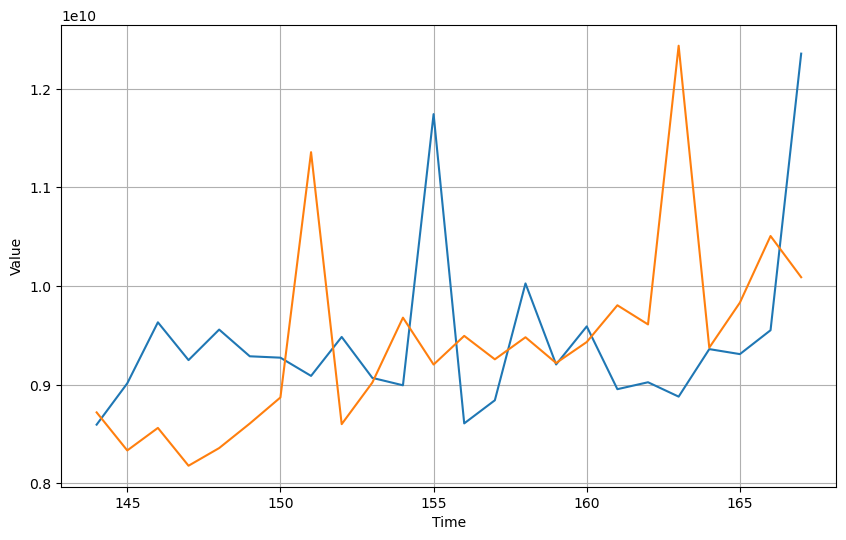

In [141]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [142]:
# やはりピークがずれる

In [143]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(SimpleRNN(100, input_shape=[None, 1], return_sequences=False, activation='relu'))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.5))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 7s 80ms/step - loss: 97.4350
Epoch 2/500
4/4 [==============================] - 0s 17ms/step - loss: 44.8848
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 8.9666
Epoch 4/500
4/4 [==============================] - 0s 14ms/step - loss: 6.5058
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 6.3977
Epoch 6/500
4/4 [==============================] - 0s 32ms/step - loss: 6.5209
Epoch 7/500
4/4 [==============================] - 0s 10ms/step - loss: 6.8631
Epoch 8/500
4/4 [==============================] - 0s 10ms/step - loss: 7.4282
Epoch 9/500
4/4 [==============================] - 0s 11ms/step - loss: 6.3058
Epoch 10/500
4/4 [==============================] - 0s 9ms/step - loss: 6.2554
Epoch 11/500
4/4 [==============================] - 0s 14ms/step - loss: 6.6450
Epoch 12/500
4/4 [==============================] - 0s 14ms/step - loss: 6.3425
Epoch 13/500
4/4 [==============================]

4/4 [==============================] - 0s 9ms/step - loss: 5.9421
Epoch 104/500
4/4 [==============================] - 0s 13ms/step - loss: 6.3874
Epoch 105/500
4/4 [==============================] - 0s 8ms/step - loss: 5.7672
Epoch 106/500
4/4 [==============================] - 0s 13ms/step - loss: 5.7330
Epoch 107/500
4/4 [==============================] - 0s 8ms/step - loss: 6.5519
Epoch 108/500
4/4 [==============================] - 0s 12ms/step - loss: 8.8173
Epoch 109/500
4/4 [==============================] - 0s 12ms/step - loss: 6.5232
Epoch 110/500
4/4 [==============================] - 0s 9ms/step - loss: 5.5781
Epoch 111/500
4/4 [==============================] - 0s 13ms/step - loss: 6.0420
Epoch 112/500
4/4 [==============================] - 0s 13ms/step - loss: 5.4250
Epoch 113/500
4/4 [==============================] - 0s 9ms/step - loss: 6.3631
Epoch 114/500
4/4 [==============================] - 0s 9ms/step - loss: 6.5141
Epoch 115/500
4/4 [=============================

4/4 [==============================] - 0s 25ms/step - loss: 5.3613
Epoch 205/500
4/4 [==============================] - 0s 8ms/step - loss: 5.8275
Epoch 206/500
4/4 [==============================] - 0s 10ms/step - loss: 5.5890
Epoch 207/500
4/4 [==============================] - 0s 9ms/step - loss: 6.3873
Epoch 208/500
4/4 [==============================] - 0s 9ms/step - loss: 5.1770
Epoch 209/500
4/4 [==============================] - 0s 10ms/step - loss: 5.8536
Epoch 210/500
4/4 [==============================] - 0s 48ms/step - loss: 5.3475
Epoch 211/500
4/4 [==============================] - 0s 9ms/step - loss: 5.7262
Epoch 212/500
4/4 [==============================] - 0s 9ms/step - loss: 5.9075
Epoch 213/500
4/4 [==============================] - 0s 8ms/step - loss: 6.7895
Epoch 214/500
4/4 [==============================] - 0s 10ms/step - loss: 5.8913
Epoch 215/500
4/4 [==============================] - 0s 8ms/step - loss: 5.7959
Epoch 216/500
4/4 [==============================

4/4 [==============================] - 0s 14ms/step - loss: 5.5221
Epoch 306/500
4/4 [==============================] - 0s 8ms/step - loss: 5.1653
Epoch 307/500
4/4 [==============================] - 0s 8ms/step - loss: 6.3739
Epoch 308/500
4/4 [==============================] - 0s 14ms/step - loss: 6.2358
Epoch 309/500
4/4 [==============================] - 0s 10ms/step - loss: 5.6155
Epoch 310/500
4/4 [==============================] - 0s 19ms/step - loss: 5.1652
Epoch 311/500
4/4 [==============================] - 0s 11ms/step - loss: 5.5637
Epoch 312/500
4/4 [==============================] - 0s 10ms/step - loss: 5.8667
Epoch 313/500
4/4 [==============================] - 0s 7ms/step - loss: 5.5224
Epoch 314/500
4/4 [==============================] - 0s 11ms/step - loss: 4.7952
Epoch 315/500
4/4 [==============================] - 0s 7ms/step - loss: 5.0039
Epoch 316/500
4/4 [==============================] - 0s 8ms/step - loss: 5.9876
Epoch 317/500
4/4 [============================

4/4 [==============================] - 0s 16ms/step - loss: 4.9610
Epoch 408/500
4/4 [==============================] - 0s 9ms/step - loss: 5.3532
Epoch 409/500
4/4 [==============================] - 0s 9ms/step - loss: 5.0046
Epoch 410/500
4/4 [==============================] - 0s 9ms/step - loss: 4.6154
Epoch 411/500
4/4 [==============================] - 0s 12ms/step - loss: 4.8725
Epoch 412/500
4/4 [==============================] - 0s 16ms/step - loss: 5.5104
Epoch 413/500
4/4 [==============================] - 0s 14ms/step - loss: 5.1406
Epoch 414/500
4/4 [==============================] - 0s 16ms/step - loss: 4.9744
Epoch 415/500
4/4 [==============================] - 0s 9ms/step - loss: 4.9108
Epoch 416/500
4/4 [==============================] - 0s 9ms/step - loss: 5.3040
Epoch 417/500
4/4 [==============================] - 0s 23ms/step - loss: 4.6104
Epoch 418/500
4/4 [==============================] - 0s 16ms/step - loss: 5.9847
Epoch 419/500
4/4 [============================

1/1 [==============================] - 0s 42ms/step


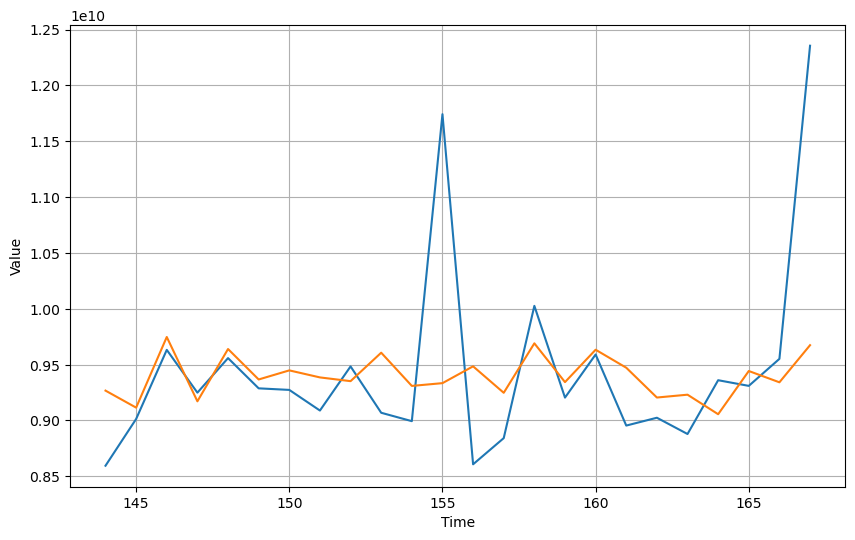

In [144]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [145]:
# ピークは取れないが、return_sequencesをFalseにした方がかなり傾向が掴める

In [146]:
%%time
# return_sequencesをFalseにした時の学習率の大まかなエリアを絞り込む
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(SimpleRNN(100, input_shape=[None, 1], return_sequences=False, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=0)

CPU times: user 47.4 s, sys: 5.6 s, total: 53 s
Wall time: 1min 7s


(1e-08, 0.001, 0.0, 300.0)

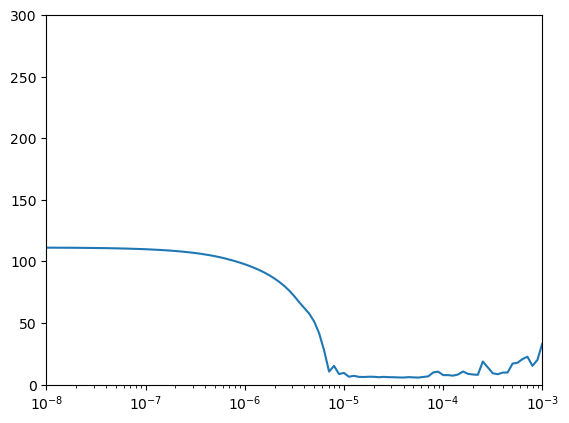

In [147]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [148]:
# これもMAPEは学習率が10^-5以下で最小となる

In [152]:
%%time
# keras tunerでパラメータを探索
# split_by_144/RNN_1

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = Sequential()
  model.add(SimpleRNN(units=hp.Int('rnn', min_value=20, max_value=200, step=20), input_shape=[None, 1], return_sequences=False, activation='relu'))
  model.add(Dense(units=hp.Int('dense', min_value=2, max_value=30, step=4), activation='relu'))
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9]), lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=60, executions_per_trial=3, directory='split_by_144', project_name='RNN_1')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=1)

Trial 60 Complete [00h 01m 39s]
loss: 5.341798464457194

Best loss So Far: 5.039449214935303
Total elapsed time: 02h 00m 54s
INFO:tensorflow:Oracle triggered exit
CPU times: user 2h 10min 29s, sys: 16min 51s, total: 2h 27min 20s
Wall time: 2h 54s


In [153]:
tuner.results_summary()

Results summary
Results in split_by_144/RNN_1
Showing 10 best trials
Trial summary
Hyperparameters:
rnn: 180
dense: 18
momentum: 0.7
Score: 5.039449214935303
Trial summary
Hyperparameters:
rnn: 140
dense: 26
momentum: 0.9
Score: 5.042315642038981
Trial summary
Hyperparameters:
rnn: 160
dense: 14
momentum: 0.5
Score: 5.05422846476237
Trial summary
Hyperparameters:
rnn: 120
dense: 26
momentum: 0.5
Score: 5.058480421702067
Trial summary
Hyperparameters:
rnn: 80
dense: 26
momentum: 0.9
Score: 5.076957543690999
Trial summary
Hyperparameters:
rnn: 160
dense: 22
momentum: 0.5
Score: 5.087303161621094
Trial summary
Hyperparameters:
rnn: 200
dense: 10
momentum: 0.5
Score: 5.092597325642903
Trial summary
Hyperparameters:
rnn: 200
dense: 14
momentum: 0.9
Score: 5.095996538798015
Trial summary
Hyperparameters:
rnn: 180
dense: 14
momentum: 0.9
Score: 5.125076611836751
Trial summary
Hyperparameters:
rnn: 120
dense: 10
momentum: 0.9
Score: 5.1483486493428545


In [156]:
%%time
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(SimpleRNN(180, input_shape=[None, 1], return_sequences=False, activation='relu'))
model.add(Dense(18))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.7))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 32ms/step - loss: 110.5147
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 99.1550
Epoch 3/500
4/4 [==============================] - 0s 14ms/step - loss: 84.7428
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: 71.1431
Epoch 5/500
4/4 [==============================] - 0s 14ms/step - loss: 56.5625
Epoch 6/500
4/4 [==============================] - 0s 11ms/step - loss: 39.4390
Epoch 7/500
4/4 [==============================] - 0s 25ms/step - loss: 17.4638
Epoch 8/500
4/4 [==============================] - 0s 17ms/step - loss: 7.7399
Epoch 9/500
4/4 [==============================] - 0s 16ms/step - loss: 6.3737
Epoch 10/500
4/4 [==============================] - 0s 22ms/step - loss: 6.2312
Epoch 11/500
4/4 [==============================] - 0s 20ms/step - loss: 6.3353
Epoch 12/500
4/4 [==============================] - 0s 16ms/step - loss: 6.3270
Epoch 13/500
4/4 [=======================

4/4 [==============================] - 0s 21ms/step - loss: 5.6552
Epoch 104/500
4/4 [==============================] - 0s 16ms/step - loss: 5.6498
Epoch 105/500
4/4 [==============================] - 0s 13ms/step - loss: 5.5144
Epoch 106/500
4/4 [==============================] - 0s 14ms/step - loss: 5.5494
Epoch 107/500
4/4 [==============================] - 0s 20ms/step - loss: 5.5193
Epoch 108/500
4/4 [==============================] - 0s 19ms/step - loss: 5.6550
Epoch 109/500
4/4 [==============================] - 0s 14ms/step - loss: 5.5488
Epoch 110/500
4/4 [==============================] - 0s 13ms/step - loss: 6.0464
Epoch 111/500
4/4 [==============================] - 0s 18ms/step - loss: 5.4601
Epoch 112/500
4/4 [==============================] - 0s 21ms/step - loss: 5.4957
Epoch 113/500
4/4 [==============================] - 0s 13ms/step - loss: 5.4630
Epoch 114/500
4/4 [==============================] - 0s 11ms/step - loss: 5.4442
Epoch 115/500
4/4 [=======================

4/4 [==============================] - 0s 13ms/step - loss: 5.3699
Epoch 205/500
4/4 [==============================] - 0s 13ms/step - loss: 5.2694
Epoch 206/500
4/4 [==============================] - 0s 15ms/step - loss: 5.3422
Epoch 207/500
4/4 [==============================] - 0s 15ms/step - loss: 5.3141
Epoch 208/500
4/4 [==============================] - 0s 21ms/step - loss: 5.4764
Epoch 209/500
4/4 [==============================] - 0s 20ms/step - loss: 5.6310
Epoch 210/500
4/4 [==============================] - 0s 13ms/step - loss: 5.3586
Epoch 211/500
4/4 [==============================] - 0s 15ms/step - loss: 5.3003
Epoch 212/500
4/4 [==============================] - 0s 19ms/step - loss: 5.2244
Epoch 213/500
4/4 [==============================] - 0s 14ms/step - loss: 5.3263
Epoch 214/500
4/4 [==============================] - 0s 13ms/step - loss: 5.3514
Epoch 215/500
4/4 [==============================] - 0s 16ms/step - loss: 5.2300
Epoch 216/500
4/4 [=======================

4/4 [==============================] - 0s 10ms/step - loss: 5.1700
Epoch 306/500
4/4 [==============================] - 0s 12ms/step - loss: 5.1837
Epoch 307/500
4/4 [==============================] - 0s 15ms/step - loss: 5.1480
Epoch 308/500
4/4 [==============================] - 0s 20ms/step - loss: 5.2664
Epoch 309/500
4/4 [==============================] - 0s 13ms/step - loss: 5.2169
Epoch 310/500
4/4 [==============================] - 0s 12ms/step - loss: 5.2446
Epoch 311/500
4/4 [==============================] - 0s 22ms/step - loss: 5.1525
Epoch 312/500
4/4 [==============================] - 0s 22ms/step - loss: 5.2727
Epoch 313/500
4/4 [==============================] - 0s 14ms/step - loss: 5.4158
Epoch 314/500
4/4 [==============================] - 0s 21ms/step - loss: 5.1900
Epoch 315/500
4/4 [==============================] - 0s 13ms/step - loss: 5.4363
Epoch 316/500
4/4 [==============================] - 0s 14ms/step - loss: 5.2458
Epoch 317/500
4/4 [=======================

4/4 [==============================] - 0s 20ms/step - loss: 4.9145
Epoch 407/500
4/4 [==============================] - 0s 12ms/step - loss: 5.0416
Epoch 408/500
4/4 [==============================] - 0s 16ms/step - loss: 4.9248
Epoch 409/500
4/4 [==============================] - 0s 14ms/step - loss: 5.0009
Epoch 410/500
4/4 [==============================] - 0s 12ms/step - loss: 5.0384
Epoch 411/500
4/4 [==============================] - 0s 15ms/step - loss: 5.0255
Epoch 412/500
4/4 [==============================] - 0s 22ms/step - loss: 4.9477
Epoch 413/500
4/4 [==============================] - 0s 13ms/step - loss: 5.0768
Epoch 414/500
4/4 [==============================] - 0s 13ms/step - loss: 4.9350
Epoch 415/500
4/4 [==============================] - 0s 14ms/step - loss: 4.9418
Epoch 416/500
4/4 [==============================] - 0s 13ms/step - loss: 5.0360
Epoch 417/500
4/4 [==============================] - 0s 13ms/step - loss: 5.2644
Epoch 418/500
4/4 [=======================

1/1 [==============================] - 0s 17ms/step


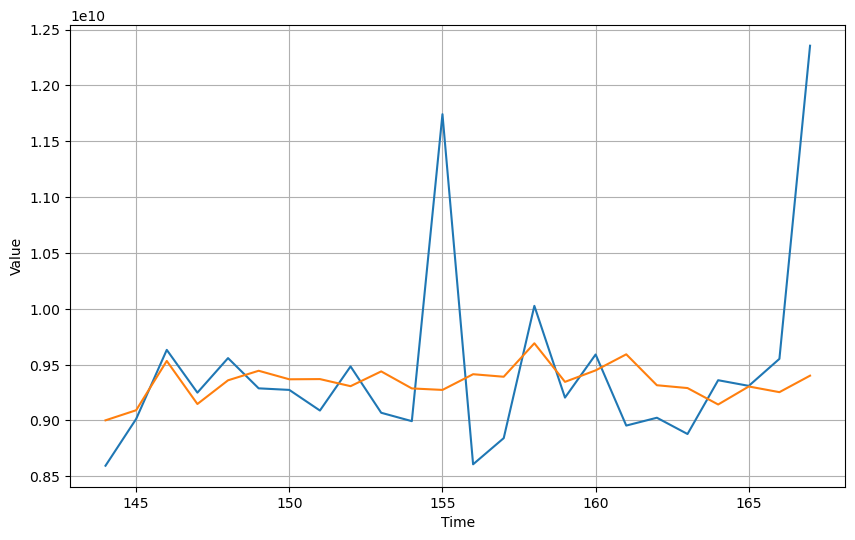

In [157]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [158]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.04674921776151081


In [159]:
rnn_forecast = forecast
rnn_test_pred = test_pred

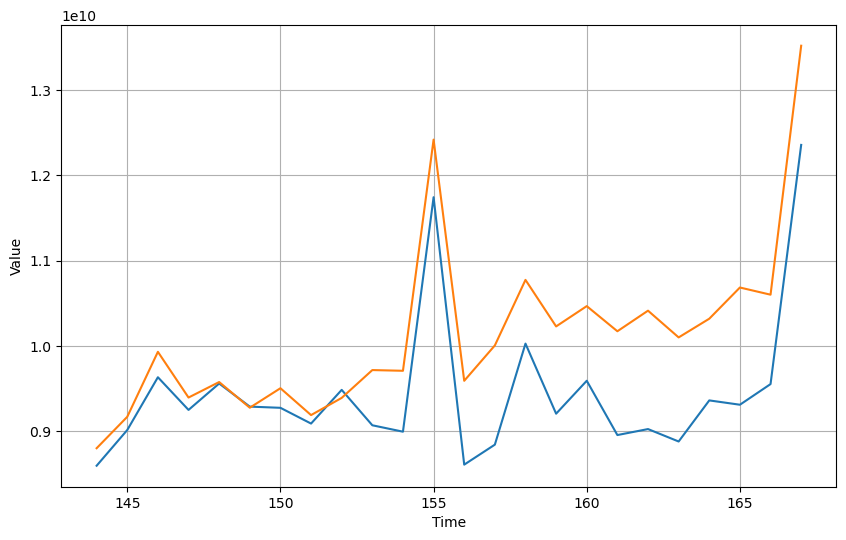

In [160]:
# SARIMAX
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, sarimax_test_pred)

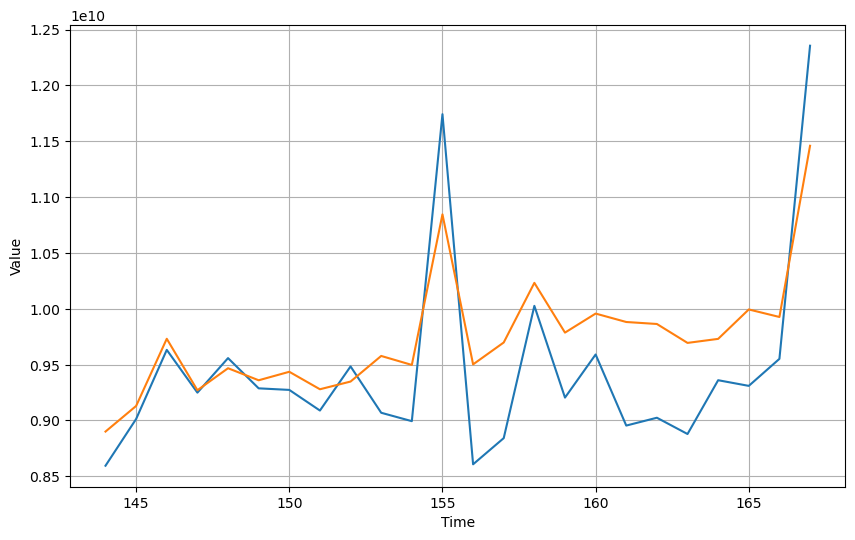

In [161]:
# SARIMAX RNN average
rnn_sarimax = np.stack((rnn_test_pred, sarimax_test_pred))
rnn_sarimax_ave_test_pred = np.mean(rnn_sarimax, axis=0)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_sarimax_ave_test_pred)

In [162]:
# MAPE
print('RNN MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('RNN SARIMAX AVERAGE MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_sarimax_ave_test_pred))

RNN MAPE:
0.04674921776151081
SARIMAX MAPE:
0.07283870396613272
RNN SARIMAX AVERAGE MAPE:
0.04815242140828416


In [163]:
# SARIMAXとRNNの平均のMAPEは、RNN・SARIMAX単体よりも改善した。
# SARIMAXは12月の売上の上昇などの季節性トレンドを把握できているが、平時は微妙。
# 一方でRNNは平時の予想ができているが、季節性トレンドまでは把握できず。
# 変動が小さい時はRNNに重みを、変動が大きい時はSARIMAXに重みを大きくつければ、予測精度はより向上すると考えられる。

In [164]:
# DNN・CNNの時のようにRNNとSARIMAXに重みをつけていく

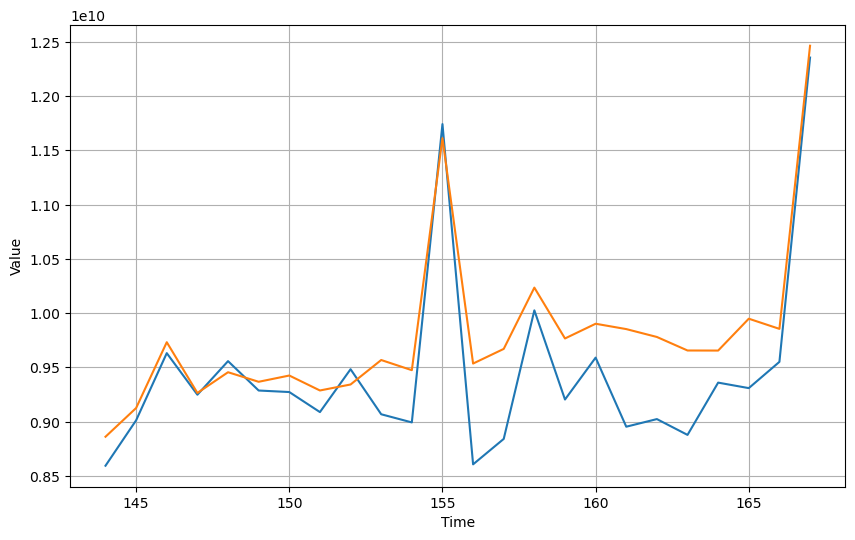

In [165]:
# b*SARIMAX+c*RNN

rnn_deviation_weighted_test_pred = np.array(b*sarimax_test_pred+c*rnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_deviation_weighted_test_pred)

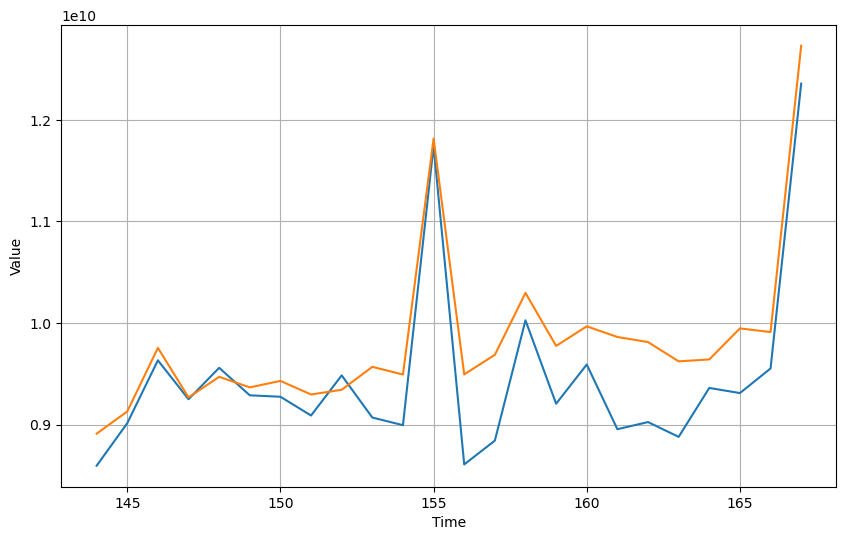

In [187]:
# e*SARIMAX+f*RNN
rnn_diff_moving_average_test_pred = np.array(e*sarimax_test_pred+f*rnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_diff_moving_average_test_pred)

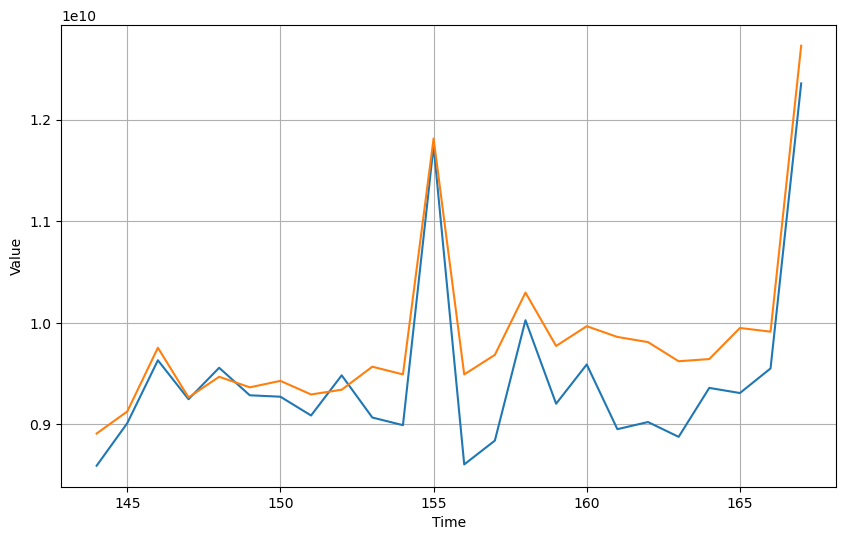

In [188]:
# g*SARIMAX+h*RNN
rnn_seasonal_trend_test_pred = np.array(g*sarimax_test_pred+h*rnn_test_pred)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_seasonal_trend_test_pred)

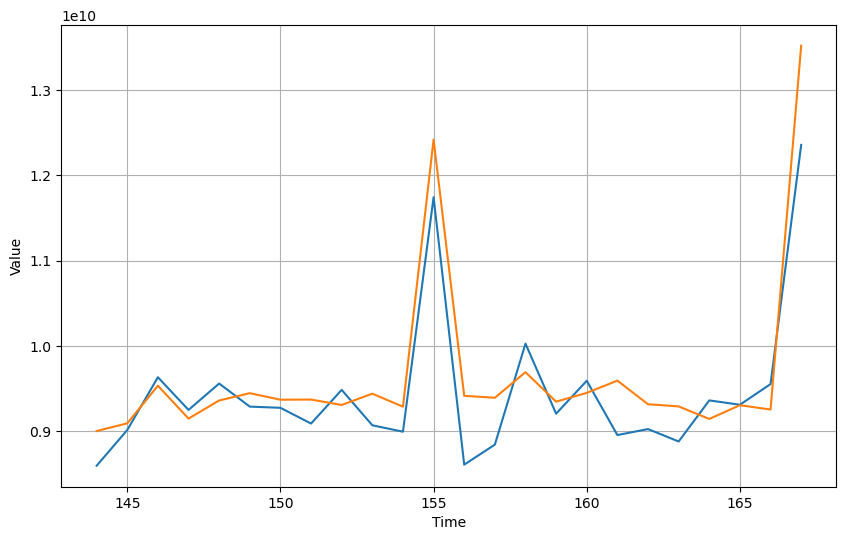

In [189]:
# 単純に12月だけSARIMAX、それ以外をRNNとしてやってみる

# RNNの12月以外の各値
rnn_test_pred_1_11 = rnn_test_pred.reshape(2,12)[:, 0:11]

# 1月-11月がRNN , 12月がSARIMAX
rnn_1_11_sarimax_12_test_pred =np.ravel(np.append(rnn_test_pred_1_11, sarimax_test_pred_12, axis=1))

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_1_11_sarimax_12_test_pred)

In [190]:
# MAPE
print('RNN MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_test_pred))
print('SARIMAX MAPE:')
print(mean_absolute_percentage_error(df_test, sarimax_test_pred))
print('RNN SARIMAX Average MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_sarimax_ave_test_pred))
print('RNN SARIMAX Deviation weighted MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_deviation_weighted_test_pred))
print('RNN SARIMAX Diff Moving Average MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_diff_moving_average_test_pred))
print('RNN SARIMAX Seasonal Trend MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_seasonal_trend_test_pred))
print('RNN 1-11 SARIMAX 12 MAPE:')
print(mean_absolute_percentage_error(x_valid, rnn_1_11_sarimax_12_test_pred))

RNN MAPE:
0.04674921776151081
SARIMAX MAPE:
0.07283870396613272
RNN SARIMAX Average MAPE:
0.04815242140828416
RNN SARIMAX Deviation weighted MAPE:
0.04070667803017516
RNN SARIMAX Diff Moving Average MAPE:
0.042404543409948654
RNN SARIMAX Seasonal Trend MAPE:
0.04243970553357907
RNN 1-11 SARIMAX 12 MAPE:
0.034343227219876545


In [191]:
# CNN

In [192]:
# 学習率の大まかなエリアを絞り込む
# ReLU・エポック数500

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=[None, 1]))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mape", optimizer=optimizer)
history = model.fit(dataset, epochs=500, callbacks=[lr_schedule], verbose=1)

/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/500
4/4 [==============================] - 4s 311ms/step - loss: 97.5882 - lr: 1.0000e-08
Epoch 2/500
4/4 [==============================] - 0s 24ms/step - loss: 97.5852 - lr: 1.1220e-08
Epoch 3/500
4/4 [==============================] - 0s 9ms/step - loss: 97.5798 - lr: 1.2589e-08
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 97.5724 - lr: 1.4125e-08
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 97.5632 - lr: 1.5849e-08
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 97.5523 - lr: 1.7783e-08
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 97.5397 - lr: 1.9953e-08
Epoch 8/500
4/4 [==============================] - 0s 9ms/step - loss: 97.5253 - lr: 2.2387e-08
Epoch 9/500
4/4 [==============================] - 0s 13ms/step - loss: 97.5091 - lr: 2.5119e-08
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 97.4907 - lr: 2.8184e-08
Epoch 11/500
4/4 [=================

4/4 [==============================] - 0s 5ms/step - loss: 7.8251 - lr: 1.5849e-04
Epoch 86/500
4/4 [==============================] - 0s 4ms/step - loss: 7.9002 - lr: 1.7783e-04
Epoch 87/500
4/4 [==============================] - 0s 5ms/step - loss: 8.0311 - lr: 1.9953e-04
Epoch 88/500
4/4 [==============================] - 0s 5ms/step - loss: 8.0343 - lr: 2.2387e-04
Epoch 89/500
4/4 [==============================] - 0s 10ms/step - loss: 8.1340 - lr: 2.5119e-04
Epoch 90/500
4/4 [==============================] - 0s 5ms/step - loss: 8.0717 - lr: 2.8184e-04
Epoch 91/500
4/4 [==============================] - 0s 8ms/step - loss: 7.9596 - lr: 3.1623e-04
Epoch 92/500
4/4 [==============================] - 0s 5ms/step - loss: 8.0110 - lr: 3.5481e-04
Epoch 93/500
4/4 [==============================] - 0s 4ms/step - loss: 7.9555 - lr: 3.9811e-04
Epoch 94/500
4/4 [==============================] - 0s 6ms/step - loss: 8.0545 - lr: 4.4668e-04
Epoch 95/500
4/4 [==============================] - 

4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 3.1623
Epoch 172/500
4/4 [==============================] - 0s 7ms/step - loss: 100.0000 - lr: 3.5481
Epoch 173/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 3.9811
Epoch 174/500
4/4 [==============================] - 0s 9ms/step - loss: 100.0000 - lr: 4.4668
Epoch 175/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 5.0119
Epoch 176/500
4/4 [==============================] - 0s 7ms/step - loss: 100.0000 - lr: 5.6234
Epoch 177/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 6.3096
Epoch 178/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 7.0795
Epoch 179/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 7.9433
Epoch 180/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 8.9125
Epoch 181/500
4/4 [==============================] - 0s 16ms/ste

4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 50118.7227
Epoch 256/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 56234.1328
Epoch 257/500
4/4 [==============================] - 0s 7ms/step - loss: 100.0000 - lr: 63095.7344
Epoch 258/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 70794.5781
Epoch 259/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 79432.8203
Epoch 260/500
4/4 [==============================] - 0s 6ms/step - loss: 100.0000 - lr: 89125.0938
Epoch 261/500
4/4 [==============================] - 0s 7ms/step - loss: 100.0000 - lr: 100000.0000
Epoch 262/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 112201.8438
Epoch 263/500
4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 125892.5391
Epoch 264/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 141253.7500
Epoch 265/500
4/4 [=

4/4 [==============================] - 0s 5ms/step - loss: 100.0000 - lr: 562341312.0000
Epoch 337/500
4/4 [==============================] - 0s 7ms/step - loss: 100.0000 - lr: 630957376.0000
Epoch 338/500
4/4 [==============================] - 0s 4ms/step - loss: 100.0000 - lr: 707945792.0000
Epoch 339/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 794328256.0000
Epoch 340/500
4/4 [==============================] - 0s 8ms/step - loss: 99.9999 - lr: 891250944.0000
Epoch 341/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 1000000000.0000
Epoch 342/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 1122018432.0000
Epoch 343/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 1258925440.0000
Epoch 344/500
4/4 [==============================] - 0s 5ms/step - loss: 99.9999 - lr: 1412537600.0000
Epoch 345/500
4/4 [==============================] - 0s 7ms/step - loss: 99.9999 - lr: 15

4/4 [==============================] - 0s 5ms/step - loss: 99.6431 - lr: 4466835718144.0000
Epoch 415/500
4/4 [==============================] - 0s 5ms/step - loss: 99.5999 - lr: 5011872415744.0000
Epoch 416/500
4/4 [==============================] - 0s 5ms/step - loss: 99.5507 - lr: 5623413473280.0000
Epoch 417/500
4/4 [==============================] - 0s 6ms/step - loss: 99.4963 - lr: 6309573296128.0000
Epoch 418/500
4/4 [==============================] - 0s 4ms/step - loss: 99.4350 - lr: 7079457718272.0000
Epoch 419/500
4/4 [==============================] - 0s 21ms/step - loss: 99.3657 - lr: 7943282491392.0000
Epoch 420/500
4/4 [==============================] - 0s 8ms/step - loss: 99.2886 - lr: 8912509075456.0000
Epoch 421/500
4/4 [==============================] - 0s 7ms/step - loss: 99.2021 - lr: 9999999827968.0000
Epoch 422/500
4/4 [==============================] - 0s 5ms/step - loss: 99.1042 - lr: 11220184727552.0000
Epoch 423/500
4/4 [==============================] - 0s 6m

Epoch 490/500
4/4 [==============================] - 0s 7ms/step - loss: 22.9337 - lr: 28183828799422464.0000
Epoch 491/500
4/4 [==============================] - 0s 4ms/step - loss: 21.8953 - lr: 31622776901074944.0000
Epoch 492/500
4/4 [==============================] - 0s 7ms/step - loss: 21.5558 - lr: 35481339012579328.0000
Epoch 493/500
4/4 [==============================] - 0s 7ms/step - loss: 21.5507 - lr: 39810717586554880.0000
Epoch 494/500
4/4 [==============================] - 0s 5ms/step - loss: 21.3036 - lr: 44668359958069248.0000
Epoch 495/500
4/4 [==============================] - 0s 4ms/step - loss: 21.3202 - lr: 50118724996300800.0000
Epoch 496/500
4/4 [==============================] - 0s 4ms/step - loss: 21.8112 - lr: 56234131360579584.0000
Epoch 497/500
4/4 [==============================] - 0s 6ms/step - loss: 21.3851 - lr: 63095732457963520.0000
Epoch 498/500
4/4 [==============================] - 0s 3ms/step - loss: 22.0784 - lr: 70794577300160512.0000
Epoch 499/

(1e-08, 0.001, 0.0, 300.0)

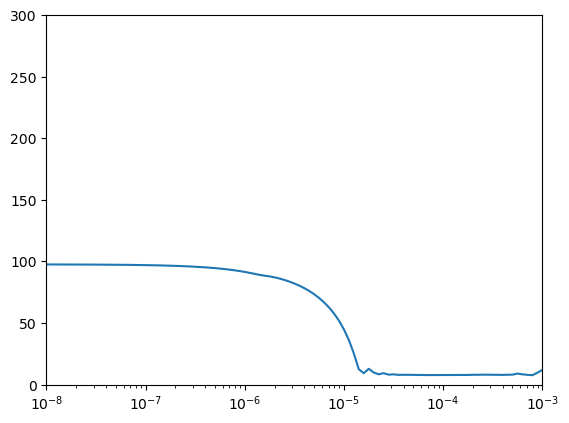

In [193]:
lrs = 1e-8 * (10 ** (np.arange(500) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [194]:
# MAPEが最小になる学習率は10^-3から10^-4あたり

In [195]:
%%time
# keras tunerでパラメータを探索
# split_by_144/CNN_2

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(filters=hp.Int('units',min_value=128, max_value=256, step=64), 
                                   kernel_size=hp.Int('kernels', min_value=3, max_value=9, step=3),
                                   strides=hp.Int('strides', min_value=1, max_value=3, step=1),
                                   padding=hp.Choice('padding', ['causal', 'valid', 'same']),
                                   activation='relu', input_shape=[None, 1]))

  model.add(Dense(units=hp.Int('units1', min_value=2, max_value=30, step=4), activation='relu'))
  model.add(Dense(1))

  model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[0.5, 0.7, 0.9]), lr=1e-4))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=60, executions_per_trial=3, directory='split_by_144', project_name='CNN_2')

tuner.search_space_summary()

tuner.search(dataset, epochs=500, verbose=1)

Trial 60 Complete [00h 01m 51s]
loss: 7.177413145701091

Best loss So Far: 6.06356414159139
Total elapsed time: 02h 04m 24s
INFO:tensorflow:Oracle triggered exit
CPU times: user 1h 29min 26s, sys: 13min 2s, total: 1h 42min 29s
Wall time: 2h 4min 25s


In [196]:
tuner.results_summary()

Results summary
Results in split_by_144/CNN_2
Showing 10 best trials
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
padding: valid
units1: 6
momentum: 0.9
Score: 6.06356414159139
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 2
padding: valid
units1: 26
momentum: 0.5
Score: 6.068073431650798
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 2
padding: valid
units1: 18
momentum: 0.7
Score: 6.079476674397786
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
padding: valid
units1: 18
momentum: 0.9
Score: 6.092966238657634
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 2
padding: same
units1: 6
momentum: 0.9
Score: 6.244730631510417
Trial summary
Hyperparameters:
units: 192
kernels: 9
strides: 3
padding: same
units1: 10
momentum: 0.9
Score: 6.2889335950215655
Trial summary
Hyperparameters:
units: 128
kernels: 9
strides: 2
padding: same
units1: 26
momentum: 0.9
Score: 6.3197323481241865
Trial summary
Hyperparameters:
u

In [202]:
# units: 192
# kernels: 9
# strides: 2
# padding: valid
# units1: 6
# momentum: 0.9
# Score: 6.06356414159139


dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = Sequential()
model.add(Conv1D(filters=192, kernel_size=9, strides=2, padding='valid', activation='relu', input_shape=[None, 1]))
model.add(Dense(6, activation='relu'))
model.add(Dense(1))

model.compile(loss="mape", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9))
model.fit(dataset, epochs=500,  verbose=1)

Epoch 1/500


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 57ms/step - loss: 91.4048
Epoch 2/500
4/4 [==============================] - 0s 7ms/step - loss: 37.5984
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 28.9161
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 16.4962
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 14.1030
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 14.3723
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 12.8431
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 9.9239
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 7.5561
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 7.6755
Epoch 11/500
4/4 [==============================] - 0s 7ms/step - loss: 7.1634
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 7.5814
Epoch 13/500
4/4 [==============================] - 0s 2ms/step -

4/4 [==============================] - 0s 2ms/step - loss: 6.5462
Epoch 105/500
4/4 [==============================] - 0s 3ms/step - loss: 6.7690
Epoch 106/500
4/4 [==============================] - 0s 3ms/step - loss: 6.8996
Epoch 107/500
4/4 [==============================] - 0s 3ms/step - loss: 6.6481
Epoch 108/500
4/4 [==============================] - 0s 2ms/step - loss: 6.5215
Epoch 109/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4782
Epoch 110/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4857
Epoch 111/500
4/4 [==============================] - 0s 3ms/step - loss: 6.5473
Epoch 112/500
4/4 [==============================] - 0s 2ms/step - loss: 6.3112
Epoch 113/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2923
Epoch 114/500
4/4 [==============================] - 0s 4ms/step - loss: 6.2590
Epoch 115/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3768
Epoch 116/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 6.3353
Epoch 207/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2800
Epoch 208/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2284
Epoch 209/500
4/4 [==============================] - 0s 2ms/step - loss: 6.5230
Epoch 210/500
4/4 [==============================] - 0s 2ms/step - loss: 6.7990
Epoch 211/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2527
Epoch 212/500
4/4 [==============================] - 0s 2ms/step - loss: 6.3454
Epoch 213/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4141
Epoch 214/500
4/4 [==============================] - 0s 2ms/step - loss: 6.3897
Epoch 215/500
4/4 [==============================] - 0s 3ms/step - loss: 6.3734
Epoch 216/500
4/4 [==============================] - 0s 2ms/step - loss: 6.3265
Epoch 217/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4865
Epoch 218/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step - loss: 6.8037
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2672
Epoch 310/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4287
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4520
Epoch 312/500
4/4 [==============================] - 0s 2ms/step - loss: 6.3151
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 6.5119
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 6.7627
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 6.7007
Epoch 316/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4233
Epoch 317/500
4/4 [==============================] - 0s 2ms/step - loss: 6.4647
Epoch 318/500
4/4 [==============================] - 0s 3ms/step - loss: 6.2376
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 6.3533
Epoch 320/500
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step - loss: 6.9477
Epoch 411/500
4/4 [==============================] - 0s 4ms/step - loss: 6.4465
Epoch 412/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4677
Epoch 413/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4471
Epoch 414/500
4/4 [==============================] - 0s 5ms/step - loss: 6.3633
Epoch 415/500
4/4 [==============================] - 0s 4ms/step - loss: 6.3501
Epoch 416/500
4/4 [==============================] - 0s 3ms/step - loss: 6.4474
Epoch 417/500
4/4 [==============================] - 0s 3ms/step - loss: 6.3700
Epoch 418/500
4/4 [==============================] - 0s 2ms/step - loss: 6.3256
Epoch 419/500
4/4 [==============================] - 0s 4ms/step - loss: 6.2607
Epoch 420/500
4/4 [==============================] - 0s 4ms/step - loss: 6.5488
Epoch 421/500
4/4 [==============================] - 0s 3ms/step - loss: 7.2420
Epoch 422/500
4/4 [==============================] - 0

1/1 [==============================] - 0s 20ms/step


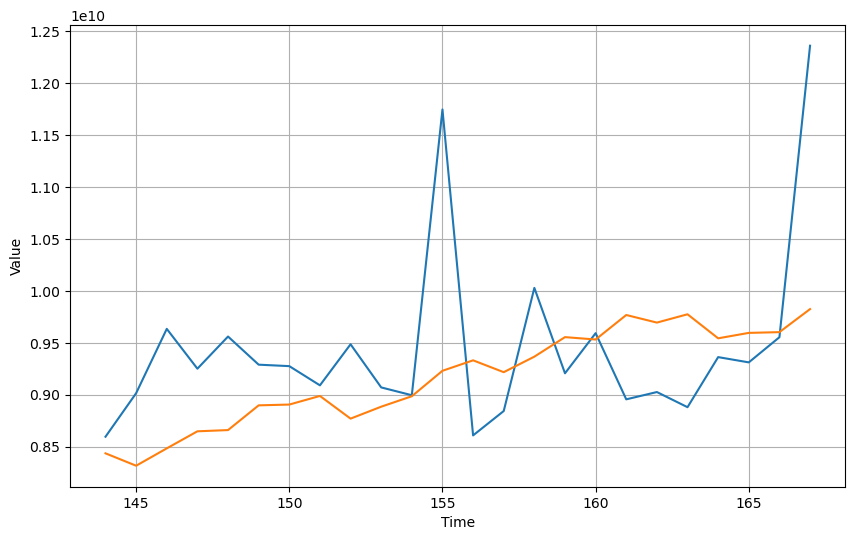

In [203]:
forecast = []
for time in range(168 - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

train_pred = np.array(forecast[:split_time-window_size])[:, 0, 0]
test_pred = np.array(forecast[split_time-window_size:])[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, test_pred)

In [204]:
print('MAPE:')
print(mean_absolute_percentage_error(x_valid, test_pred))

MAPE:
0.06417397323289122
